In [1]:
import sys
sys.path.append('./library') # age_gender_predictor
sys.path.append('../.env/lib/python2.7/site-packages') # make sure it can get virtualenv lib
import age_gender_predictor
from datetime import datetime, timedelta
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from nltk import PorterStemmer
import re
from scipy.sparse import hstack
from scipy.sparse import vstack
from copy import copy
import pandas as pd
import json
import os
from collections import defaultdict

## Loding scikit-learn models

In [2]:
def load_model(file_location):
    model = joblib.load(file_location)
    return model 

#Loding Bipolar Random Forest
bipolar_model = load_model("models/bipolar_forest/bipolar_forest_2week_modified")


## Process Data Function
### Age and gender Distribution

In [3]:
def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)

### Social Feature

In [4]:
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_tweets / float(total_duration)
    except:
        result = total_tweets / 1.0
    return result

def getLateTweetRate(timeSeries):
    total_late = 0
    for index in timeSeries.index:
        if int(index.hour) <6:
            total_late += 1
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_late / float(total_duration)
    except:
        result = total_late / 1.0
    return result

def getMentionRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / float(total_tweets)

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)
    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
    return social_features

def getAllFeature(group, tail_k = "all"):
    feature_set = {}
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getAgeGender]
    for method in methods:
        feature_set.update(method(group.getGroup(tail_k)))
    return feature_set


### Polarity Feature

In [5]:
def getFlipsCount(timeSeries, upperbound=120, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )

def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / float(total_tweets)

def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / float(total_tweets)

def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        try:
            tweets_length = float(timeSeries.shape[0])
        except:
            print 'error'
            print timeSeries
            break
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity

def comboTracker(timeSeries, attribute= "polarity", lowerbound = 120):
    array = timeSeries[attribute]
#     the polarity of starter
    starter = array[0]
    combo = 1
    result = []
    i = 0 
#     begin from second one in the array
    for cursor in array[1:]:
        i += 1
        if starter == cursor and timeSeries["dt"][i-1] < lowerbound:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

### Emotion Feature

In [6]:



def getUsersEmotionsDict(users_timeSeries):
#     user -> emotion count
    user_emotion_dict = defaultdict(lambda: {"joy":0,
                                       "sadness": 0,
                                       "fear":0,
                                       "anticipation": 0,
                                       "anger":0,
                                       "trust": 0,
                                       "disgust": 0,
                                       "surprise" : 0
                                      })
    for user in users_timeSeries:
        user_tweets_count = 0
#         date, [tweet_info, tweets_info ...]
        for date, tweets_infos in users_timeSeries[user].iteritems():
            if date_not_in_range(user, datetime.strptime(str(date), "%Y%m%d")): continue
            for tweet_info in tweets_infos:                
    #             content, emotion1, emotion2, ambiguous
                if(tweet_info[3].strip() != 'yes'):
    #         only get the first emotion now
                    user_emotion_dict[user][tweet_info[1]] += 1
                    user_tweets_count += 1
    
        for emotion in user_emotion_dict[user]:
            if user_tweets_count == 0:
                user_emotion_dict[user][emotion] = 0
            else:
                user_emotion_dict[user][emotion] = float(user_emotion_dict[user][emotion]) / user_tweets_count
    return user_emotion_dict

def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    if float(filtered_emotions.shape[0]) == 0:
        divider = 1.0
    else:
        divider = float(filtered_emotions.shape[0])
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / divider
    return emotions_count

def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts



In [7]:
def getPOLFeature(user_timeSeries_list):
    features = np.zeros((len(user_timeSeries_list),20),dtype=float)
    for i, timeSeries in enumerate(user_timeSeries_list):
        
        tweets_length = float(timeSeries.shape[0])
        tweets_rate = getTweetRate(timeSeries)
        late_tweets_rate = getLateTweetRate(timeSeries)
        mention_rate = getMentionRate(timeSeries)
        unique_mentions = getUniqueMentions(timeSeries)
        frequent_mentions = getFrequentMentions(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        positive_ratio = getPositiveRatio(timeSeries)
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos = getCombosCount(timeSeries) / tweets_length
        positive_combos = getCombosCount(timeSeries,matcher=1) / tweets_length
        emotion_counts_dict = getUsersEmotions(timeSeries)


        age = getAge(timeSeries)
        gender = getGender(timeSeries)

        features[i][0] = tweets_rate
        features[i][1] = late_tweets_rate
        features[i][2] = mention_rate
        features[i][3] = unique_mentions
        features[i][4] = frequent_mentions 
        features[i][5] = positive_ratio
        features[i][6] = negative_ratio
        features[i][7] = flips_ratio
        features[i][8] = negative_combos
        features[i][9] = positive_combos
        features[i][10] = age
        features[i][11] = gender
        for j, emotion in enumerate(["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]):
            features[i][12+j] = np.mean(emotion_counts_dict[emotion])
        
            
    return features

# Predict

In [8]:
def pol_report(timeline):
#     A list of 8-weeks-timeSeries timeline
    timeSeries_list = getTimeSeries(timeline)
    features = getPOLFeature(timeSeries_list)
    
    user_timeline_reports = []
    for i, feature in enumerate(features):
        timeSeries = timeSeries_list[i]
#         print(bipolar_model.predict_proba(feature))
        bipolar_proba = bipolar_model.predict_proba(feature)[0][0][1]

        report = {}
        report["tweets_length"] = timeSeries_list[i].shape[0]
        report["tweeting_frequency"] = feature[0]
        report["late_tweeting_frequency"] = feature[1]
        report["mentioning_frequency"] = feature[2]
        report["unique_mentioning"] = feature[3]
        report["frequent_mentioning"] = feature[4]
        report["positive_ratio"] = feature[5]
        report["negative_ratio"] = feature[6]
        report["flips_ratio"] = feature[7]
        report["negative_combos"] = feature[8]
        report["positive_combos"] = feature[9]
        report["age"] = features[0][10]
        report["gender"] = "Male" if features[0][11] < 0 else "Female"
        report["bipolar_probability"] = bipolar_proba
        
        user_timeline_reports.append(report)

    return user_timeline_reports


### Load Predict File

In [9]:
def checkFolderFile(folder):
    return os.listdir(folder)

# ## Read BD_user
def loadTweets(folder, filename, tweets_dict):
    with open(folder + filename, 'r') as openfile:
        for line in openfile.readlines():
            try:
                username, date, datetime, content, sentiment, emotion1, emotion2, ambiguous = line.split('\t')
            except:
                print(line.split('\t'))
            tweets_dict[username][int(date)].append((datetime, content, sentiment, emotion1, emotion2, ambiguous.strip()))
    return tweets_dict

In [10]:
def date_not_in_range(user, ill_time_dict, date):
    if date >= ill_time_dict[user] - timedelta(weeks=6) \
    and date <= ill_time_dict[user] + timedelta(weeks=3):
        return False
    else:
        return True
def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())

def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values

def userFilter(group, spam_threshold=0.5,tweets_threshold=25, time_filter = False):    #Spam and inactive user filter
    #     to restrict date in latest 8 weeks
    if time_filter == True:
        temp_group=[]
        for timeSeries in group:
            eight_week_period = timeSeries.index[-1]- timedelta(weeks=8)
            temp_group.append(timeSeries[timeSeries.index > eight_week_period])
        group = temp_group
            
    new_group = []
    for timeSeries in group:
        http_rows = getHTTPRows(timeSeries)
        average_http_count = np.sum(http_rows) / timeSeries.shape[0]
        if (average_http_count < spam_threshold) and (timeSeries.shape[0] > tweets_threshold):
            new_group.append(timeSeries)
    return new_group

def TweetsFormating(tweets_dict, ill_time_dict=None,en_threshold=0.9):
    usersTweets = {}
    true_yes_dict = {'yes':True, 'no':False, 'None': True}
    for user in tweets_dict:       
        userID = user
        if ill_time_dict is not None:
            if user not in ill_time_dict: continue
        for date_ in tweets_dict[user]:
#             if date_not_in_range(user, ill_time_dict ,datetime.strptime(str(date_), "%Y%m%d")): continue
            for tweet_info in tweets_dict[user][date_]:
                date, content, polarity, emotion1, emotion2, ambiguous = tweet_info
   
                date = datetime.strptime(str(date), "%Y-%m-%d %H:%M:%S") - timedelta(hours = 8) #Modify the time! Because get all tweets is from taiwan(+8) not +0
                text = content
                
                if userID not in usersTweets:
                    usersTweets[userID] = {}
                if date not in usersTweets[userID]:
                    usersTweets[userID][date] = {}
                usersTweets[userID][date]['name'] = userID
                usersTweets[userID][date]['text'] = text
                usersTweets[userID][date]['polarity'] =  int(polarity.strip())
                
                
                usersTweets[userID][date]['emotion'] =  emotion1
                usersTweets[userID][date]['emotion_2'] =  emotion2
                usersTweets[userID][date]['ambiguous'] =  true_yes_dict[ambiguous]

    return usersTweets
    

In [11]:
def readPatientIllTime(folder, filename):
    with open(folder + filename, 'r') as openfile:
        return [line.strip().split('\t') for line in openfile.readlines()]
    
# ## Get ill time information
patient_ill_time_list = readPatientIllTime('./', 'bipolar_list')
patient_ill_time_dict = {line[0]: line[1] for line in patient_ill_time_list}

# dict[user][diagnosed_time(datetime)]
patient_month_time_dict = {}

for patient in patient_ill_time_dict:
    datetime_list = patient_ill_time_dict[patient].split('/')
    if len(datetime_list) > 1:
        if len(datetime_list) > 2:
            patient_month_time_dict[patient] = datetime(int(datetime_list[0]), int(datetime_list[1]), int(datetime_list[2]))
        else:
            patient_month_time_dict[patient] = datetime(int(datetime_list[0]),int(datetime_list[1]),1)
    else:
        continue
del patient_ill_time_list
print( 'Patient Counts from month ill time:' + str(len(patient_month_time_dict)))

Patient Counts from month ill time:272


In [12]:
user_folder = 'patient emo_senti/'
# {username:{int(date):{[(datetime,content,sentiment,emotion1,emotion2,ambiguous),...]}}}
bd_tweets_dict = defaultdict(lambda: defaultdict(lambda:[]))
for user in checkFolderFile(user_folder):
    bd_tweets_dict = loadTweets(user_folder, user, bd_tweets_dict)

In [13]:
len(bd_tweets_dict)

182

In [14]:
bd_tweets = TweetsFormating(bd_tweets_dict, patient_month_time_dict)
del bd_tweets_dict

In [15]:
len(bd_tweets)

182

In [16]:
bd_timeSeries = timeSeriesTransform(bd_tweets)
bd_clean = userFilter(bd_timeSeries, spam_threshold=0.8, tweets_threshold=5)

In [17]:
len(bd_clean)

180

### 8 Week Slide Windows

In [18]:
# 8 weeks sliding windows, move 1 week per time
def slideWindows(timeline, start):
    
    limit = start + timedelta(weeks=8)
    
    status = False
    if timeline.index[-1] < limit: status = True
    
    new_start = start + timedelta(weeks=1)
    
    return timeline[timeline.index < limit], new_start, timeline[timeline.index > new_start],status
    
        
def getTimeSeries(timeline):
    timeSeries_list = []
    start = timeline.index[0]
    
    while True:
        timeSeries, start, timeline, status = slideWindows(timeline, start)
        timeSeries_list.append(timeSeries)
        if status: break
            
    return timeSeries_list

In [19]:
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [20]:
import multiprocessing as mp

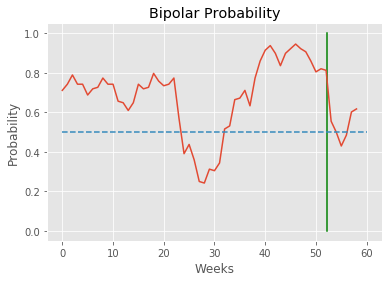

In [21]:
result = pol_report(bd_clean[4])
y = [window_info['bipolar_probability'] for window_info in result]
diagnosed_week = (patient_month_time_dict[bd_clean[4]['name'][0]] - bd_clean[4].index[0]).days / 7.0
plt.plot((diagnosed_week, diagnosed_week), (0.0, 1.0), 'g-')
plt.plot(y)
plt.plot((0, 60), (0.5, 0.5), '--')
plt.xlabel('Weeks')
plt.ylabel('Probability')
plt.title("Bipolar Probability")

plt.legend(loc="lower right")

plt.show()

0
NiallBunny
2016-06-20 00:00:00
2016-05-28 03:30:04
2016-09-19 09:06:48


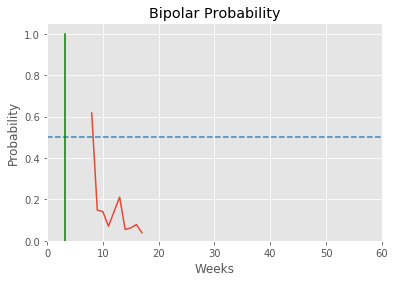

1
zozo_ed
2016-02-01 00:00:00
2015-01-31 18:39:27
2016-05-01 14:00:15


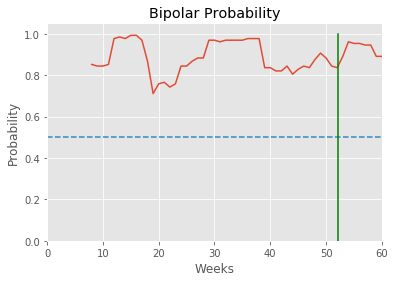

2
yobitchmiranda
2016-12-09 00:00:00
2015-12-08 21:36:43
2017-02-06 03:02:54


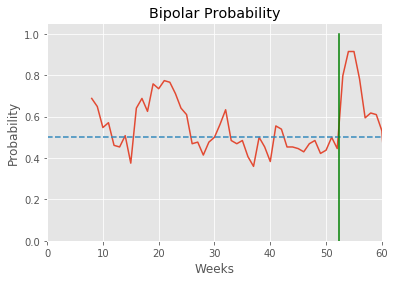

3
_raspberries
2016-03-04 00:00:00
2015-05-22 01:01:11
2016-06-04 05:27:04


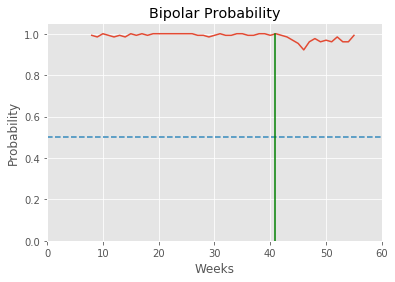

4
sanchezpaige
2013-06-19 00:00:00
2012-06-18 18:42:23
2013-09-19 15:31:05


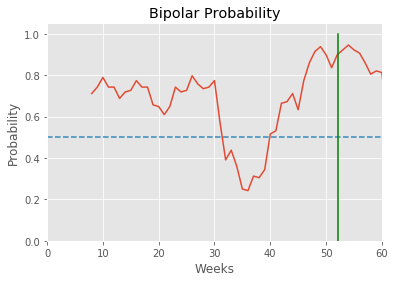

5
C_Leex3
2014-09-19 00:00:00
2014-09-29 06:05:58
2014-12-06 23:54:07


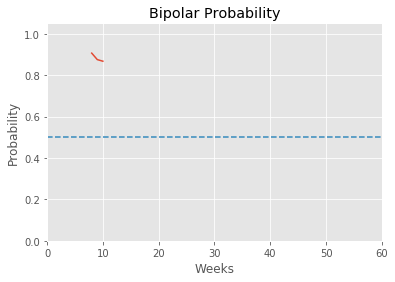

6
silencedrowns
2017-01-16 00:00:00
2016-01-15 19:16:26
2017-02-07 16:11:10


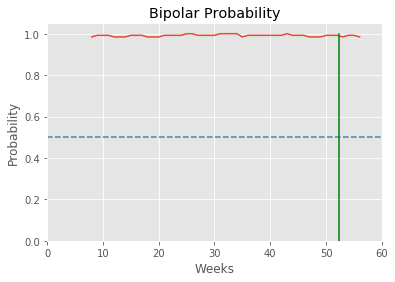

7
fmmshotme
2015-11-01 00:00:00
2015-12-09 07:43:45
2016-02-01 14:20:17


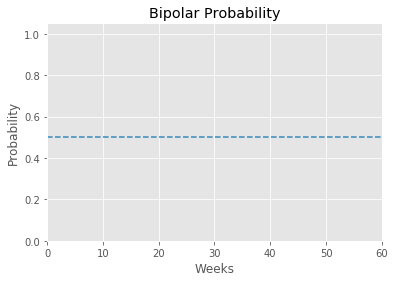

8
MUNTBABY
2014-02-13 00:00:00
2013-02-12 17:49:31
2014-05-13 15:46:41


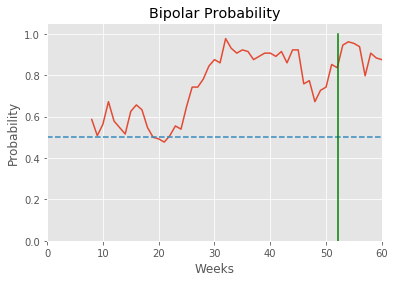

9
TommmMate
2017-01-22 00:00:00
2016-01-22 15:31:36
2017-02-03 17:40:56


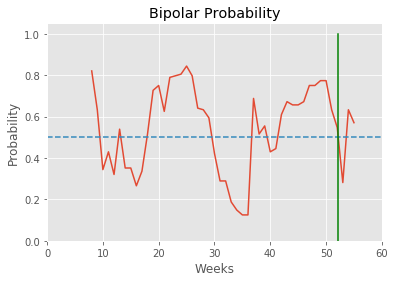

10
X_JuliiiiBabyyy
2015-07-09 00:00:00
2014-07-09 02:57:52
2015-10-09 06:03:58


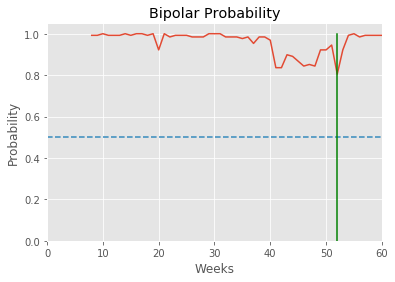

11
BreSwaGz
2016-06-01 00:00:00
2015-06-16 20:37:35
2016-09-01 14:11:39


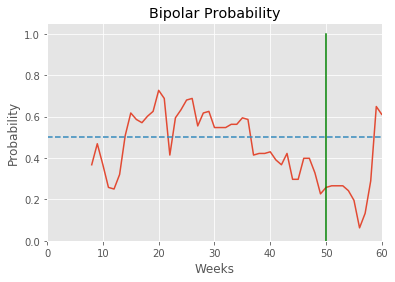

12
rozordie
2013-06-01 00:00:00
2012-05-31 16:00:43
2013-08-31 01:31:05


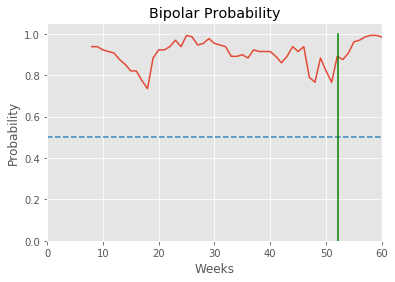

13
CEmmert25
2015-07-12 00:00:00
2014-11-08 05:11:31
2015-10-12 15:35:23


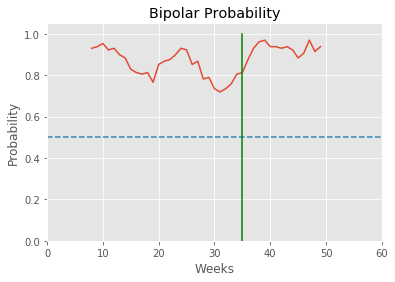

14
verybraveface
2013-12-10 00:00:00
2013-11-20 03:17:36
2014-03-10 15:57:13


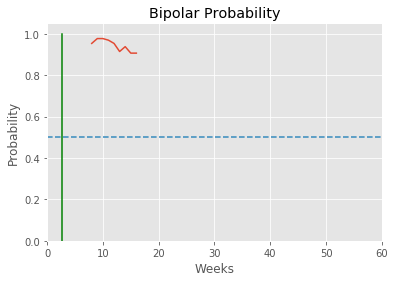

15
right2hell
2017-01-17 00:00:00
2016-12-30 07:54:35
2017-02-07 08:23:50


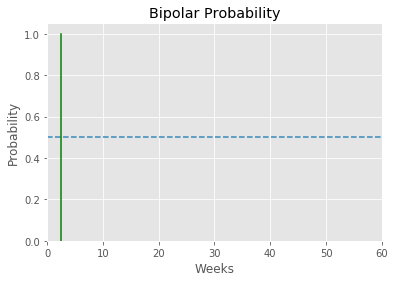

16
aleexturneer_
2014-01-01 00:00:00
2013-01-01 00:02:18
2014-04-01 14:49:39


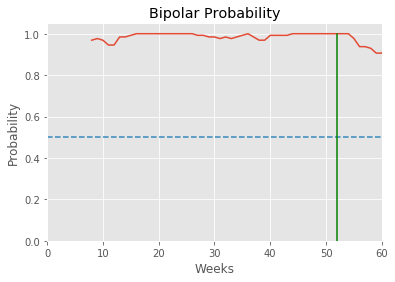

17
ElegantN7
2016-04-20 00:00:00
2015-04-20 07:31:02
2016-07-18 23:45:31
18
PennyCenturyXo
2014-01-28 00:00:00
2013-01-28 14:46:57
2014-04-27 20:28:59


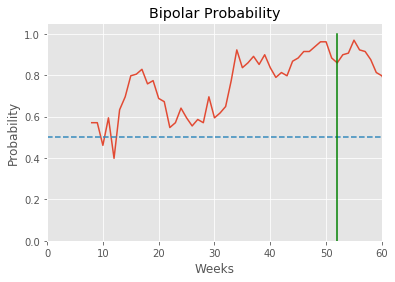

19
PlumBananas
2013-09-01 00:00:00
2012-09-04 14:47:36
2013-11-27 16:20:13


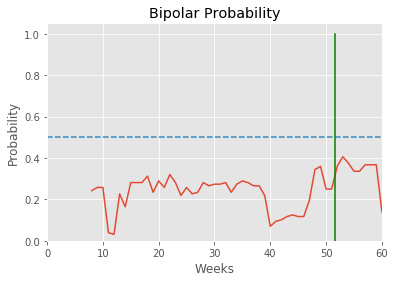

20
AwesomeAsh
2017-01-19 00:00:00
2016-01-22 06:18:02
2017-02-04 21:45:56


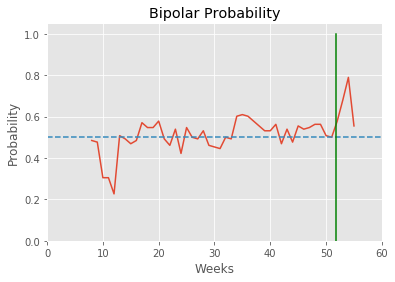

21
matthewRvincent
2017-01-21 00:00:00
2016-01-20 18:22:06
2017-02-05 18:41:37


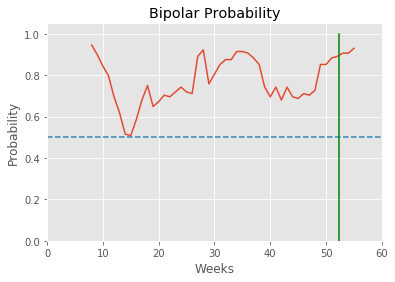

22
TionSavageee
2014-03-01 00:00:00
2013-02-28 17:03:26
2014-06-01 13:12:44


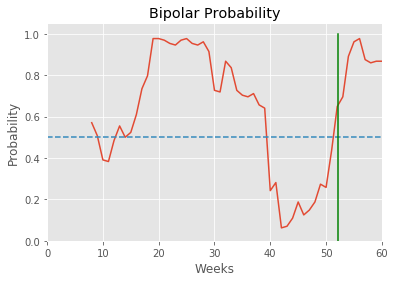

23
reportzoIo
2014-01-01 00:00:00
2013-01-01 00:09:14
2014-04-01 15:59:30


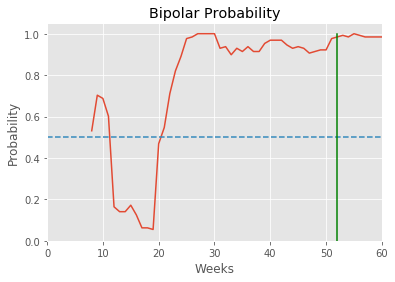

24
Erin_Louisee
2013-09-01 00:00:00
2012-08-31 20:12:29
2013-12-01 05:08:55


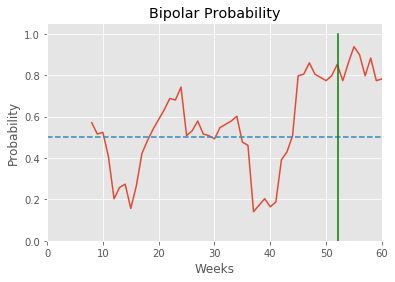

25
Jennys67
2014-02-06 00:00:00
2013-06-04 20:50:03
2014-05-04 03:47:21


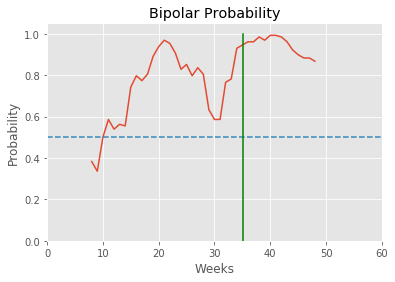

26
Vixoen
2013-06-01 00:00:00
2012-05-31 16:31:21
2013-09-01 07:28:50


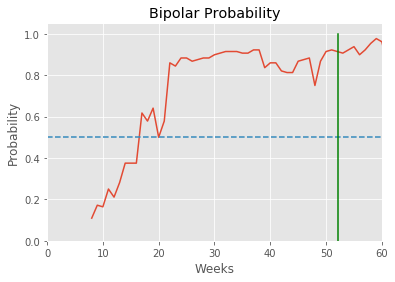

27
PunkRockHappy
2013-10-22 00:00:00
2012-10-23 23:55:05
2014-01-22 03:05:57


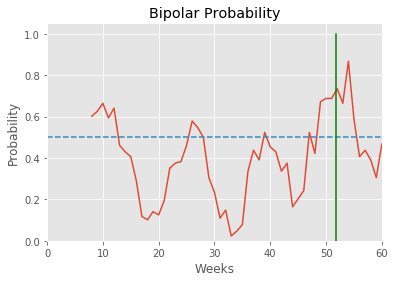

28
kakes_bakes
2012-09-01 00:00:00
2011-09-12 18:29:33
2012-11-21 02:07:38
29
complicatedcon
2017-01-11 00:00:00
2016-08-03 21:51:36
2017-02-06 06:58:50


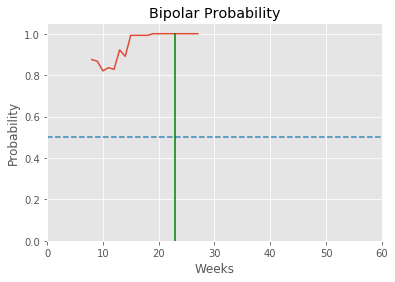

30
missmyerz9123
2015-12-18 00:00:00
2015-01-02 15:31:49
2016-03-17 15:44:27


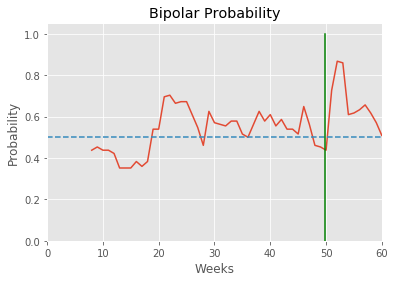

31
blue_moon_witch
2013-12-01 00:00:00
2014-01-21 18:14:28
2014-02-24 16:48:19


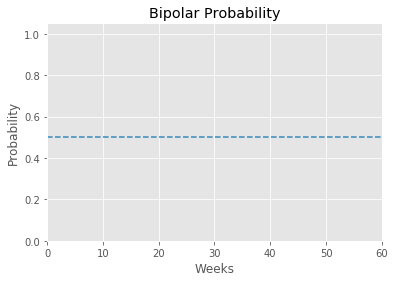

32
ValeourM
2013-09-01 00:00:00
2012-08-31 16:11:32
2013-12-01 08:06:27


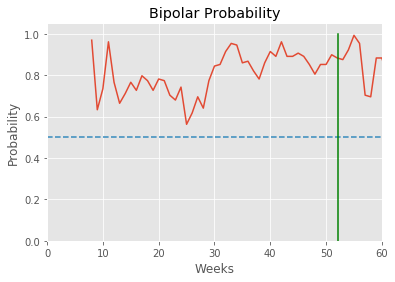

33
KashawnTaylor
2015-01-13 00:00:00
2014-01-12 17:06:45
2015-04-10 10:07:07


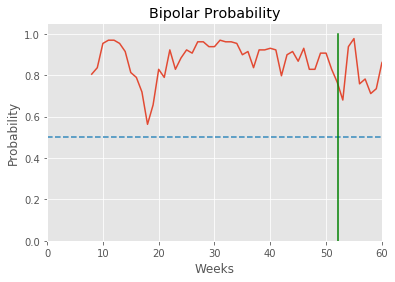

34
Ma7mood101
2014-06-19 00:00:00
2013-06-19 08:00:35
2014-09-17 12:10:16


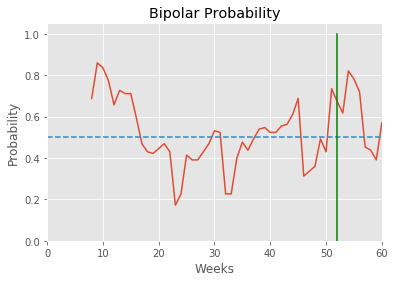

35
Boricua611
2015-08-01 00:00:00
2014-09-26 14:18:20
2015-11-01 03:18:12


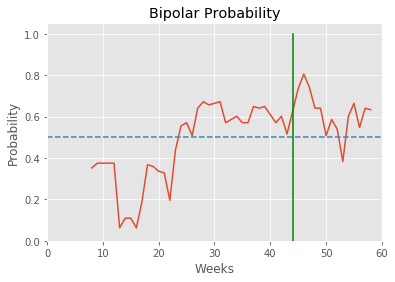

36
ddlovatoanangel
2013-09-17 00:00:00
2012-09-17 00:22:01
2013-12-16 09:03:58


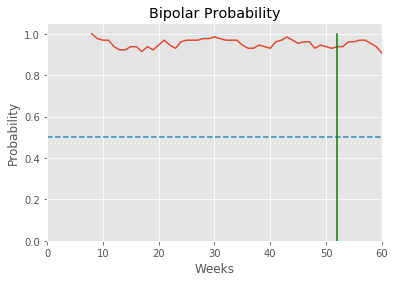

37
ChantyRomard
2016-10-16 00:00:00
2015-10-15 16:30:53
2016-12-22 13:26:24


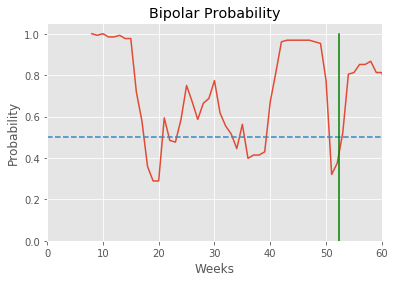

38
lil_miss_caf
2014-08-15 00:00:00
2013-08-14 16:00:57
2014-11-15 15:40:51


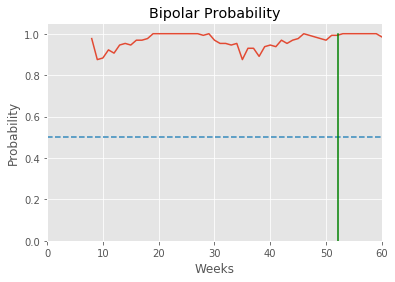

39
musicaIhoe
2016-01-27 00:00:00
2015-09-27 00:09:59
2016-04-22 05:49:48


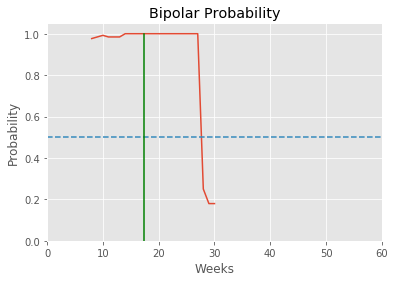

40
Scooby_Who
2012-10-01 00:00:00
2011-09-30 17:03:54
2013-01-01 15:42:54


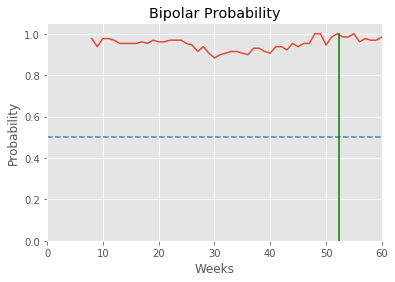

41
p_rapper
2013-02-01 00:00:00
2012-02-04 14:03:49
2013-04-04 06:50:39
42
dogcalledbambi
2014-06-18 00:00:00
2013-06-17 17:46:22
2014-09-17 22:04:14


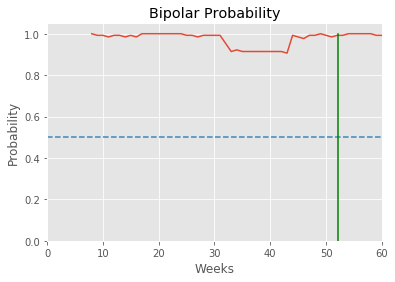

43
NeliaCarolyn
2013-11-14 00:00:00
2012-11-13 17:29:24
2014-02-14 15:46:17


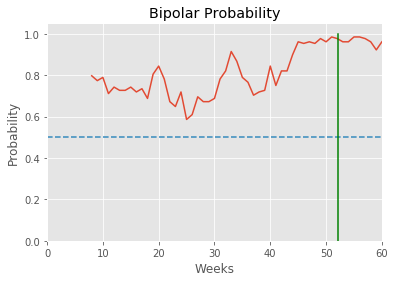

44
coolfamilyblog
2015-08-26 00:00:00
2014-08-27 03:34:51
2015-11-23 03:13:18


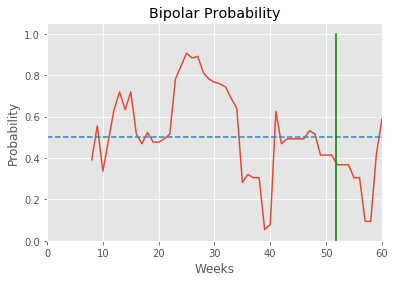

45
darrenleewelsh
2015-02-08 00:00:00
2014-05-11 03:43:56
2015-04-16 13:10:58
46
musicandincense
2014-12-04 00:00:00
2014-10-10 04:59:18
2015-02-16 13:31:35


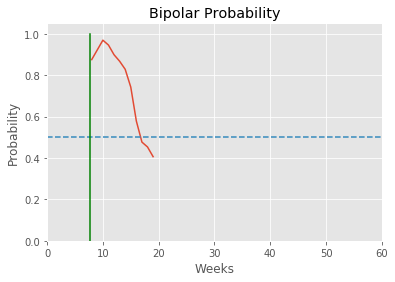

47
kawaiicutforth
2014-09-25 00:00:00
2014-08-05 01:35:17
2014-12-25 15:38:57


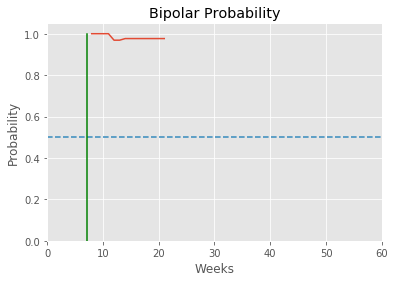

48
obliviousm3
2014-10-01 00:00:00
2014-06-16 19:18:12
2015-01-01 00:49:55


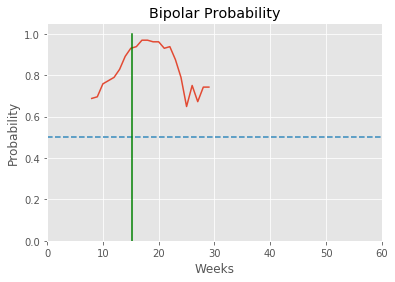

49
Lesh_taboo
2016-08-02 00:00:00
2015-08-01 23:23:27
2016-11-02 10:00:56


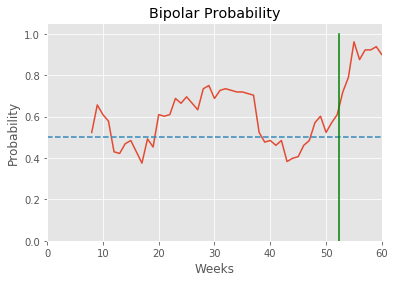

50
chucho109031995
2015-09-01 00:00:00
2015-05-04 03:21:27
2015-07-27 23:52:06


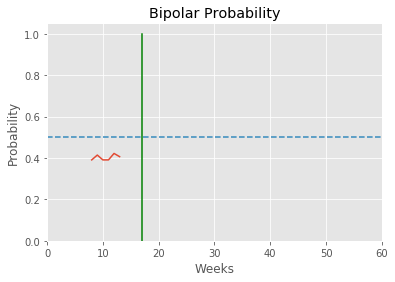

51
GeraintWaddon
2014-07-04 00:00:00
2013-07-04 06:50:17
2014-10-04 05:15:25


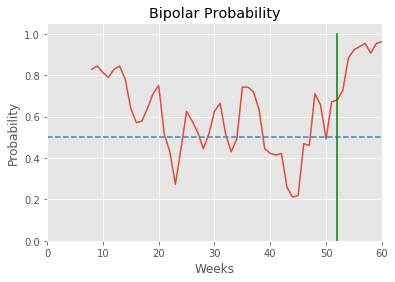

52
SammyFucknFenty
2015-04-01 00:00:00
2014-04-01 15:34:28
2015-07-01 14:48:13


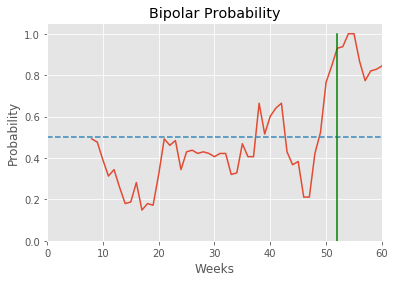

53
f0reverliving
2017-01-19 00:00:00
2016-01-20 17:27:04
2017-02-06 12:02:23


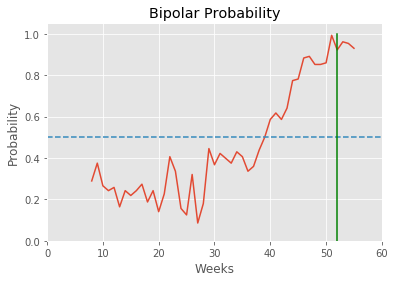

54
TheBornDreamer
2013-06-01 00:00:00
2012-06-01 23:53:11
2013-09-01 13:15:24


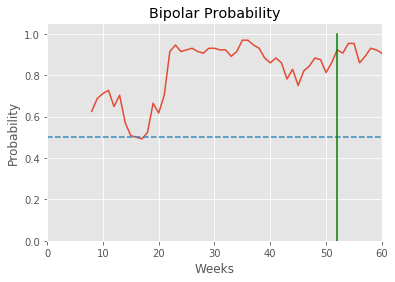

55
DatShitKrae
2015-11-13 00:00:00
2015-03-05 17:08:40
2016-02-12 16:06:36


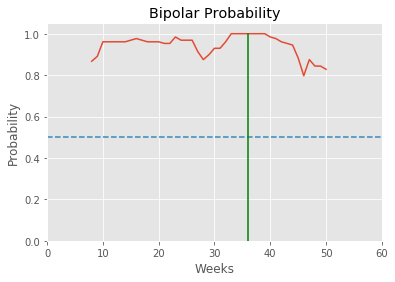

56
delaney_ashlyn
2014-06-20 00:00:00
2013-07-01 16:07:05
2014-09-20 12:58:22


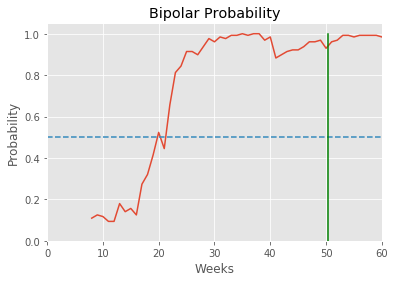

57
BossHossMOB
2016-08-03 00:00:00
2016-07-17 02:17:56
2016-11-03 14:41:01


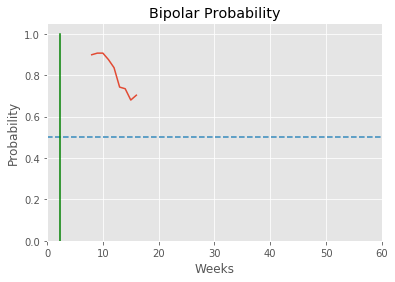

58
KARLXCARL
2015-03-01 00:00:00
2014-02-28 16:38:30
2015-06-01 15:10:40


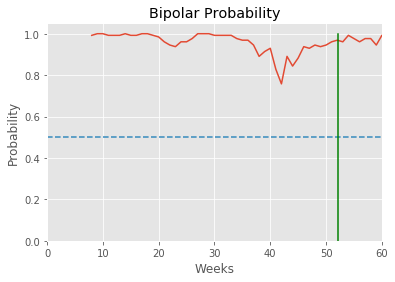

59
CassandraBurns7
2013-01-01 00:00:00
2012-09-27 19:36:41
2013-04-01 15:31:25


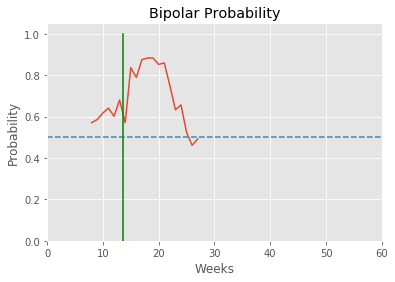

60
ArtistSomeday
2014-01-01 00:00:00
2013-01-20 01:58:26
2013-07-30 04:48:58
61
day0ldhat3
2015-04-07 00:00:00
2014-04-07 02:45:15
2015-07-07 09:49:19


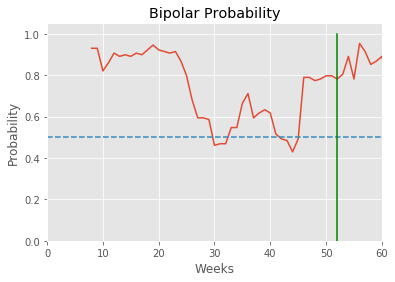

62
CMBogan
2016-02-18 00:00:00
2015-02-17 18:36:28
2016-05-08 19:23:23


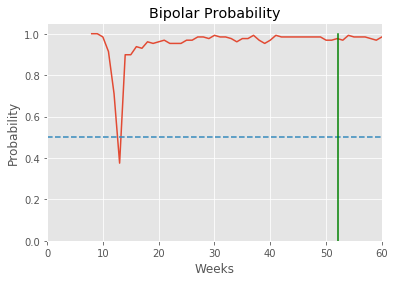

63
Radica_XO_Khidd
2014-11-13 00:00:00
2013-11-15 17:24:10
2015-02-11 19:53:25


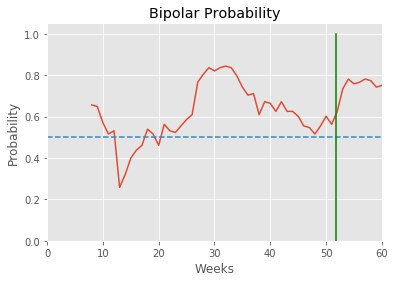

64
graham_bryan
2013-12-01 00:00:00
2013-04-13 16:49:40
2013-08-10 11:00:13
65
Dream_Star_
2013-04-01 00:00:00
2012-03-31 20:52:40
2013-07-01 12:09:59


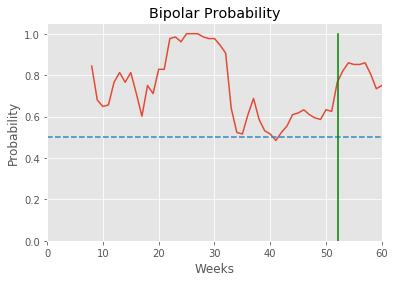

66
oldpaths_pub
2016-07-01 00:00:00
2016-04-10 16:13:01
2016-07-08 14:17:28


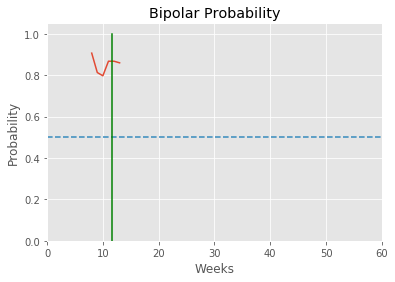

67
kuwabaras_
2016-10-25 00:00:00
2015-10-24 16:00:07
2016-12-29 03:51:37


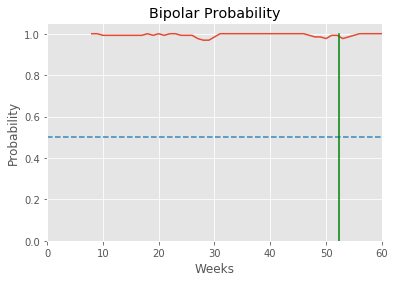

68
ninsnoopy
2014-08-15 00:00:00
2014-06-20 06:17:44
2014-11-15 06:06:43


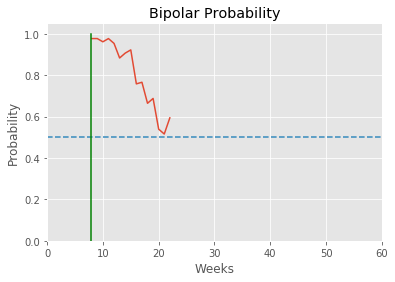

69
laurjbrown
2014-11-15 00:00:00
2013-12-09 05:29:02
2015-02-15 15:45:25


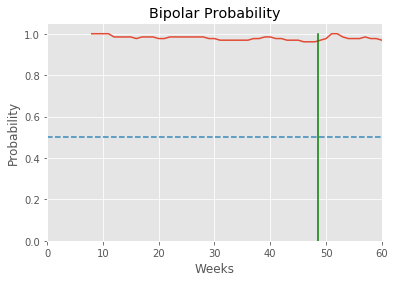

70
sammiethenami
2013-02-01 00:00:00
2012-08-28 12:29:58
2013-03-12 06:42:55
71
TylerCSmith815
2015-09-30 00:00:00
2014-10-30 15:28:48
2015-12-07 13:21:41
72
ceceliaa_
2013-08-01 00:00:00
2012-07-31 16:30:27
2013-10-14 07:12:06


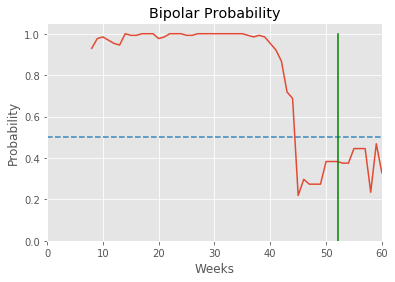

73
rosekelleher4
2016-01-27 00:00:00
2015-01-26 17:25:07
2016-04-27 01:16:25


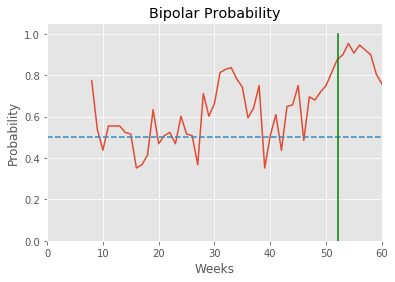

74
HeyThereJohana
2014-10-17 00:00:00
2013-10-17 01:24:22
2015-01-17 13:11:11


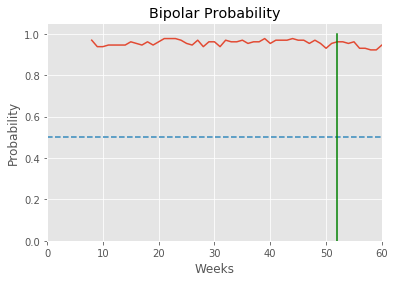

75
inaseaofemotion
2017-01-08 00:00:00
2016-09-14 19:42:05
2017-02-05 04:39:09


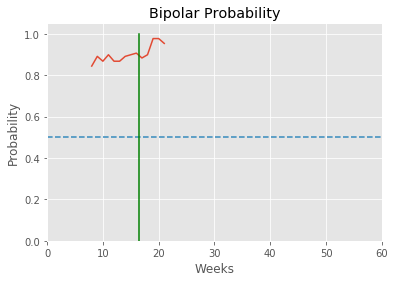

76
ActualJoykiller
2013-01-19 00:00:00
2012-01-19 23:10:11
2013-04-19 06:32:10


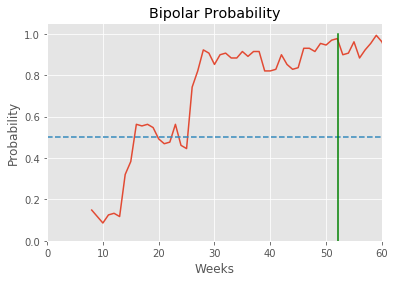

77
4lilpretentious
2017-01-12 00:00:00
2016-03-30 00:23:18
2017-02-07 22:26:24


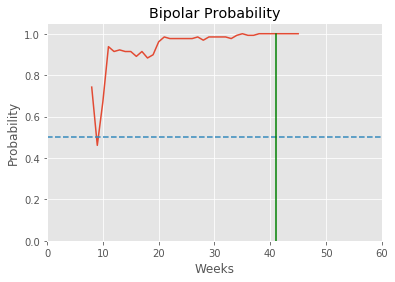

78
jgquinton
2013-10-03 00:00:00
2012-10-02 17:19:32
2014-01-03 06:01:29


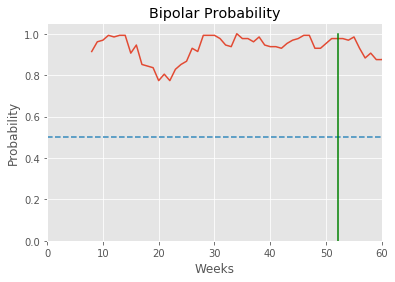

79
JonnyZombi
2016-03-07 00:00:00
2015-03-06 16:26:13
2016-06-07 03:11:19


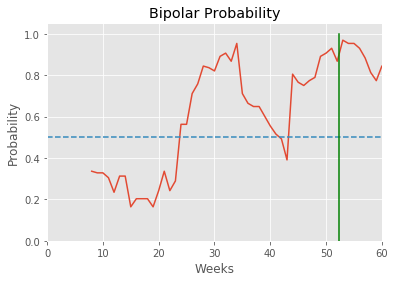

80
waxchinadoll
2015-07-01 00:00:00
2014-07-16 00:44:25
2015-10-01 01:27:32


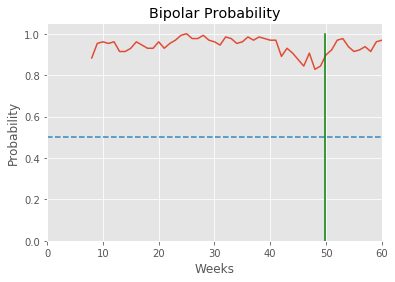

81
Karen_e_miller
2015-05-07 00:00:00
2014-05-06 23:08:31
2015-08-07 04:26:29


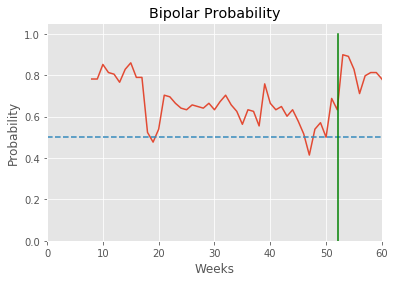

82
_KatKennedy
2014-03-01 00:00:00
2013-02-28 16:06:30
2014-06-01 04:40:21


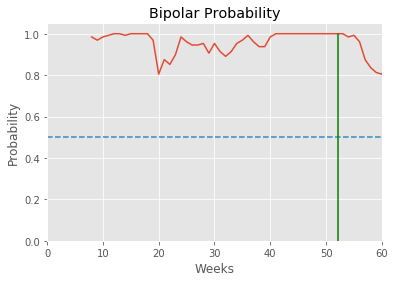

83
jamieboiss
2012-10-01 00:00:00
2011-10-11 21:55:51
2012-12-30 22:05:05


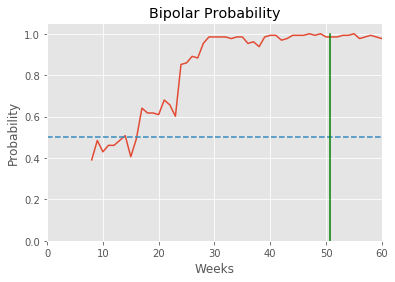

84
LithChronicles
2012-10-01 00:00:00
2012-04-02 20:35:53
2012-05-26 01:02:56


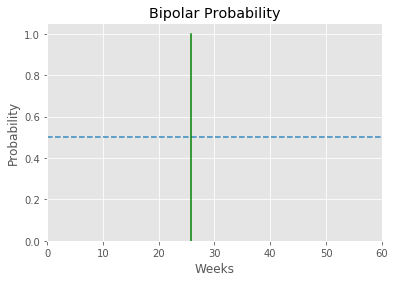

85
Popatrace_OrNah
2014-06-25 00:00:00
2013-06-25 06:33:52
2014-09-25 07:05:57


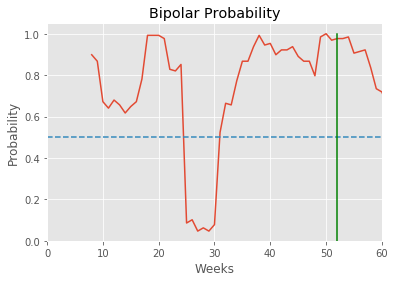

86
colinfarrelfan
2017-01-18 00:00:00
2016-01-18 04:57:11
2017-02-07 09:10:51


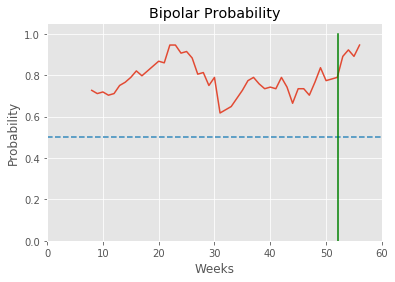

87
kristacathleen1
2015-06-01 00:00:00
2014-09-24 11:42:16
2015-08-04 01:58:01


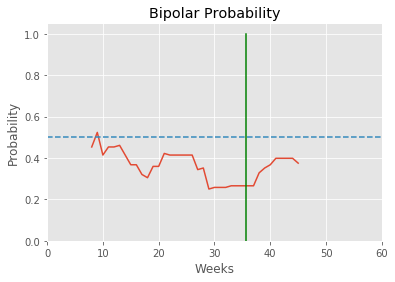

88
mcdoneugh
2015-07-20 00:00:00
2014-07-19 16:08:39
2015-10-17 16:33:03


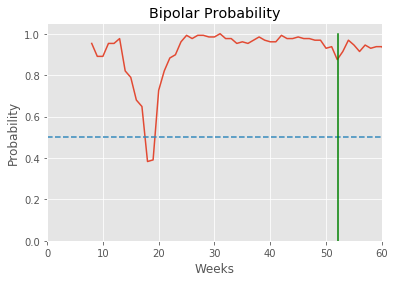

89
PinkBerryShake
2013-03-01 00:00:00
2012-02-29 17:36:52
2012-12-20 07:59:14


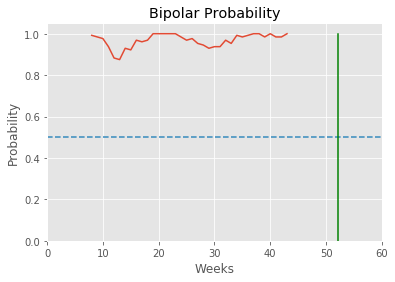

90
dave_ghost
2015-04-11 00:00:00
2014-05-28 00:52:08
2015-07-11 07:15:14


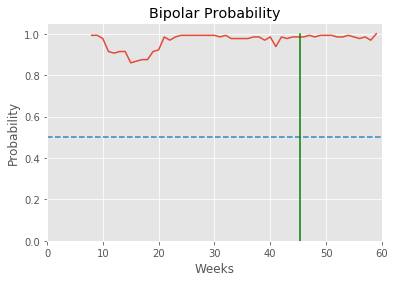

91
KissMyVibe
2013-08-01 00:00:00
2013-07-29 01:58:44
2013-10-26 01:48:14


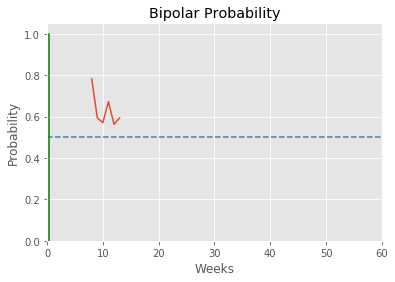

92
TammiJ1973
2012-09-11 00:00:00
2012-10-07 12:50:43
2012-12-11 15:44:06


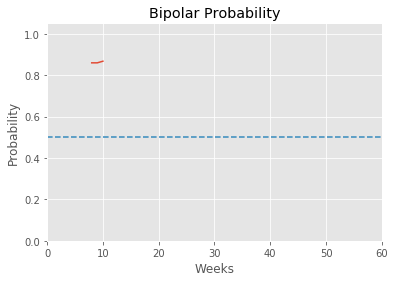

93
celineherbez
2012-02-01 00:00:00
2011-09-04 02:24:04
2012-05-01 10:44:37


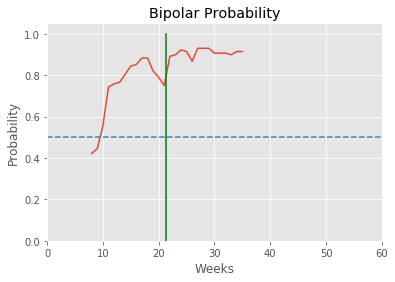

94
GingeKnievil
2014-12-02 00:00:00
2013-12-01 17:14:48
2015-03-02 15:23:42


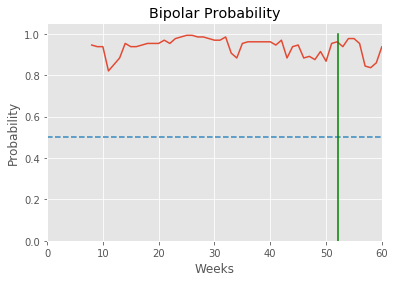

95
fadeaway94
2016-03-01 00:00:00
2015-10-25 15:12:25
2016-03-12 16:13:45
96
killingmyselfpl
2015-01-18 00:00:00
2014-08-04 06:27:04
2015-04-17 06:34:17


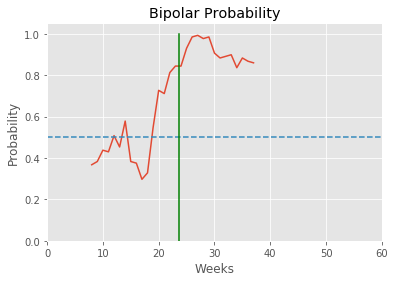

97
Alc43my
2016-11-09 00:00:00
2015-11-24 05:09:05
2016-12-27 21:51:16
98
io_superare
2015-11-01 00:00:00
2015-12-30 19:11:09
2016-01-29 05:25:20


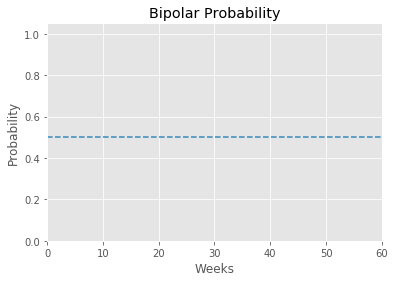

99
AndrewHoughton8
2013-12-20 00:00:00
2013-01-06 07:19:00
2014-03-18 18:12:13


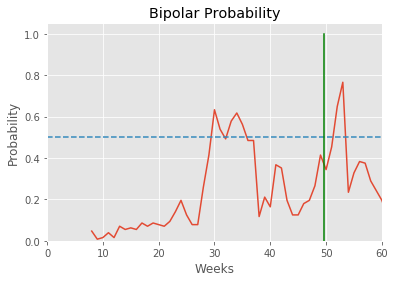

100
Cat_Fowl
2013-03-01 00:00:00
2012-02-29 23:47:52
2013-05-31 23:08:04


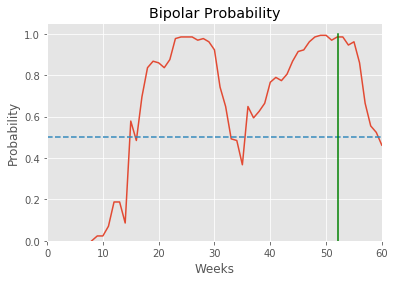

101
Demetria_Wife
2014-06-21 00:00:00
2013-06-20 16:21:34
2014-09-21 13:05:12


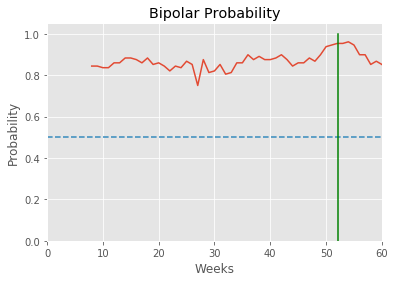

102
SassyPharmD
2014-11-10 00:00:00
2013-11-12 07:30:03
2015-02-10 13:54:59


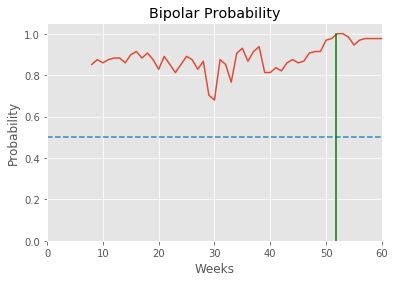

103
LostKaiyna
2014-12-01 00:00:00
2013-11-30 16:53:25
2015-02-27 19:59:28


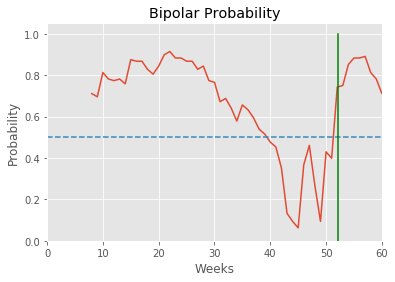

104
ashliewaters
2015-09-19 00:00:00
2014-09-21 07:35:40
2015-12-17 06:42:58


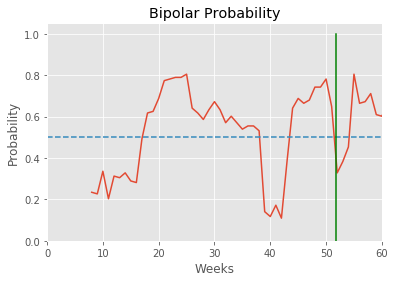

105
jxlsia
2012-08-04 00:00:00
2011-08-23 08:00:38
2012-11-04 13:50:38


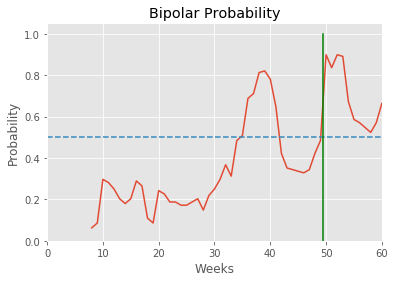

106
Anak_Bijak
2013-02-05 00:00:00
2012-05-26 18:58:29
2013-05-05 15:11:39


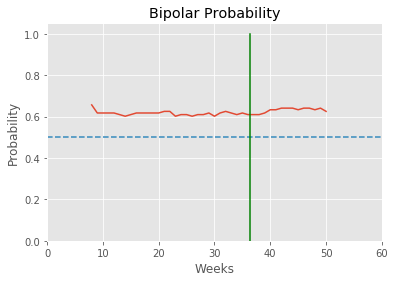

107
ghostofclifford
2016-05-15 00:00:00
2015-09-09 09:21:24
2016-08-15 14:30:25


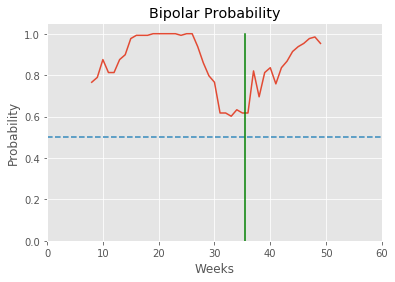

108
philomathspirit
2016-05-25 00:00:00
2015-05-24 17:38:25
2016-08-25 02:29:24


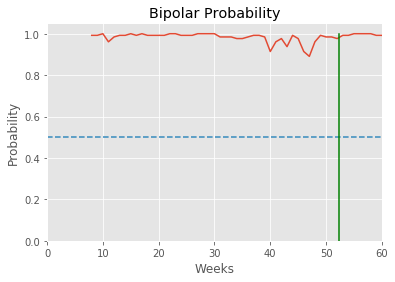

109
rorysxlogan
2015-04-02 00:00:00
2014-04-02 04:01:09
2015-07-02 06:08:25


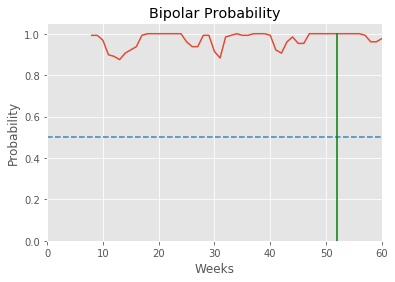

110
b_bylynn
2012-12-01 00:00:00
2012-10-01 19:59:43
2013-02-28 22:16:18


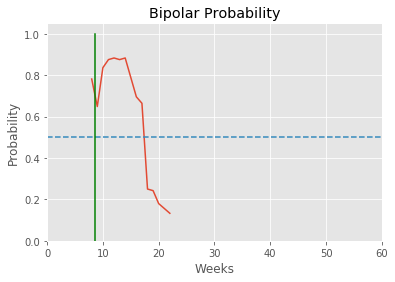

111
Ritz_Tweeting
2014-11-01 00:00:00
2013-10-31 16:48:16
2015-02-01 09:19:55


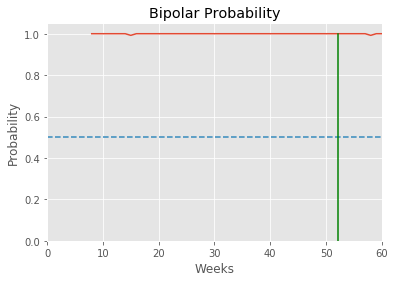

112
CourtneyDePatz
2016-11-11 00:00:00
2015-12-27 21:43:33
2016-12-28 06:09:00


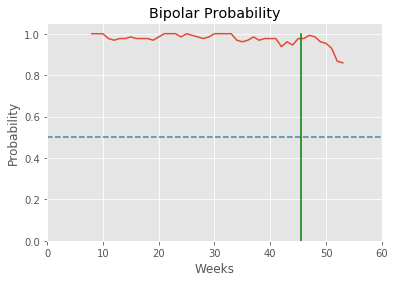

113
k3lvy_
2015-03-01 00:00:00
2014-02-28 20:39:05
2015-06-01 13:53:46


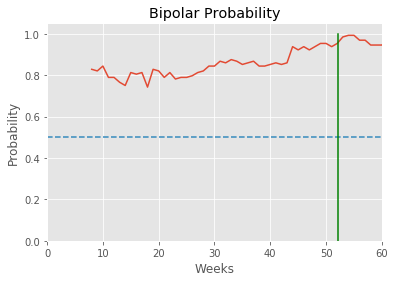

114
Leah_Pupzz
2014-10-01 00:00:00
2014-06-24 09:08:11
2015-01-01 08:54:59


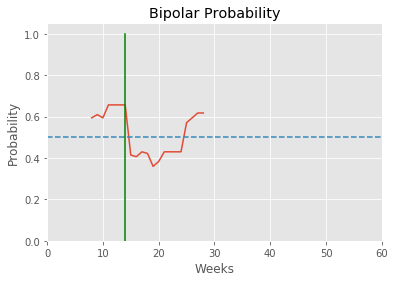

115
Beardy_Mc_Beard
2014-10-20 00:00:00
2013-10-21 04:48:07
2015-01-20 15:49:37
116
matea_friend
2014-04-07 00:00:00
2013-04-06 23:49:52
2014-07-06 09:42:20


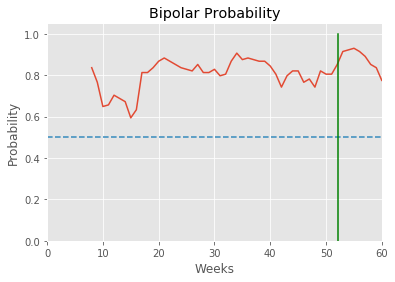

117
dcgerald
2013-07-20 00:00:00
2013-07-24 00:59:31
2013-09-17 08:55:29


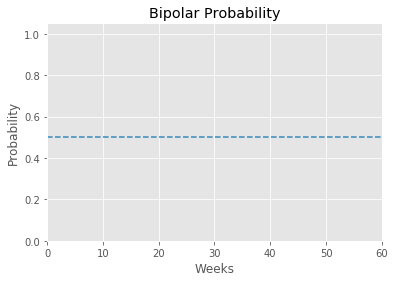

118
josephcott
2015-12-04 00:00:00
2014-12-03 16:11:25
2016-03-04 02:09:42


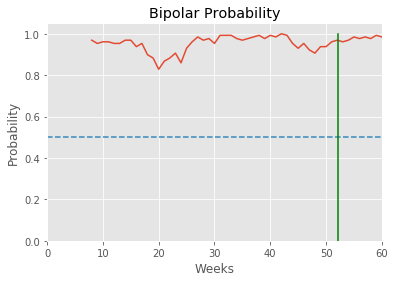

119
BaumG76
2016-05-12 00:00:00
2016-03-08 23:31:43
2016-08-04 11:15:26


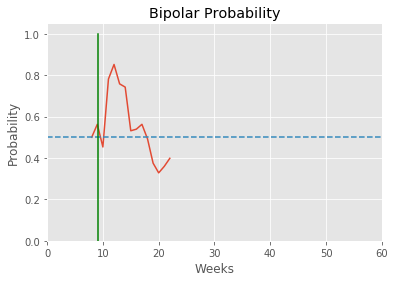

120
nidhighe
2013-05-29 00:00:00
2012-05-28 22:47:48
2013-08-29 09:07:21


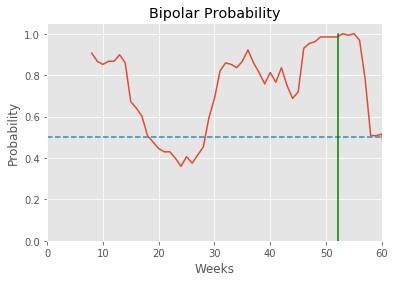

121
yohaw
2013-05-18 00:00:00
2012-05-01 00:33:39
2013-08-01 14:56:09


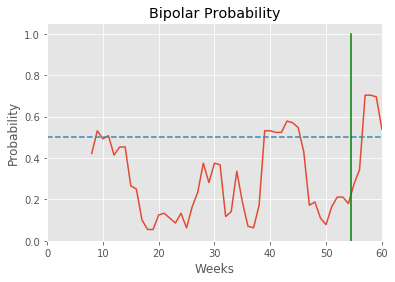

122
Luucekay
2017-01-16 00:00:00
2016-01-16 23:34:20
2017-02-06 18:41:38


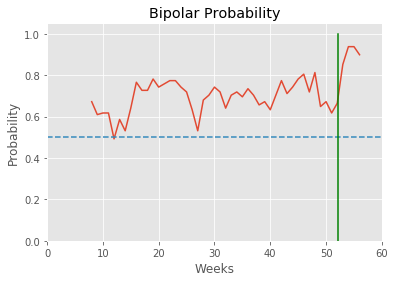

123
DeeJane7
2015-05-01 00:00:00
2014-05-05 23:45:28
2015-07-28 20:06:28


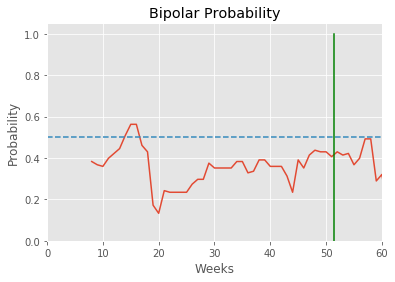

124
benjohnsick
2016-05-05 00:00:00
2015-05-07 15:35:49
2016-08-04 20:20:13


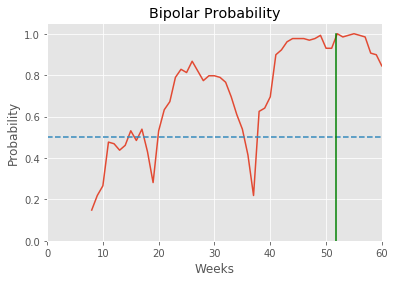

125
ObiWanChloe
2014-07-15 00:00:00
2013-07-15 02:18:09
2014-10-05 20:26:35


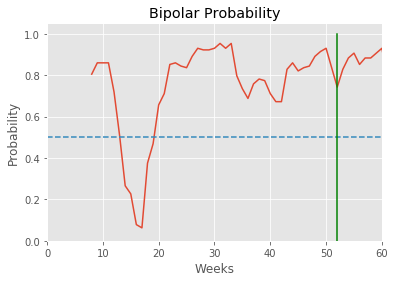

126
Empromancy
2015-01-01 00:00:00
2014-03-02 23:46:30
2015-01-15 18:47:06
127
lexeme
2015-06-12 00:00:00
2014-06-11 18:01:39
2015-09-12 14:11:47


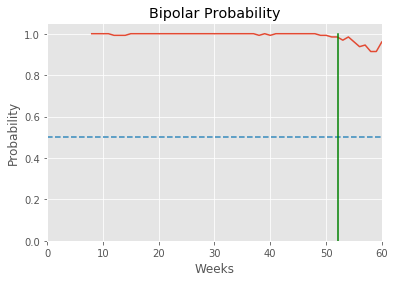

128
CamWillReadu
2015-05-25 00:00:00
2014-05-24 16:17:09
2015-08-25 15:33:42


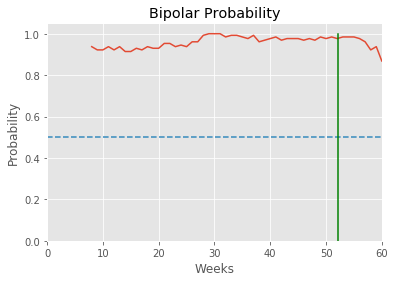

129
mikayla_radich
2014-01-01 00:00:00
2012-12-31 23:45:27
2014-04-01 05:07:28


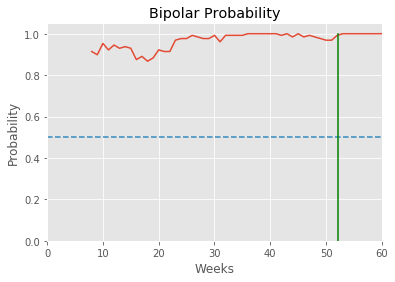

130
easytide
2014-03-21 00:00:00
2013-03-20 17:51:15
2014-06-21 15:47:29


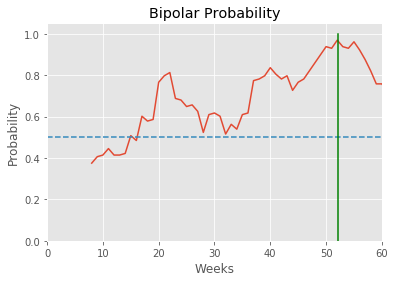

131
TIGN3Y
2016-11-08 00:00:00
2016-08-06 23:08:10
2016-12-29 00:10:03


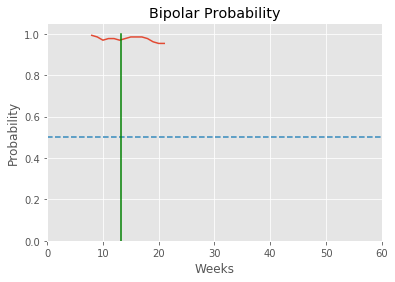

132
bunnyelephant
2016-12-01 00:00:00
2016-06-01 01:08:19
2017-02-06 10:45:06


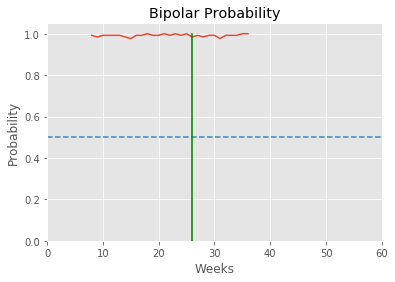

133
jimmypiper2
2013-11-19 00:00:00
2013-02-21 03:34:38
2014-02-19 10:38:42


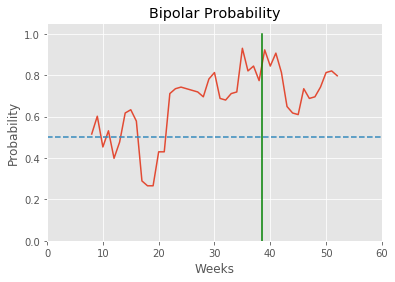

134
FinallyBipolar
2014-04-09 00:00:00
2014-04-24 20:37:17
2014-07-08 21:12:58


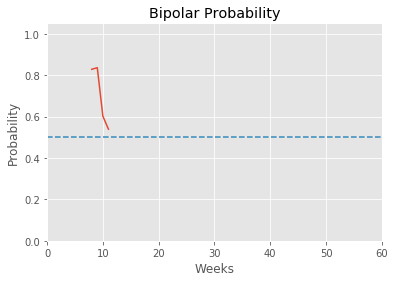

135
girlwtheblade
2012-12-01 00:00:00
2011-12-23 08:38:56
2013-02-24 05:10:17
136
nostaIgicmoons
2013-07-01 00:00:00
2013-04-21 15:36:01
2013-10-01 15:37:58


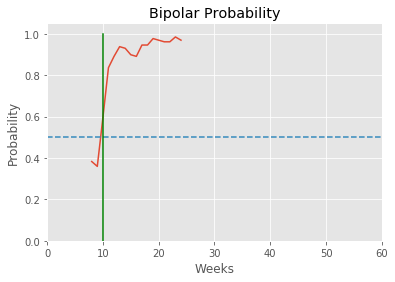

137
kierstingale
2014-01-01 00:00:00
2013-01-01 20:10:10
2014-04-01 02:55:23


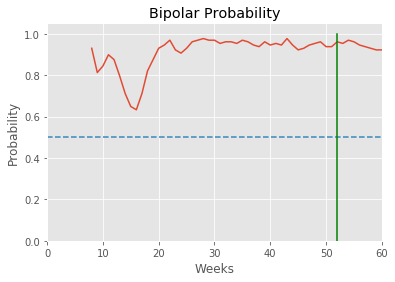

138
Nattyneou
2014-07-06 00:00:00
2013-07-06 16:22:34
2014-10-05 14:54:08


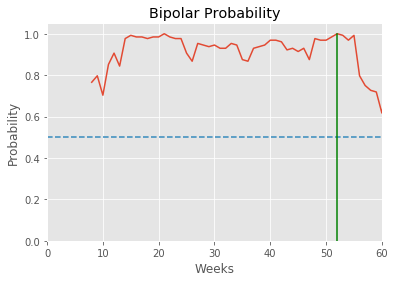

139
_weewee
2015-10-01 00:00:00
2014-09-30 23:56:54
2015-12-06 02:11:54


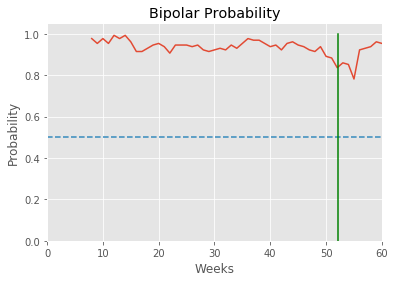

140
creeptrash
2014-11-01 00:00:00
2013-10-31 17:23:00
2015-02-01 10:06:00


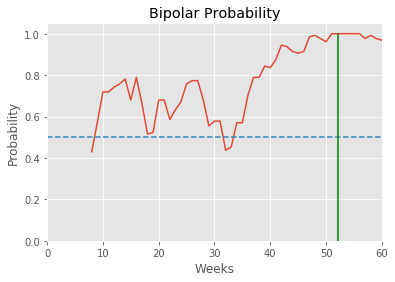

141
AshesAndSnow713
2015-01-15 00:00:00
2014-06-02 15:50:35
2015-04-06 15:14:02


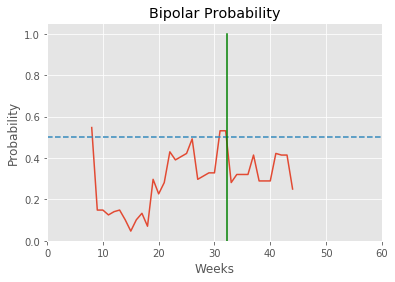

142
bromopoet
2015-07-01 00:00:00
2015-05-21 06:52:21
2015-09-05 05:35:07


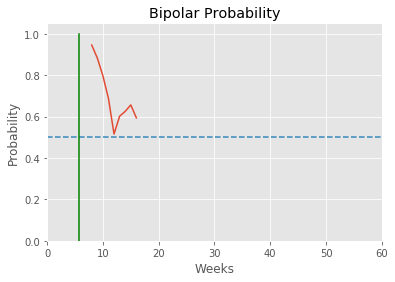

143
_rachelsarahxo
2016-11-15 00:00:00
2015-12-23 11:07:12
2017-02-06 13:56:19
144
edlukethird
2014-04-01 00:00:00
2013-04-03 21:11:31
2013-10-30 23:31:48


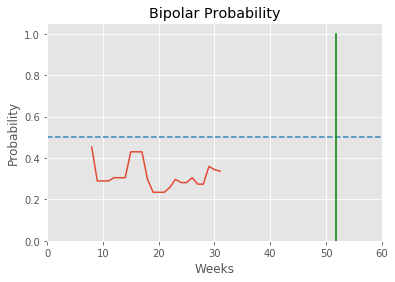

145
sbaestianstan
2015-09-01 00:00:00
2015-08-17 07:49:35
2015-12-01 15:46:43


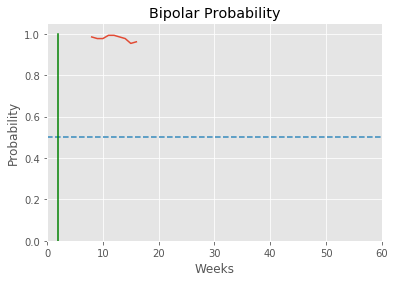

146
DemiLovatic5H
2016-04-08 00:00:00
2015-04-10 19:25:34
2016-07-02 14:30:16


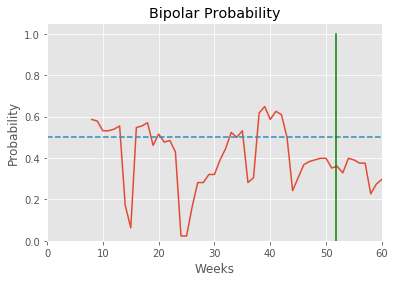

147
BattyBrilliance
2015-11-01 00:00:00
2015-09-07 12:56:15
2016-02-01 13:39:26


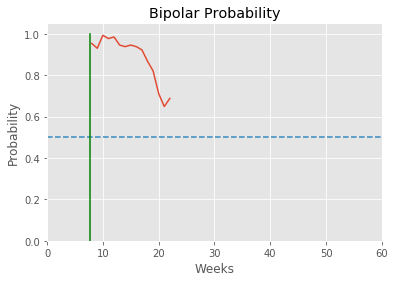

148
clyder1966
2013-10-01 00:00:00
2013-08-20 00:08:53
2013-12-22 23:38:39


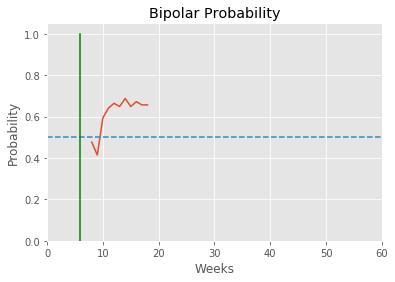

149
LochnessaMarie
2015-01-27 00:00:00
2014-01-31 05:47:14
2015-04-27 15:24:42


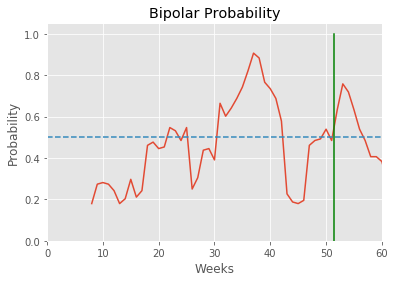

150
shiku___
2016-03-01 00:00:00
2015-03-11 02:58:41
2016-06-01 11:31:56


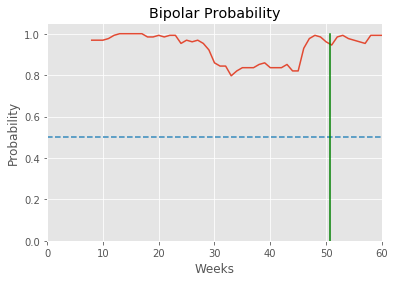

151
_FunSize_QT
2013-04-07 00:00:00
2012-04-06 17:58:20
2013-07-06 18:28:22


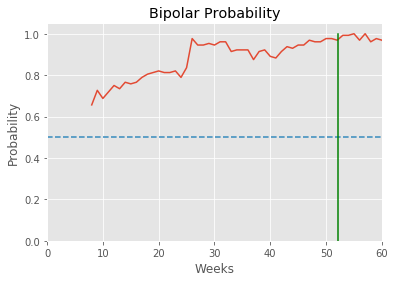

152
StephGambini
2014-04-03 00:00:00
2013-05-21 22:16:50
2014-07-03 05:45:30
153
JillianKarger
2013-08-01 00:00:00
2012-08-02 10:57:59
2013-10-13 12:56:26


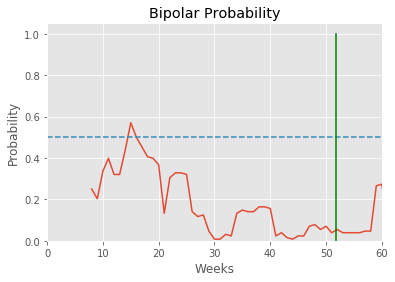

154
snowstormokami
2016-06-30 00:00:00
2016-06-24 03:01:38
2016-09-30 15:33:56


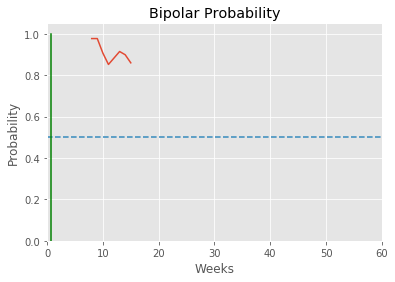

155
cuts4ndsc4rs
2013-04-26 00:00:00
2013-03-11 22:53:47
2013-05-27 19:26:20


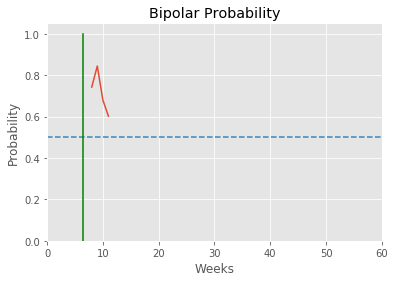

156
TWallaceMusic
2016-01-01 00:00:00
2015-01-25 10:01:21
2016-03-31 20:46:38


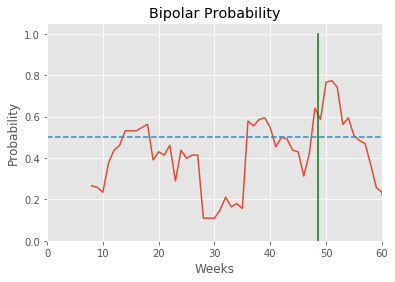

157
whippie3675
2016-01-22 00:00:00
2015-01-23 05:52:40
2016-04-19 15:38:33
158
CelticKaty88
2016-08-01 00:00:00
2015-08-01 01:01:55
2016-11-01 15:50:27


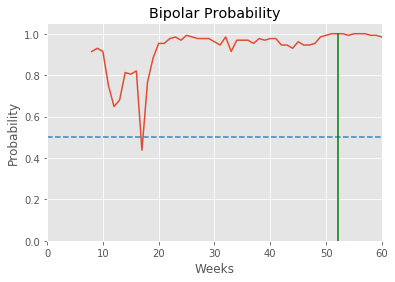

159
YangMummy
2013-01-01 00:00:00
2012-02-05 23:02:15
2013-04-01 11:27:43
160
razorblxde
2013-08-25 00:00:00
2013-01-26 18:26:32
2013-11-24 18:07:41


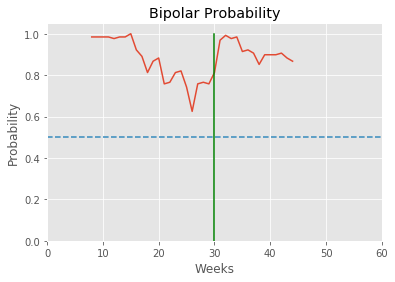

161
eds_shirtsleeve
2013-08-28 00:00:00
2012-08-27 16:02:50
2013-11-28 14:46:03


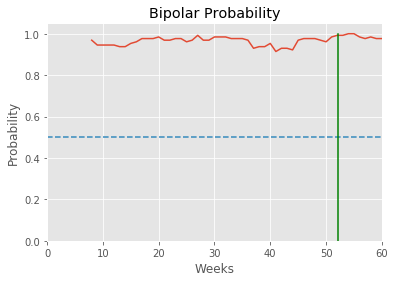

162
ganjasaurusr3x
2013-04-25 00:00:00
2013-03-04 02:58:04
2013-07-25 15:37:36


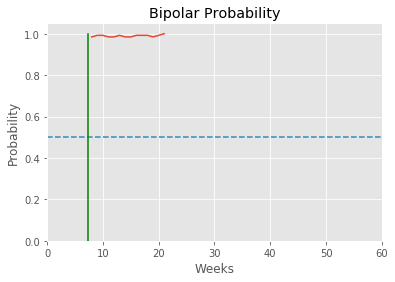

163
horrorvoid
2016-09-10 00:00:00
2015-09-10 19:09:37
2016-12-09 00:09:03


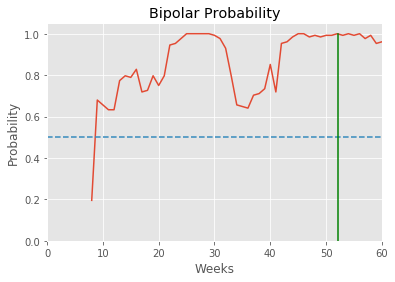

164
allagrugous
2015-06-18 00:00:00
2014-07-18 23:17:04
2015-09-18 15:13:37
165
MeridianRehab
2016-07-06 00:00:00
2015-10-09 21:00:00
2016-10-06 13:30:55


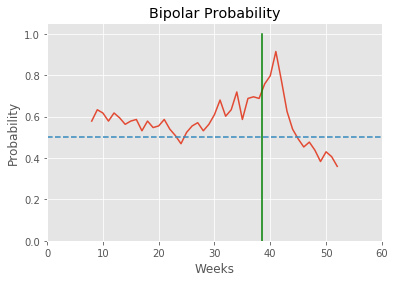

166
Oello12
2013-03-01 00:00:00
2012-03-01 06:38:33
2013-06-01 08:37:00


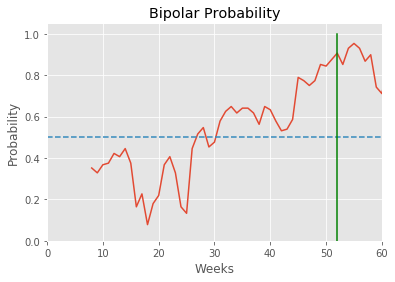

167
enjoyscarlett_
2015-04-03 00:00:00
2014-04-02 16:29:29
2015-07-03 15:28:04


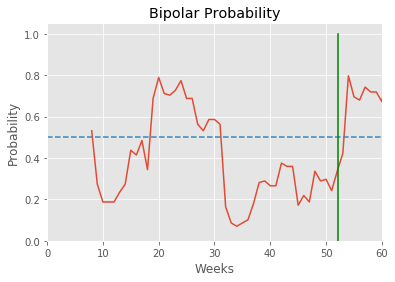

168
recoveryspirit
2014-05-08 00:00:00
2013-05-07 16:00:17
2014-08-08 15:59:07


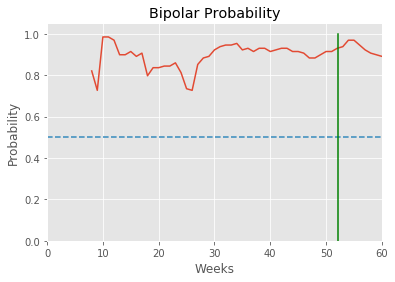

169
mattstreuli
2015-05-22 00:00:00
2014-05-21 18:02:40
2015-08-22 14:05:22


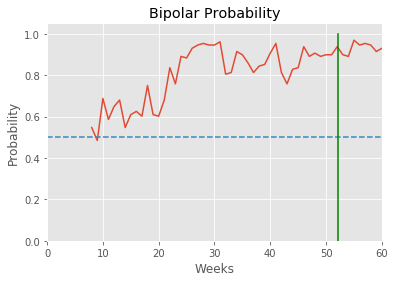

170
TinyLittleChen
2014-10-20 00:00:00
2013-10-19 16:02:43
2015-01-20 10:09:44


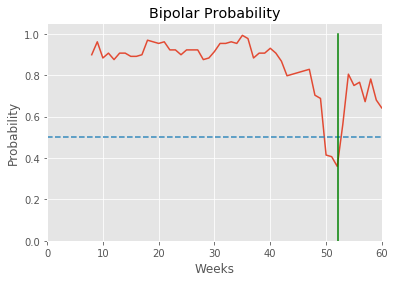

171
Lesism
2014-09-01 00:00:00
2013-08-31 16:04:46
2014-12-01 12:57:00


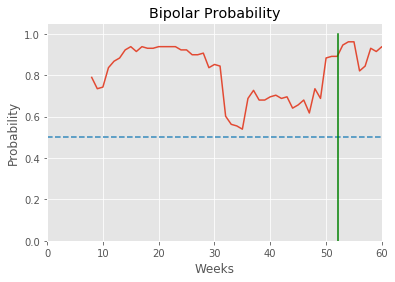

172
TheInsaneIdol
2014-03-01 00:00:00
2013-03-14 21:26:41
2014-05-31 14:36:30


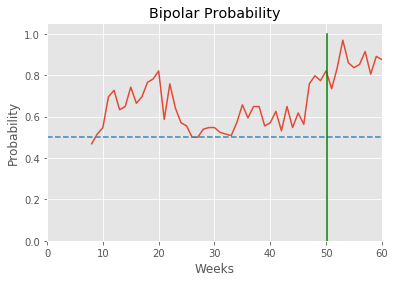

173
Megrrrs
2015-12-09 00:00:00
2014-12-08 16:09:42
2016-03-08 18:01:46


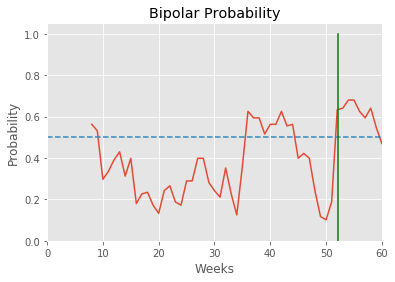

174
_kenziiieee_
2016-03-04 00:00:00
2015-03-06 09:50:05
2016-06-02 15:08:58


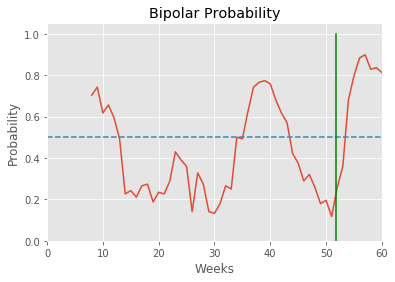

175
hamburgerphone
2016-11-09 00:00:00
2015-11-08 19:54:32
2016-12-28 20:46:47


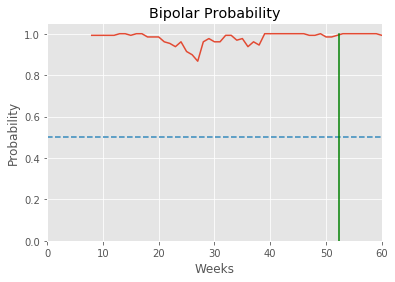

176
__bmorris
2013-04-01 00:00:00
2012-05-21 02:20:35
2013-07-01 08:02:23


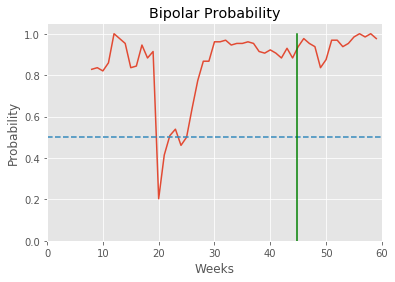

177
Moziee22
2016-07-20 00:00:00
2016-06-02 09:50:03
2016-10-19 06:21:40


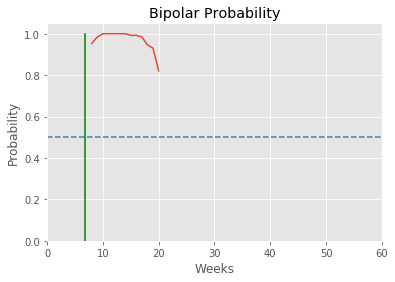

178
LonerBelle
2015-05-21 00:00:00
2014-05-29 07:40:23
2015-07-30 09:44:46


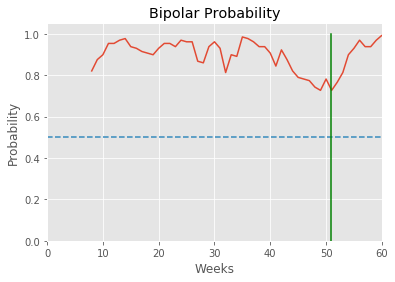

179
BrianCrimson
2014-07-01 00:00:00
2013-06-30 16:13:10
2014-10-01 09:46:35


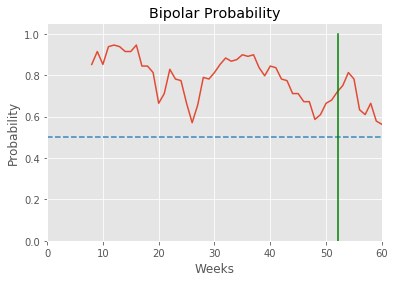

In [22]:
for i, bd_timeline in enumerate(bd_clean):
    print(i)
    print(bd_clean[i]['name'][0])
    print(patient_month_time_dict[bd_clean[i]['name'][0]])
    print(bd_clean[i].index[0])
    print(bd_clean[i].index[-1])
    try:
        predict_prob_list = pol_report(bd_timeline)
        if len(predict_prob_list) < 1 : 
            print('\t No match time')
            continue
        plt.plot(range(len(predict_prob_list)+8)[8:],[window_info['bipolar_probability'] for window_info in predict_prob_list])
        plt.xlabel('Weeks')
        plt.ylabel('Probability')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 60])
        plt.plot((0, 60), (0.5, 0.5), '--')
        plt.title("Bipolar Probability")
        plt.legend(loc="lower right")
        plt.grid(True)
        diagnosed_week = (patient_month_time_dict[bd_clean[i]['name'][0]] - bd_clean[i].index[0]).days / 7.0
        plt.plot((diagnosed_week, diagnosed_week), (0.0, 1.0), 'g-')
        plt.show()
        plt.close()
    except:
        continue

## Load Normal People

In [23]:
regular_clean = []
regular_folder = './Regular_timeline/'
for regular_file in checkFolderFile(regular_folder):
    regular_clean.append(pd.read_pickle(regular_folder+regular_file))

In [24]:
len(regular_clean)

409

### Predict

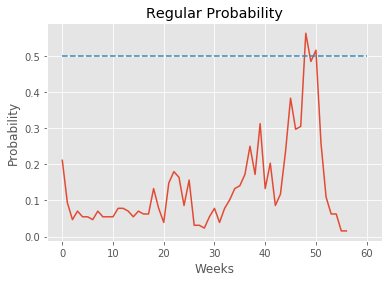

In [28]:
result = pol_report(regular_clean[4])
y = [window_info['bipolar_probability'] for window_info in result]
plt.plot(y)
plt.plot((0, 60), (0.5, 0.5), '--')
plt.xlabel('Weeks')
plt.ylabel('Probability')
plt.title("Regular Probability")

plt.legend(loc="lower right")

plt.show()

0
614672119
2012-06-21 22:39:02-05:00
2015-05-28 19:23:07-05:00
1
233079143
2014-08-29 03:14:07-05:00
2015-06-19 22:11:51-05:00


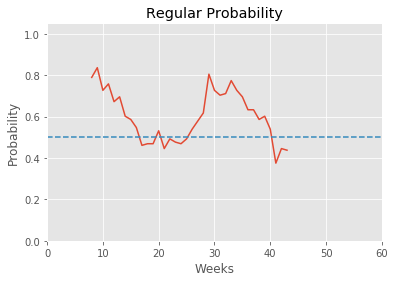

2
392872651
2011-10-18 14:26:30-05:00
2015-06-18 20:00:58-05:00


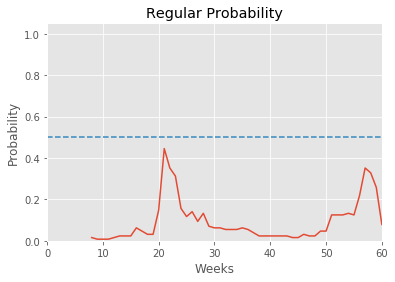

3
20050557
2009-02-04 08:01:54-05:00
2015-06-12 14:17:12-05:00
4
2421314718
2014-04-01 03:59:25-05:00
2015-06-18 08:14:13-05:00


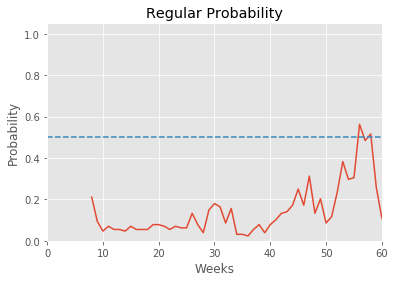

5
2258116816
2014-01-03 11:48:39-05:00
2015-06-14 09:13:35-05:00


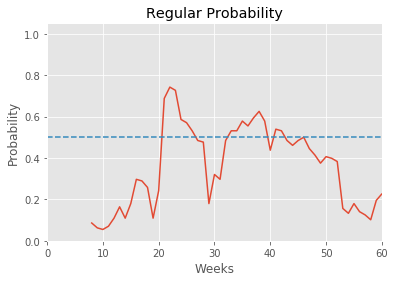

6
20630658
2014-12-03 16:26:58-05:00
2015-06-19 21:42:59-05:00


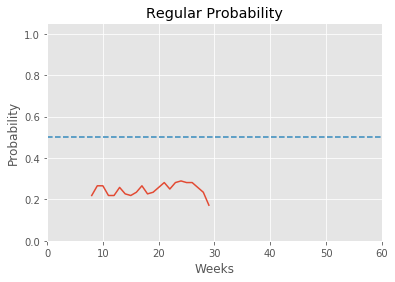

7
437836519
2012-01-18 21:10:08-05:00
2015-06-19 13:16:30-05:00


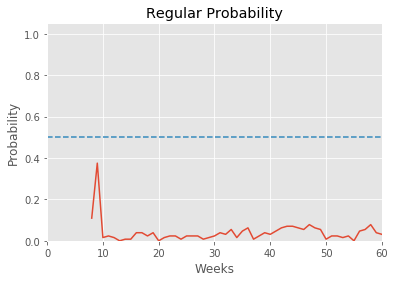

8
3171649794
2015-04-30 03:07:05-05:00
2015-06-20 01:35:33-05:00


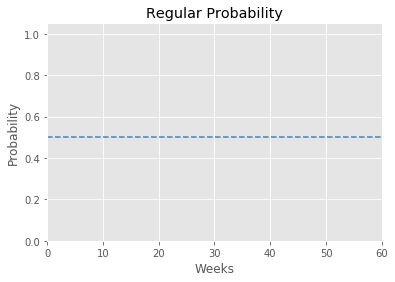

9
852582816
2012-10-22 12:07:30-05:00
2015-06-18 15:07:43-05:00
10
16429118
2014-03-03 17:04:36-05:00
2015-06-17 14:11:44-05:00


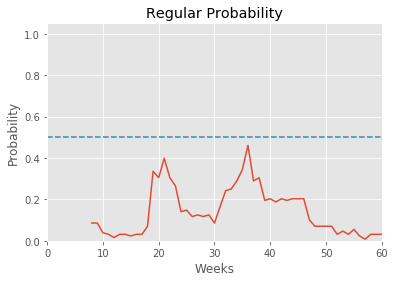

11
584405873
2012-05-19 15:38:46-05:00
2015-06-16 12:27:01-05:00


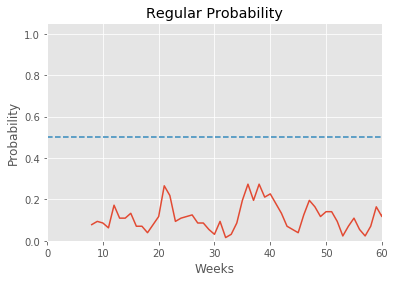

12
343123427
2013-03-29 03:44:37-05:00
2015-06-16 07:28:56-05:00
13
257146329
2011-02-24 23:16:41-05:00
2015-06-16 21:32:11-05:00
14
324457014
2011-12-12 09:39:50-05:00
2015-06-19 07:30:03-05:00
15
330133311
2014-07-22 20:39:42-05:00
2015-06-18 07:23:08-05:00


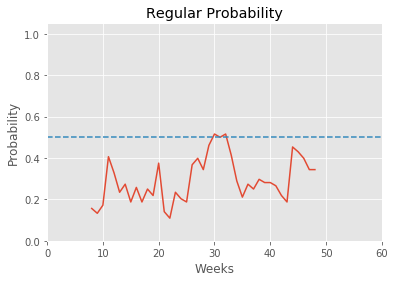

16
1611116828
2014-01-05 21:48:48-05:00
2015-06-13 13:04:31-05:00
17
1161362820
2013-02-09 02:04:45-05:00
2015-06-19 20:10:26-05:00


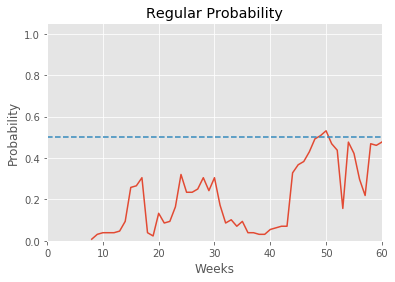

18
277197934
2012-04-23 04:34:49-05:00
2015-06-19 02:40:10-05:00


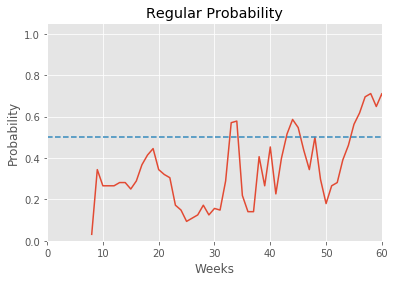

19
22683865
2013-12-17 19:54:18-05:00
2015-06-19 18:33:42-05:00


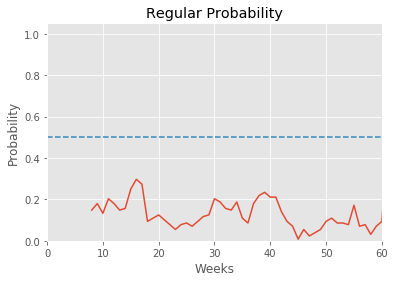

20
94620632
2012-11-09 04:46:30-05:00
2015-06-14 02:41:51-05:00


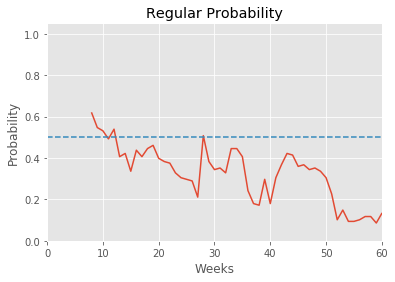

21
799793101
2012-09-02 22:14:36-05:00
2015-06-19 06:21:12-05:00


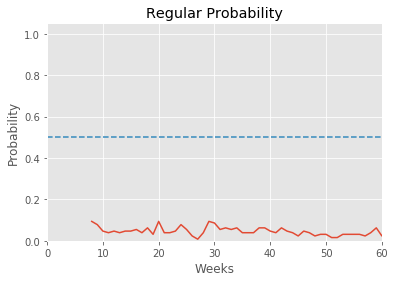

22
486971720
2012-02-09 18:41:54-05:00
2015-05-04 01:56:02-05:00


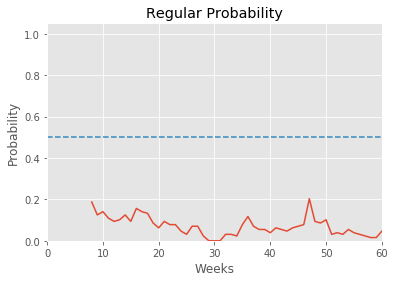

23
88208778
2013-05-28 05:57:17-05:00
2015-06-17 15:50:52-05:00


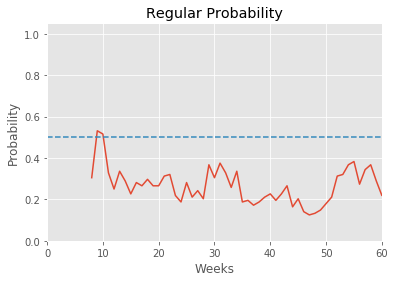

24
43083651
2009-07-02 07:25:48-05:00
2015-06-20 11:57:20-05:00
25
2580632559
2014-07-27 12:39:03-05:00
2015-06-19 17:29:24-05:00
26
72277004
2014-12-02 19:39:42-05:00
2015-06-19 02:35:18-05:00


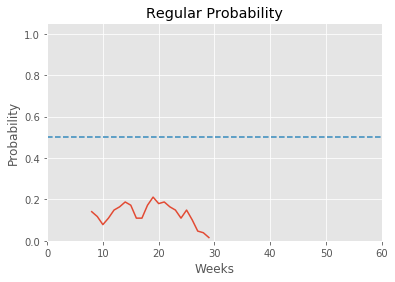

27
32190377
2011-02-13 07:31:26-05:00
2015-06-19 17:35:03-05:00


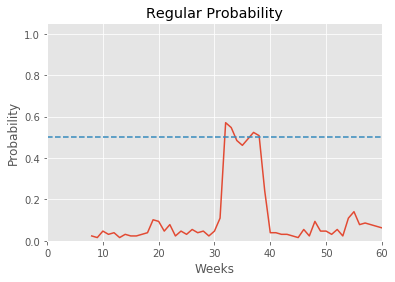

28
827249540
2012-10-22 00:49:00-05:00
2015-06-14 14:56:36-05:00
29
323395360
2011-06-24 14:47:17-05:00
2015-06-20 06:34:12-05:00


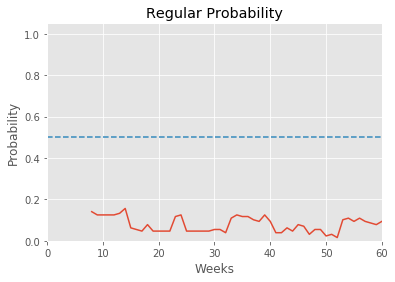

30
30026822
2011-04-21 13:19:29-05:00
2015-06-18 07:12:24-05:00


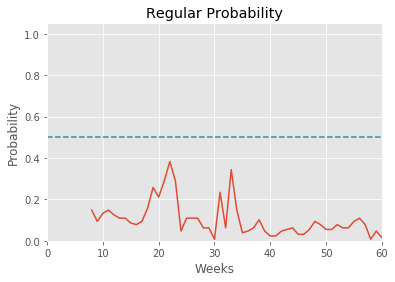

31
2301867749
2014-01-27 18:31:33-05:00
2015-06-16 02:19:37-05:00


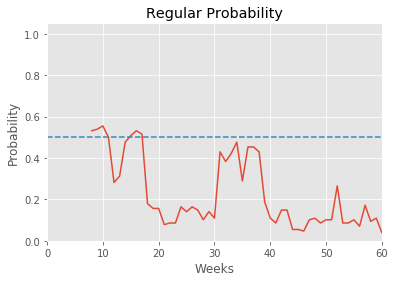

32
558654135
2012-06-17 13:16:41-05:00
2015-06-19 18:13:11-05:00
33
632314489
2012-07-10 14:30:44-05:00
2015-06-14 10:53:37-05:00


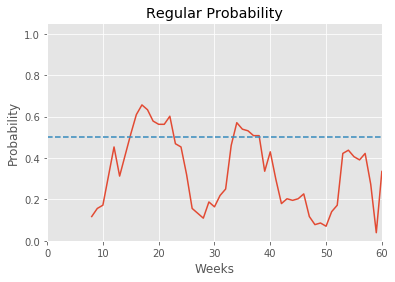

34
231160219
2011-10-18 02:43:34-05:00
2015-06-19 14:09:24-05:00
35
7881222
2013-09-09 09:34:47-05:00
2015-06-19 10:30:27-05:00


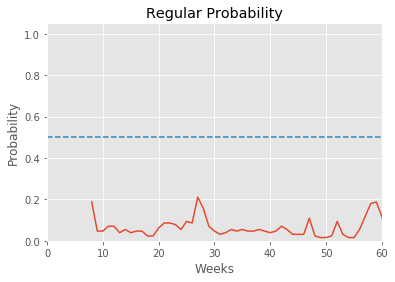

36
134444672
2010-04-18 04:44:17-05:00
2015-05-12 12:08:34-05:00
37
929639150
2012-11-06 08:26:56-05:00
2015-06-18 16:07:50-05:00


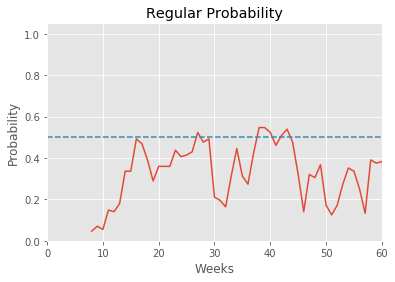

38
2343399067
2014-04-06 14:38:50-05:00
2015-06-19 15:01:16-05:00
39
575566096
2014-04-29 12:40:38-05:00
2015-06-20 13:32:13-05:00


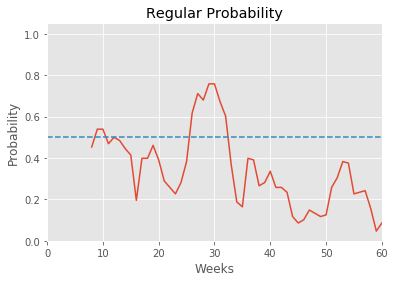

40
255694237
2012-11-09 06:54:49-05:00
2015-06-18 19:57:04-05:00


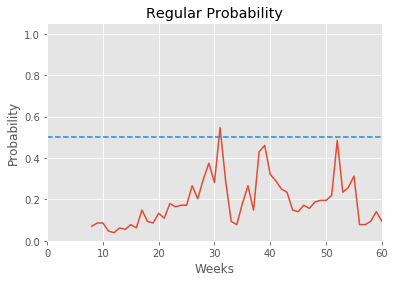

41
488853401
2013-04-15 23:41:17-05:00
2015-06-20 00:10:41-05:00


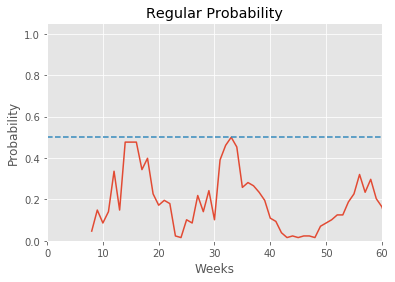

42
85093166
2013-08-04 05:31:30-05:00
2015-06-19 15:12:04-05:00


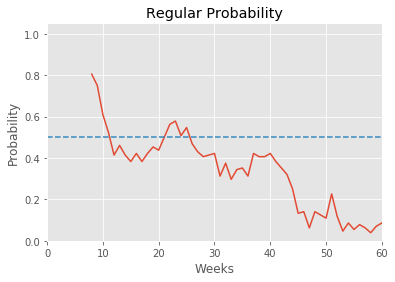

43
33703795
2014-06-24 17:53:58-05:00
2015-06-18 01:50:34-05:00


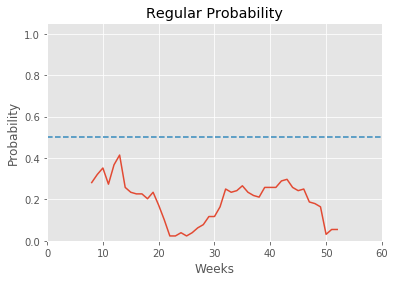

44
270947835
2012-11-04 18:14:10-05:00
2015-06-19 10:57:01-05:00


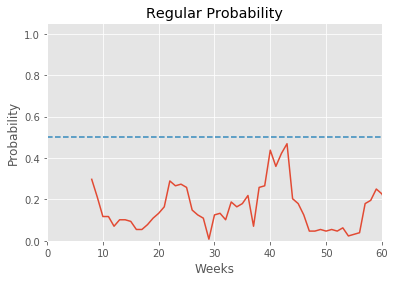

45
88969087
2014-08-21 02:48:11-05:00
2015-06-20 01:07:48-05:00


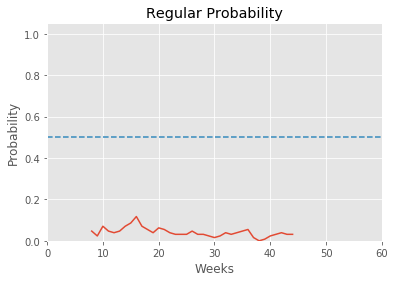

46
107714632
2010-01-23 15:11:14-05:00
2015-06-18 13:41:06-05:00


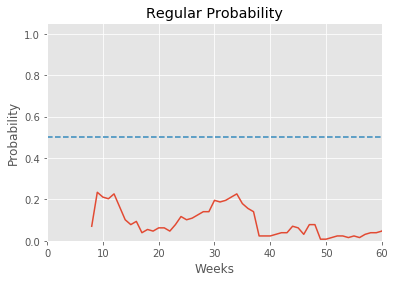

47
18348376
2013-10-24 17:54:16-05:00
2015-06-19 19:05:01-05:00


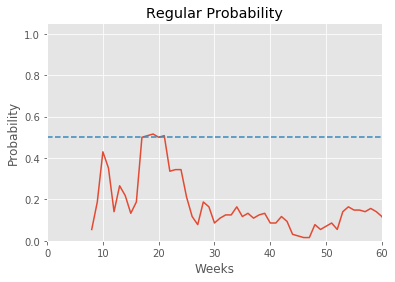

48
2435694611
2014-03-31 13:41:49-05:00
2015-06-19 00:00:05-05:00


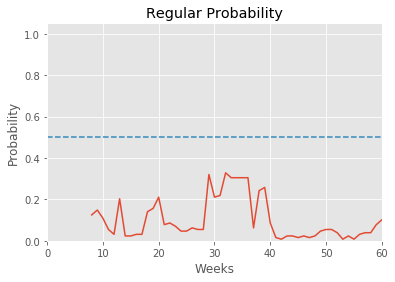

49
18186373
2013-03-18 12:20:42-05:00
2015-06-19 02:19:11-05:00


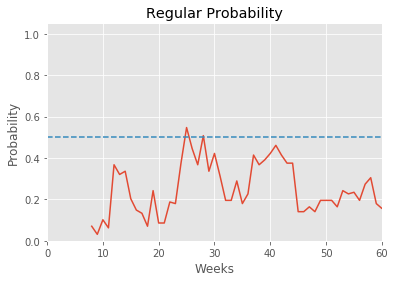

50
2782617838
2015-02-12 18:09:39-05:00
2015-06-19 14:34:29-05:00


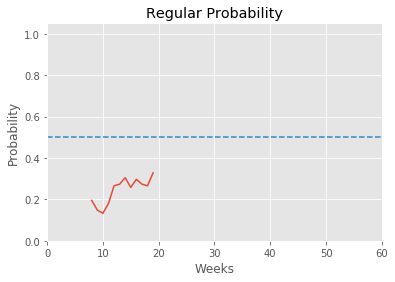

51
19709299
2009-01-29 07:59:49-05:00
2015-06-19 01:44:37-05:00
52
21177788
2012-12-04 10:21:30-05:00
2015-06-20 06:43:18-05:00


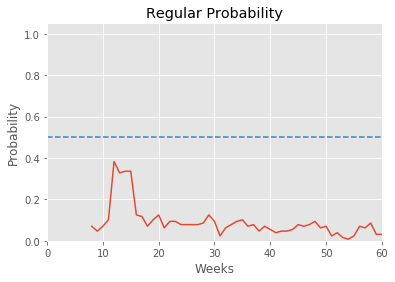

53
479904967
2012-02-01 02:30:52-05:00
2015-04-29 23:50:11-05:00
54
342479368
2011-07-26 15:40:42-05:00
2015-06-20 15:24:03-05:00


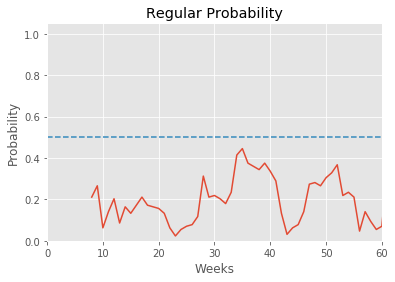

55
977332260
2013-10-10 22:22:47-05:00
2015-06-20 01:46:07-05:00


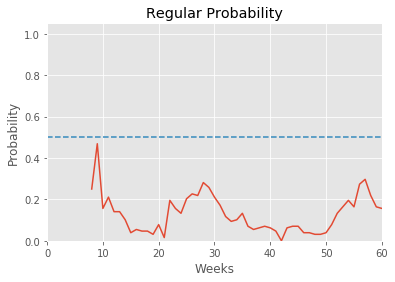

56
621988766
2013-03-31 05:46:42-05:00
2015-06-20 10:34:46-05:00


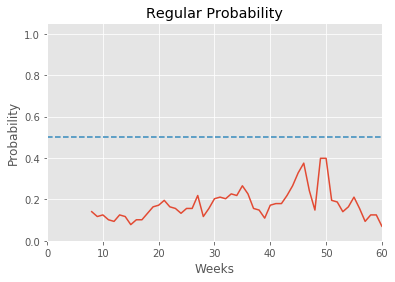

57
1174490948
2013-02-13 11:53:45-05:00
2015-06-11 19:27:37-05:00
58
805441633
2012-09-06 15:12:07-05:00
2015-05-09 16:34:16-05:00
59
547007481
2012-04-06 11:09:43-05:00
2015-06-19 07:23:38-05:00


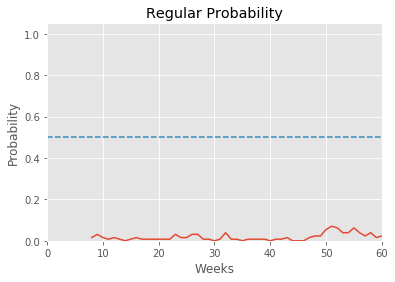

60
163873517
2010-07-07 13:04:39-05:00
2015-06-19 13:27:11-05:00
61
157602777
2013-05-17 03:02:15-05:00
2015-06-16 15:09:36-05:00


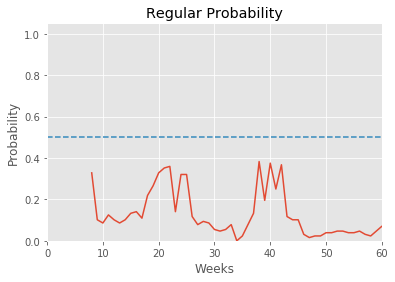

62
2774118515
2014-09-18 14:25:37-05:00
2015-06-17 12:53:37-05:00


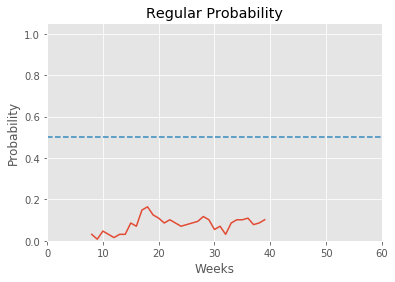

63
3042306033
2015-02-17 17:43:41-05:00
2015-06-18 13:53:14-05:00


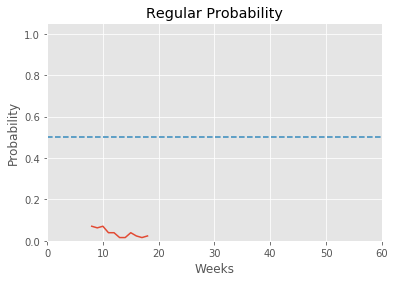

64
753673128
2014-04-17 15:44:26-05:00
2015-06-10 19:13:32-05:00


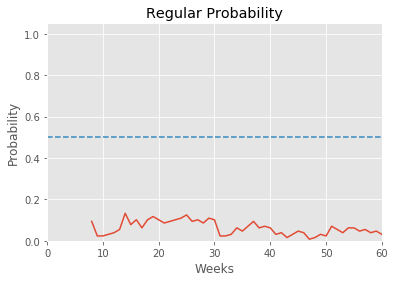

65
47215498
2013-03-22 11:14:46-05:00
2015-06-19 08:40:23-05:00


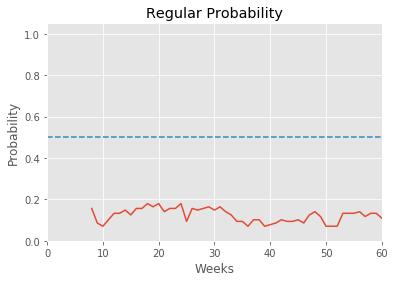

66
150438158
2013-08-06 04:11:32-05:00
2015-06-19 03:14:07-05:00
67
347733637
2013-03-10 20:52:57-05:00
2015-05-30 18:46:48-05:00


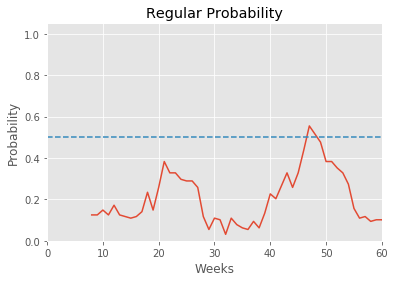

68
124522140
2010-04-01 20:47:35-05:00
2015-06-17 22:05:45-05:00
69
505162262
2012-02-28 16:05:13-05:00
2015-05-07 04:33:01-05:00
70
419116225
2015-02-06 00:01:24-05:00
2015-06-20 03:45:17-05:00


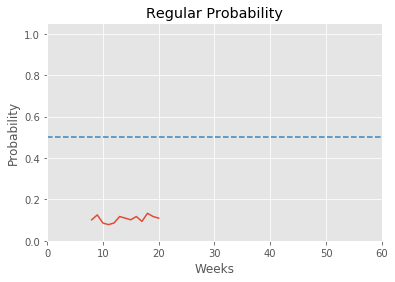

71
1252843136
2013-03-11 17:07:59-05:00
2015-06-20 19:01:38-05:00


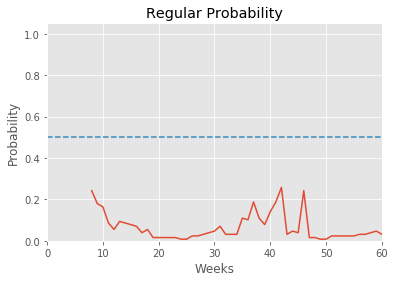

72
535649008
2012-03-24 18:49:59-05:00
2015-03-05 23:24:20-05:00
73
165807638
2012-10-20 09:14:36-05:00
2015-06-17 12:48:28-05:00
74
255161667
2013-01-22 03:52:18-05:00
2015-06-17 12:48:50-05:00


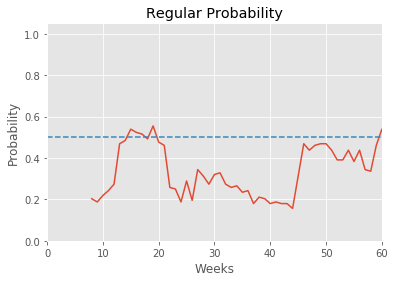

75
242647157
2011-01-25 03:23:57-05:00
2015-06-15 16:50:56-05:00


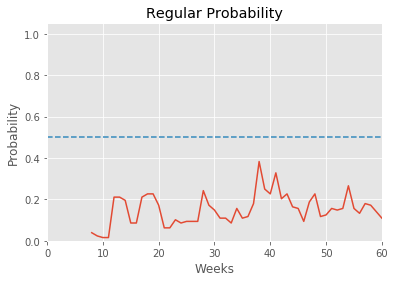

76
245605734
2012-05-06 02:00:54-05:00
2015-05-01 20:26:15-05:00


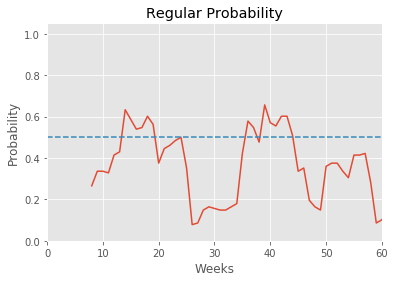

77
108656527
2010-01-26 17:14:34-05:00
2015-05-07 14:38:48-05:00
78
2460188923
2014-04-23 19:23:50-05:00
2015-06-18 10:53:35-05:00


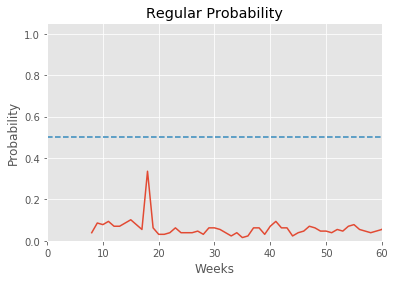

79
527288540
2012-05-26 04:58:10-05:00
2015-06-12 10:29:26-05:00
80
20541338
2012-09-02 02:00:07-05:00
2015-06-19 03:15:40-05:00


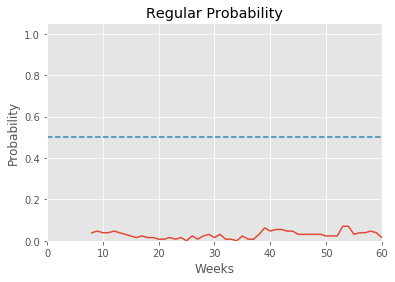

81
890159047
2013-06-19 16:51:18-05:00
2015-06-20 12:33:14-05:00


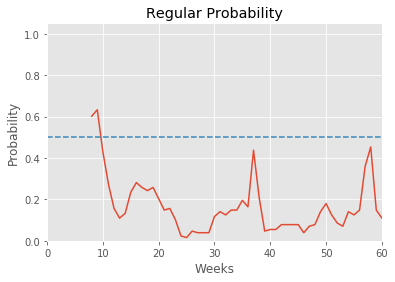

82
126164060
2014-02-27 04:01:23-05:00
2015-06-20 05:17:08-05:00


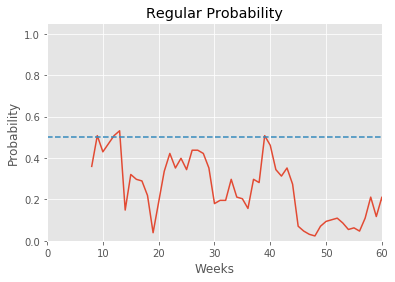

83
2836236650
2014-10-01 08:38:30-05:00
2015-06-17 21:52:20-05:00


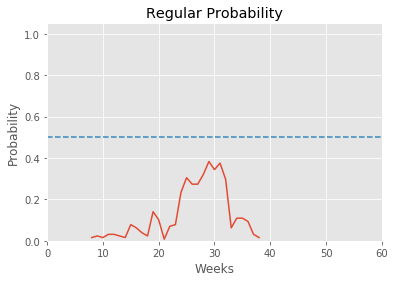

84
94913672
2014-01-22 20:27:27-05:00
2015-06-20 18:18:49-05:00


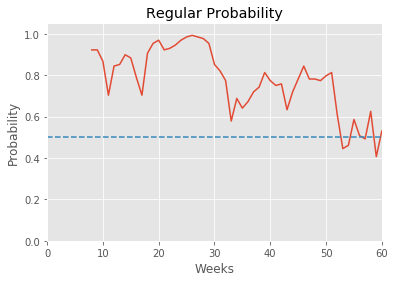

85
66257390
2013-06-21 16:18:46-05:00
2015-06-19 10:47:40-05:00


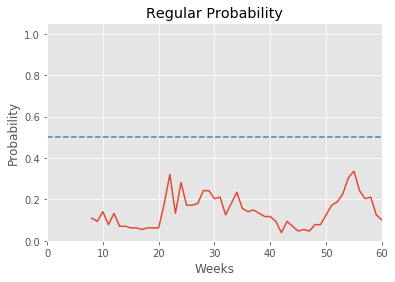

86
2847673069
2015-05-13 08:09:45-05:00
2015-06-20 09:47:28-05:00


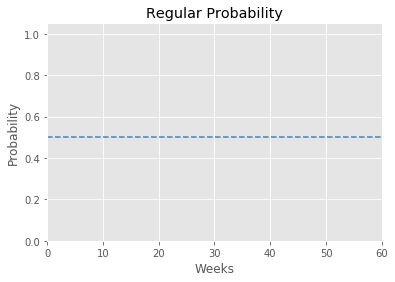

87
17417610
2008-11-16 06:42:55-05:00
2015-06-19 22:34:09-05:00
88
76519181
2014-12-09 20:50:44-05:00
2015-06-16 18:25:00-05:00


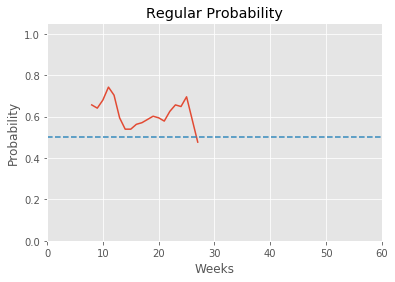

89
102490375
2014-05-15 20:25:46-05:00
2015-06-19 04:16:05-05:00


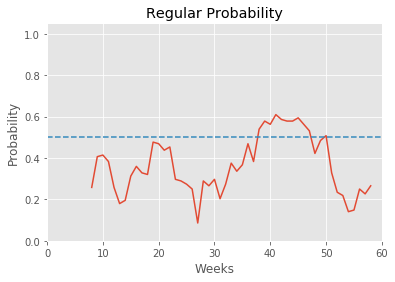

90
247941173
2011-03-16 12:46:13-05:00
2015-06-20 14:19:34-05:00


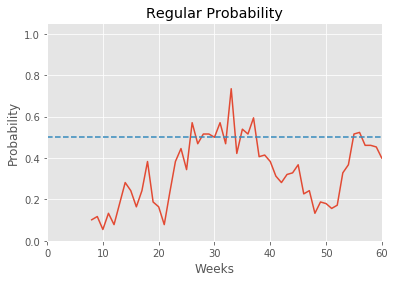

91
506619596
2015-04-02 10:01:51-05:00
2015-06-20 01:42:02-05:00


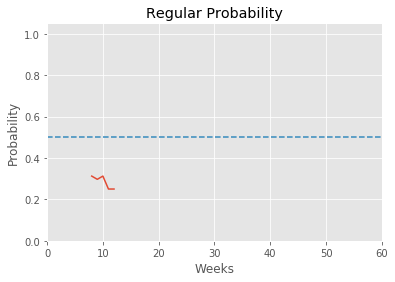

92
354459607
2011-09-21 07:42:26-05:00
2014-12-02 03:42:11-05:00
93
865492441
2013-11-22 17:45:40-05:00
2015-06-20 03:04:53-05:00


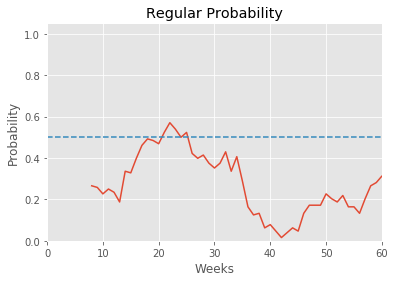

94
240437959
2011-01-20 00:09:25-05:00
2015-06-07 23:51:04-05:00


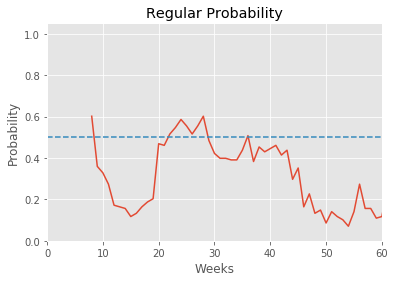

95
563410338
2012-06-05 01:56:08-05:00
2015-06-10 12:05:19-05:00
96
583425395
2013-06-13 01:09:03-05:00
2015-06-19 21:22:41-05:00


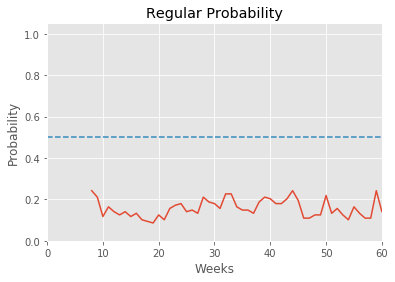

97
577106070
2012-05-23 03:48:39-05:00
2015-06-15 02:23:57-05:00
98
271189177
2014-08-05 21:54:38-05:00
2015-06-18 04:49:44-05:00


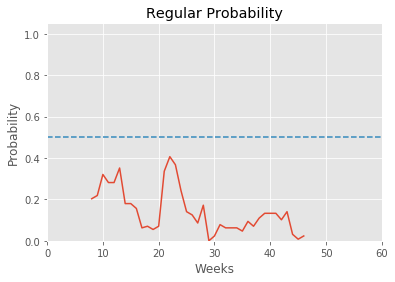

99
454427951
2014-11-12 06:16:18-05:00
2015-06-10 18:49:34-05:00


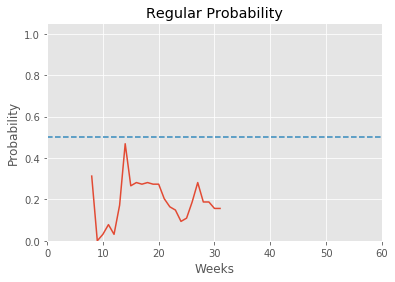

100
2442361929
2014-08-10 22:40:17-05:00
2015-06-20 14:35:55-05:00


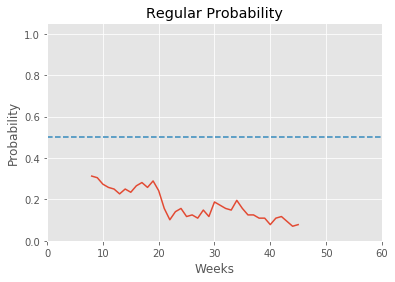

101
21773199
2009-02-25 01:13:52-05:00
2015-06-13 02:43:36-05:00
102
1085898517
2013-01-13 07:17:44-05:00
2015-06-16 15:30:46-05:00
103
258321931
2013-05-19 08:43:23-05:00
2015-06-14 09:53:21-05:00
104
453767970
2014-10-19 06:21:04-05:00
2015-06-21 02:18:09-05:00


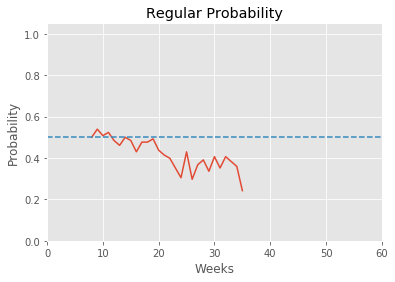

105
382826168
2011-09-30 17:32:32-05:00
2015-05-13 19:07:46-05:00
106
27469161
2009-03-29 19:59:05-05:00
2015-06-20 08:06:57-05:00
107
19615832
2012-04-22 16:19:03-05:00
2015-06-19 18:43:06-05:00


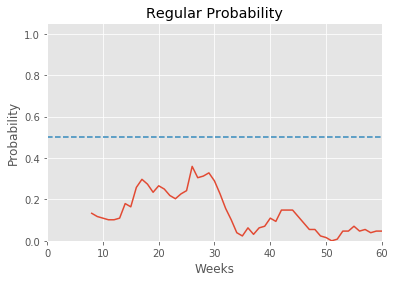

108
1436891287
2013-05-18 21:47:37-05:00
2015-06-19 20:29:47-05:00
109
702724255
2013-03-08 20:32:12-05:00
2015-06-19 12:29:50-05:00


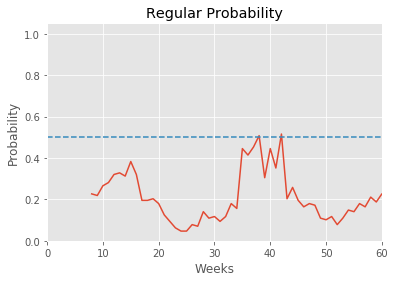

110
142510810
2013-04-16 03:42:50-05:00
2015-06-19 01:18:37-05:00
111
1496482082
2013-06-11 04:29:55-05:00
2015-06-19 03:12:21-05:00
112
209744117
2010-10-29 10:23:33-05:00
2015-06-16 00:23:41-05:00
113
241931726
2014-07-08 15:54:02-05:00
2015-06-21 00:32:41-05:00


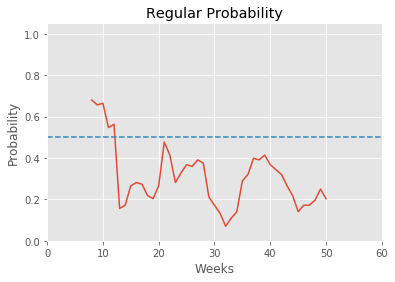

114
1470697826
2013-05-31 16:32:35-05:00
2015-06-03 13:58:19-05:00
115
86425438
2010-02-16 01:24:34-05:00
2015-06-21 01:50:58-05:00
116
371816915
2011-09-12 12:27:38-05:00
2015-06-18 01:45:13-05:00


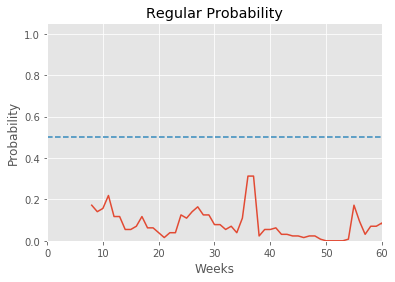

117
2455105714
2014-04-05 20:33:11-05:00
2015-04-15 17:49:51-05:00
118
1906007168
2013-10-02 13:15:17-05:00
2015-06-18 20:15:00-05:00


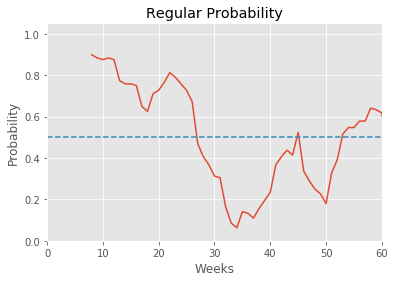

119
321459760
2013-08-27 21:37:18-05:00
2015-04-16 14:22:37-05:00


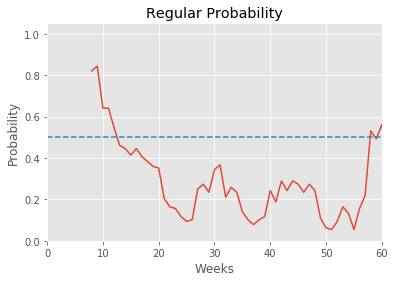

120
361501995
2011-08-24 16:19:51-05:00
2015-06-06 18:33:09-05:00
121
948811094
2013-11-12 22:13:16-05:00
2015-06-18 02:51:05-05:00


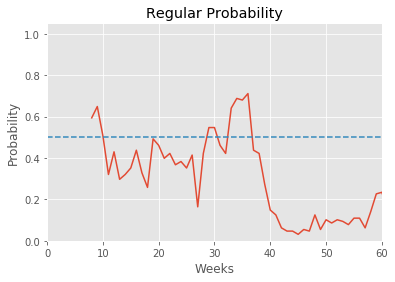

122
348018168
2013-03-18 21:47:32-05:00
2015-06-19 06:35:18-05:00


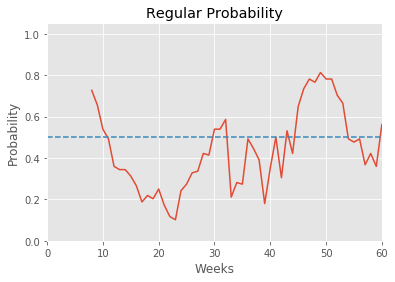

123
1379442980
2014-08-16 16:22:00-05:00
2015-06-18 04:25:24-05:00
124
3018663162
2015-02-13 20:39:34-05:00
2015-06-19 07:06:36-05:00


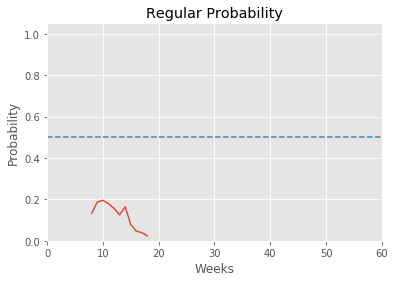

125
2523690391
2014-05-26 02:00:27-05:00
2015-06-17 05:37:39-05:00


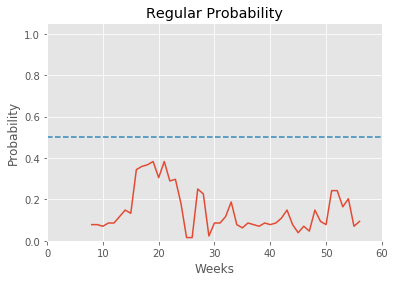

126
461932578
2012-01-25 12:15:20-05:00
2015-06-10 14:36:52-05:00
127
780676116
2013-08-01 18:33:40-05:00
2015-06-01 13:20:56-05:00


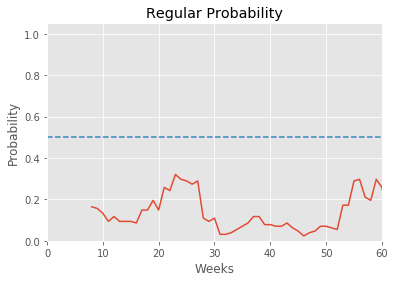

128
1912427275
2013-09-28 19:57:16-05:00
2015-06-15 04:30:15-05:00


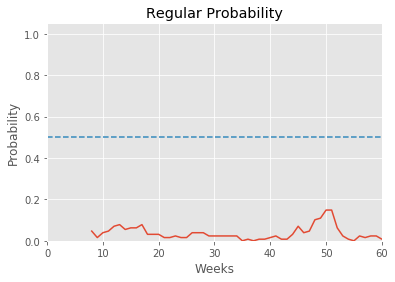

129
889568162
2013-01-27 18:41:09-05:00
2015-06-18 17:04:31-05:00


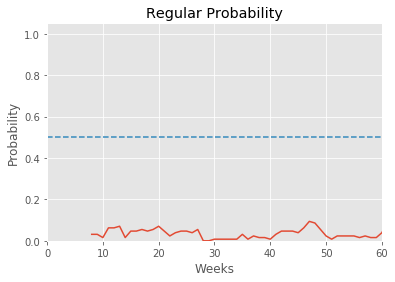

130
335439367
2015-02-20 07:31:56-05:00
2015-06-20 13:01:36-05:00


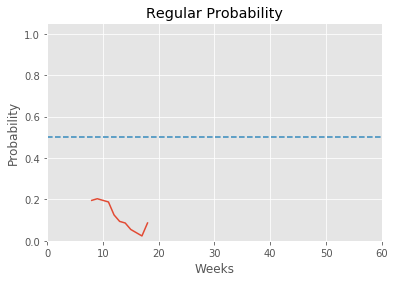

131
499903976
2014-04-11 01:44:56-05:00
2015-06-20 05:02:07-05:00


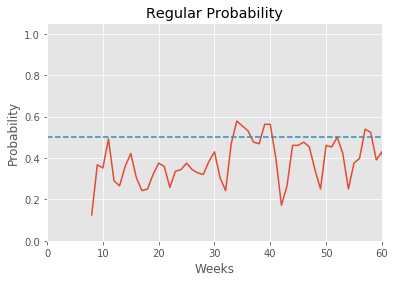

132
30462056
2013-04-19 14:43:03-05:00
2015-05-08 03:34:34-05:00


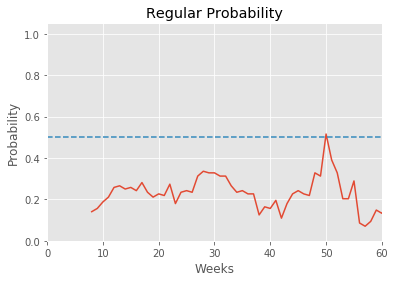

133
22485366
2012-03-04 13:43:02-05:00
2015-06-19 23:18:32-05:00


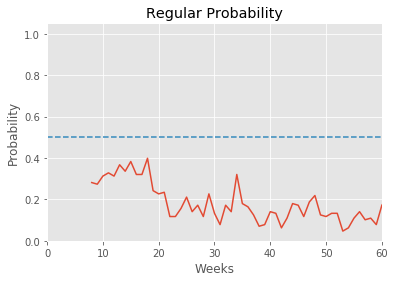

134
75882051
2009-09-20 21:44:42-05:00
2015-06-19 07:20:00-05:00
135
9128402
2014-08-17 22:55:13-05:00
2015-06-16 05:59:16-05:00


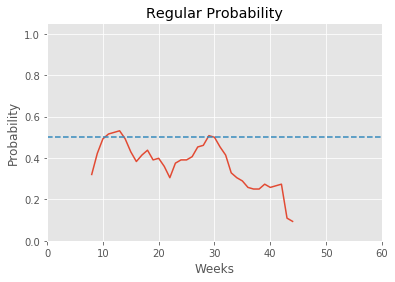

136
2229046237
2013-12-04 03:41:27-05:00
2015-06-17 03:27:51-05:00


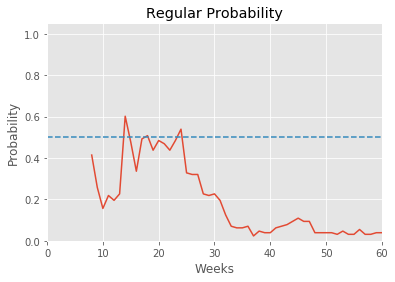

137
2812096134
2014-09-22 06:23:21-05:00
2015-05-28 17:26:26-05:00


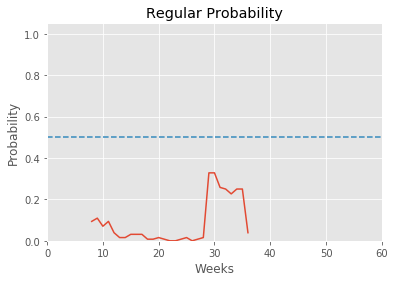

138
548576829
2012-04-08 09:19:53-05:00
2015-06-19 05:17:08-05:00
139
42659505
2009-05-26 10:34:31-05:00
2015-06-20 15:02:07-05:00
140
385423668
2011-10-06 11:49:55-05:00
2015-06-12 19:37:36-05:00
141
317288824
2013-03-19 00:58:11-05:00
2015-06-20 21:02:53-05:00


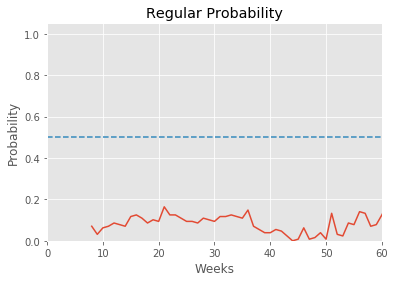

142
2965697195
2015-01-07 01:55:18-05:00
2015-01-18 07:55:36-05:00


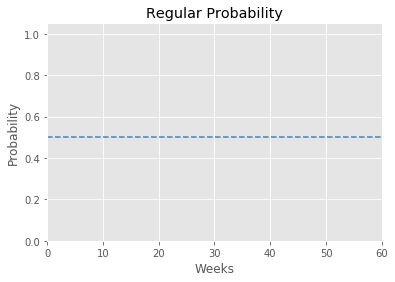

143
468609222
2014-08-17 14:16:50-05:00
2015-06-20 10:49:46-05:00


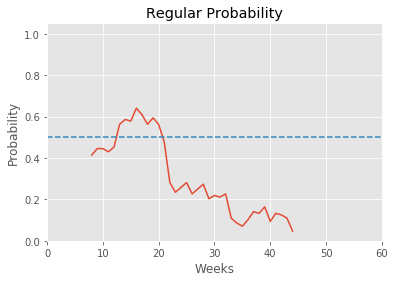

144
414945704
2011-11-19 18:28:32-05:00
2015-06-14 16:00:57-05:00


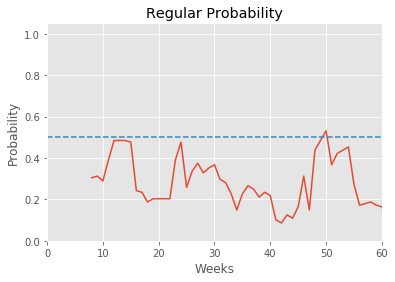

145
301017138
2011-05-18 21:26:14-05:00
2015-06-14 20:57:46-05:00


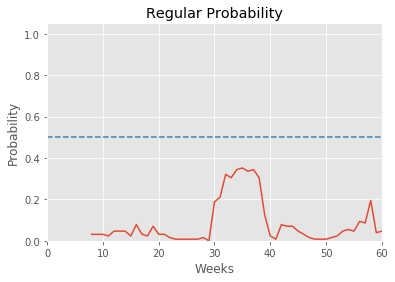

146
349477950
2014-01-24 04:32:15-05:00
2015-05-30 20:16:35-05:00


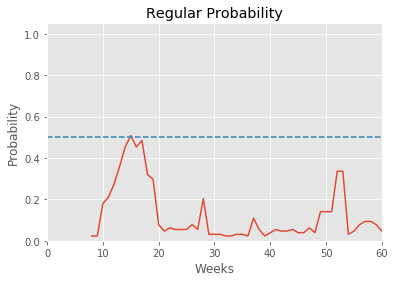

147
356860297
2014-04-25 10:28:01-05:00
2015-06-20 13:37:13-05:00


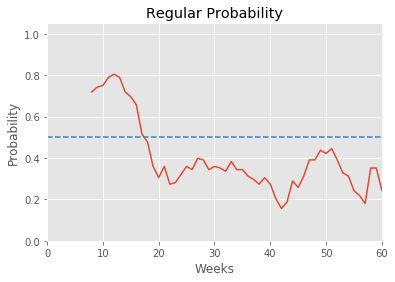

148
1419261308
2013-05-11 01:50:27-05:00
2015-06-18 17:49:46-05:00
149
1546958047
2013-06-26 03:47:02-05:00
2015-06-20 01:17:33-05:00


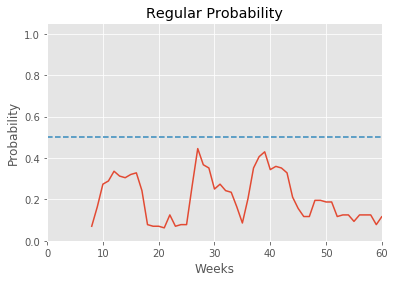

150
190498199
2012-04-03 03:35:21-05:00
2015-06-19 20:47:05-05:00
151
212322618
2014-08-01 21:45:24-05:00
2015-06-18 01:36:32-05:00


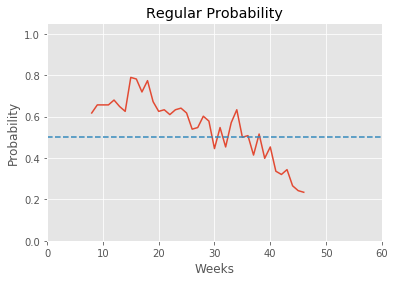

152
1711522867
2014-03-19 01:57:48-05:00
2015-06-04 04:57:55-05:00
153
50435783
2009-08-11 01:52:24-05:00
2015-06-16 01:36:42-05:00
154
569627327
2012-05-05 06:46:09-05:00
2015-06-19 10:43:09-05:00


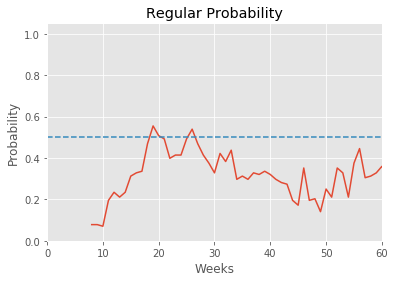

155
1544504863
2014-03-11 14:51:20-05:00
2015-06-18 15:44:12-05:00


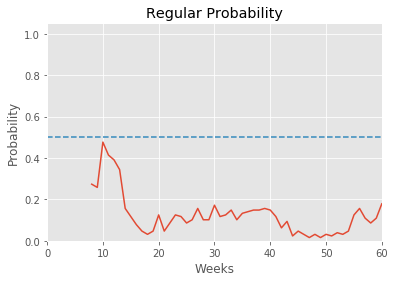

156
1025304181
2013-01-15 19:09:22-05:00
2015-06-19 11:05:26-05:00


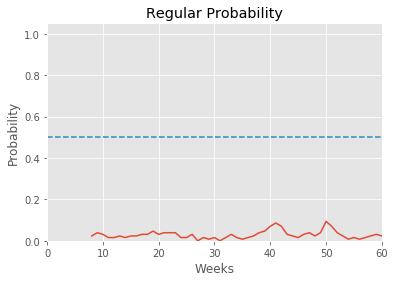

157
755005608
2012-12-07 05:03:18-05:00
2015-06-17 00:31:19-05:00


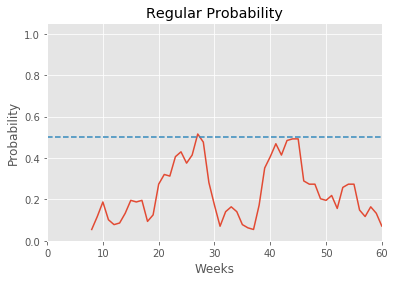

158
350818815
2012-02-15 08:05:16-05:00
2015-06-20 12:51:03-05:00
159
608675862
2014-03-12 23:45:34-05:00
2015-06-20 19:25:15-05:00


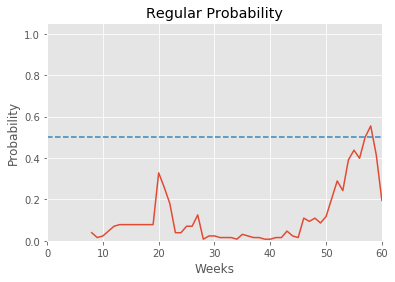

160
421274332
2013-03-05 12:21:06-05:00
2015-06-18 08:44:32-05:00


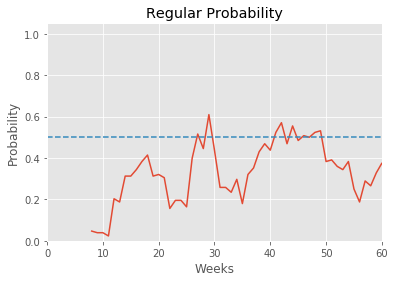

161
509416387
2012-03-05 17:35:27-05:00
2015-06-19 07:53:52-05:00
162
45216314
2012-10-15 16:38:07-05:00
2015-06-20 07:05:19-05:00


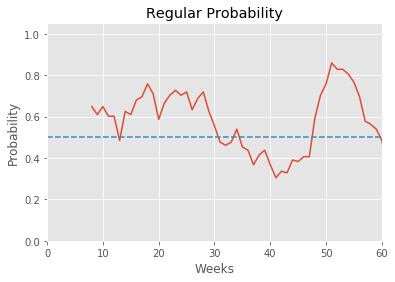

163
897701064
2014-03-28 18:36:45-05:00
2015-06-12 16:19:52-05:00


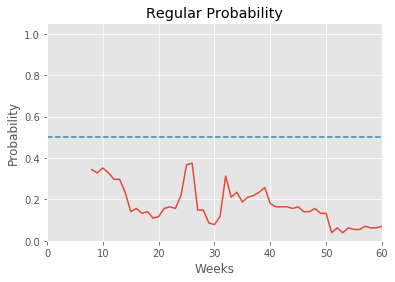

164
132627520
2012-12-11 04:58:48-05:00
2015-06-18 13:47:41-05:00


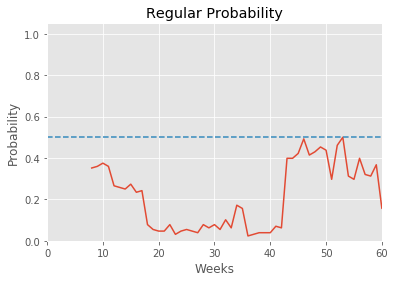

165
202813872
2010-10-14 18:34:06-05:00
2015-06-19 05:24:44-05:00


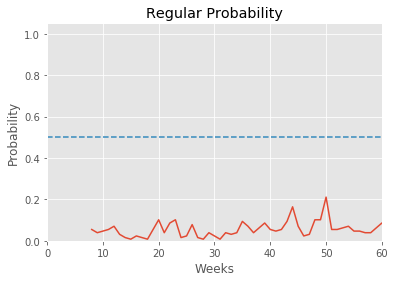

166
83700436
2010-09-10 02:50:01-05:00
2015-06-18 23:51:32-05:00
167
3156227847
2015-04-11 15:51:12-05:00
2015-06-18 19:11:40-05:00


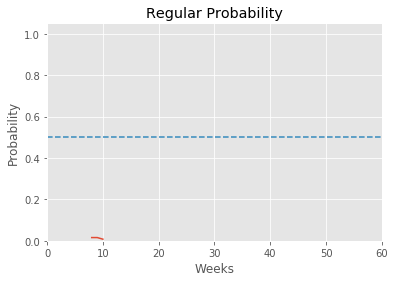

168
360354879
2011-08-23 03:35:43-05:00
2015-05-05 18:14:16-05:00
169
217125890
2012-10-18 15:19:45-05:00
2015-06-18 15:44:55-05:00


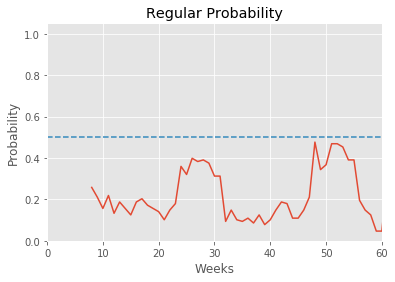

170
18637186
2009-01-05 17:31:33-05:00
2015-06-20 07:03:08-05:00


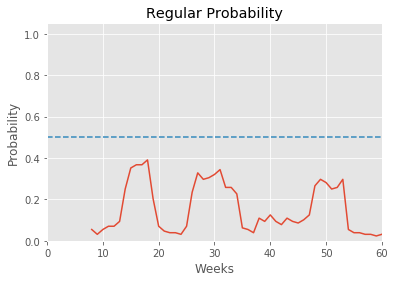

171
464478902
2012-01-18 07:12:59-05:00
2015-06-19 04:13:53-05:00


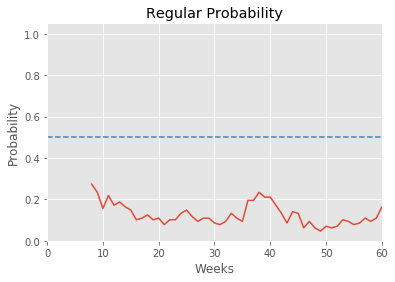

172
2726370772
2014-08-09 20:41:44-05:00
2015-06-18 20:38:11-05:00
173
2387966226
2014-03-14 01:12:21-05:00
2015-06-19 06:53:42-05:00


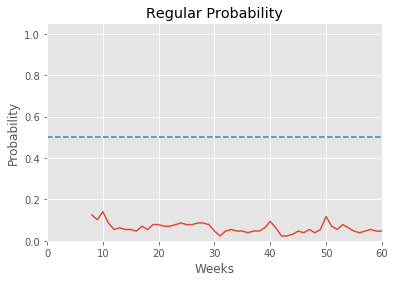

174
35062818
2013-05-01 03:42:50-05:00
2015-06-18 12:50:29-05:00


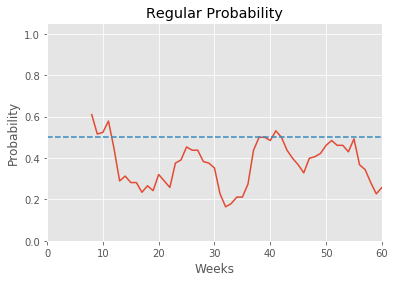

175
2634604817
2014-06-24 16:38:28-05:00
2015-06-19 17:36:35-05:00
176
54436265
2009-07-08 00:41:01-05:00
2015-06-19 21:53:04-05:00
177
203133172
2010-11-14 22:21:48-05:00
2015-06-18 18:20:46-05:00


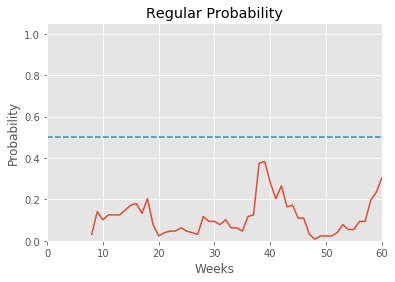

178
80879693
2012-08-17 15:10:19-05:00
2015-06-20 06:46:02-05:00


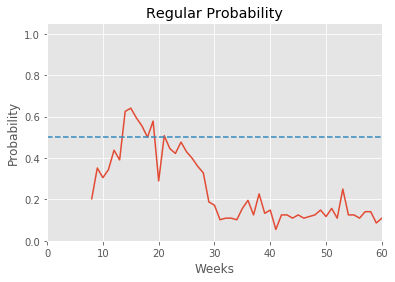

179
136832456
2014-08-27 02:40:00-05:00
2015-06-20 15:08:31-05:00


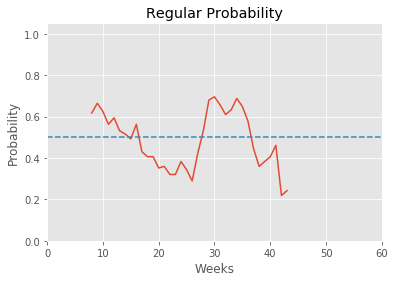

180
2538763274
2014-06-25 20:21:34-05:00
2015-04-30 16:48:29-05:00


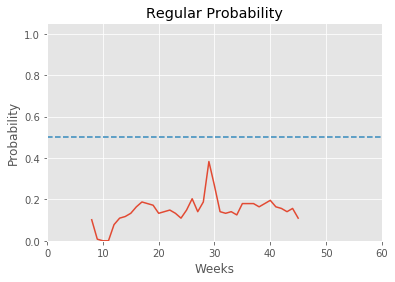

181
28154216
2013-08-12 19:36:50-05:00
2015-06-15 14:38:27-05:00


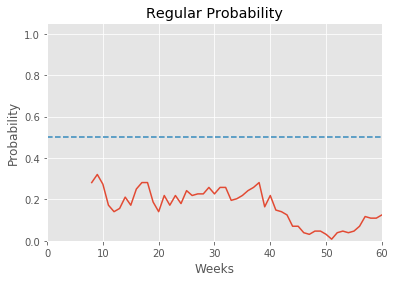

182
245949991
2012-08-09 15:15:56-05:00
2015-06-19 22:24:00-05:00


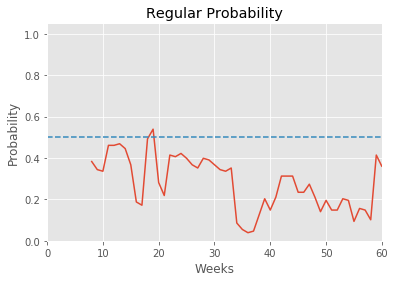

183
2548225621
2014-06-06 11:18:49-05:00
2015-06-20 13:05:31-05:00


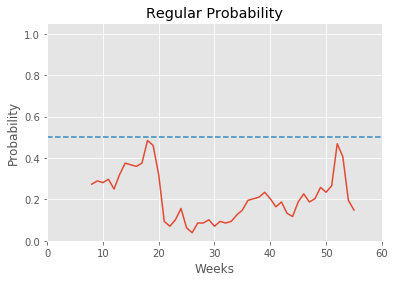

184
557813872
2012-04-20 03:06:56-05:00
2015-04-28 05:01:51-05:00
185
445495657
2011-12-24 18:31:52-05:00
2015-06-19 21:00:01-05:00


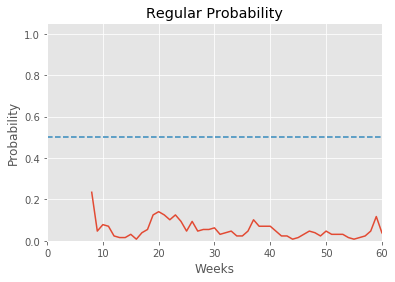

186
598134714
2012-06-03 18:48:14-05:00
2015-06-18 16:32:33-05:00
187
752176910
2012-09-19 22:59:03-05:00
2015-05-07 20:37:05-05:00
188
1506030434
2014-06-10 15:33:28-05:00
2015-06-19 11:09:23-05:00


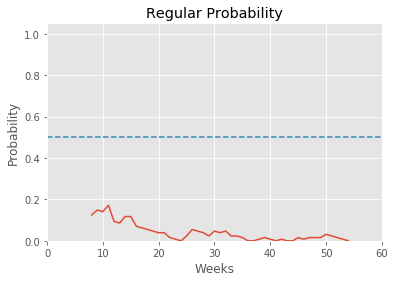

189
115637917
2013-06-12 06:54:29-05:00
2015-06-20 03:36:20-05:00


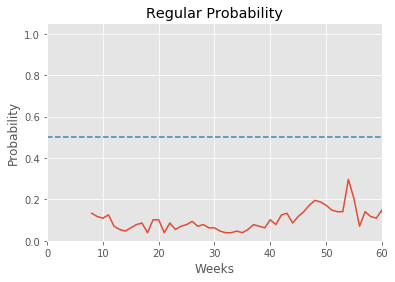

190
189312927
2012-01-14 20:13:42-05:00
2014-12-22 21:02:28-05:00
191
2301439726
2014-06-11 23:49:40-05:00
2015-06-12 18:30:06-05:00


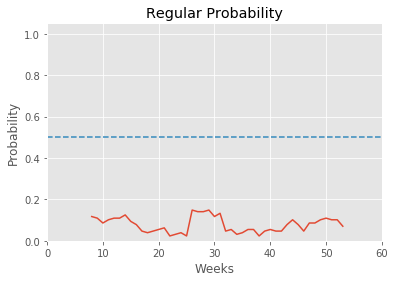

192
102673664
2013-10-29 10:40:11-05:00
2015-06-19 03:00:01-05:00


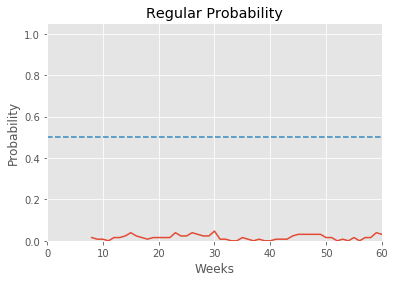

193
365090567
2014-09-28 01:14:02-05:00
2015-03-18 02:26:00-05:00


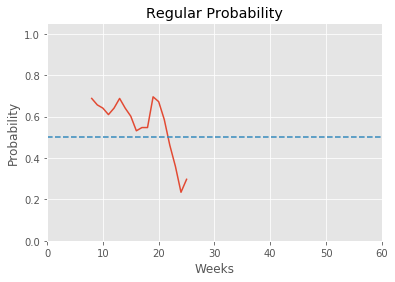

194
177370664
2012-03-28 17:06:38-05:00
2015-06-19 04:00:45-05:00


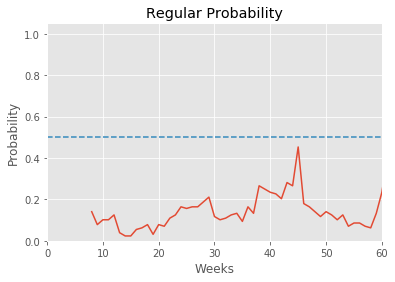

195
1459148665
2013-05-26 10:55:59-05:00
2015-05-29 17:51:30-05:00


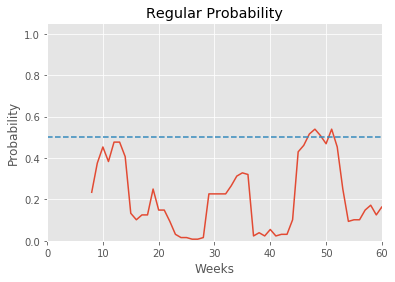

196
2213660384
2014-07-15 11:38:32-05:00
2015-06-19 00:11:45-05:00


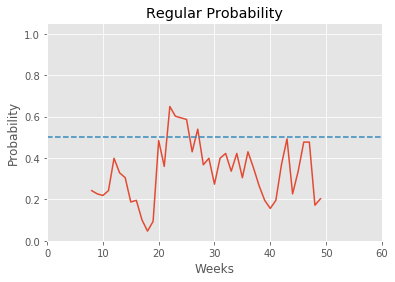

197
1976603018
2014-05-21 14:05:51-05:00
2015-06-18 05:07:11-05:00


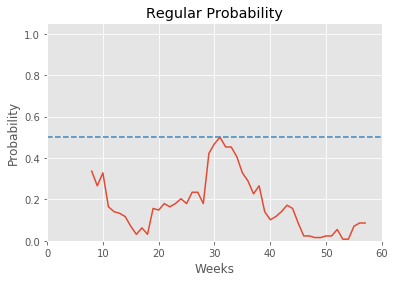

198
2257737920
2014-10-23 09:40:39-05:00
2015-06-18 15:37:37-05:00


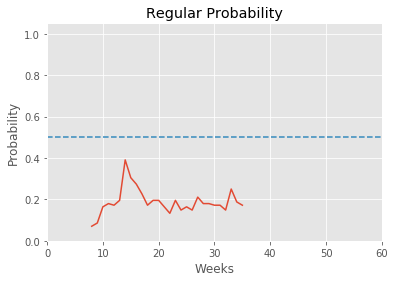

199
129573285
2013-08-25 02:29:15-05:00
2015-06-18 00:24:03-05:00


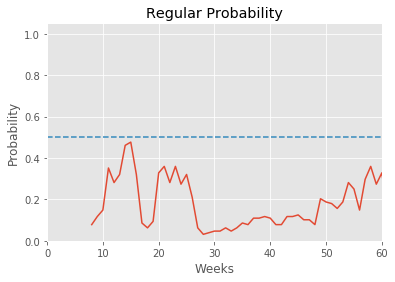

200
1478371008
2013-06-02 17:08:31-05:00
2015-06-17 16:28:58-05:00


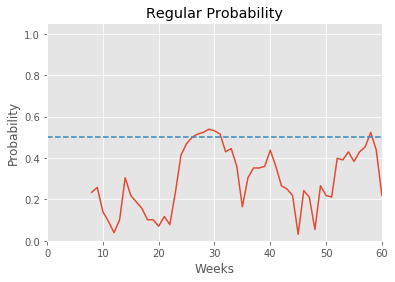

201
16799705
2012-10-03 13:17:00-05:00
2015-06-20 17:33:07-05:00


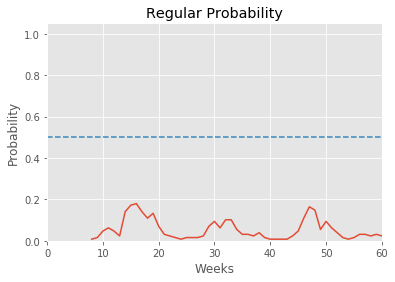

202
107514763
2010-01-22 15:42:38-05:00
2015-06-13 16:18:52-05:00
203
71377222
2013-01-21 02:38:16-05:00
2015-06-20 21:30:31-05:00


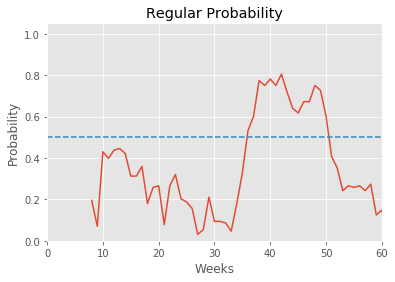

204
2868104733
2014-11-08 18:31:57-05:00
2015-02-01 09:52:21-05:00


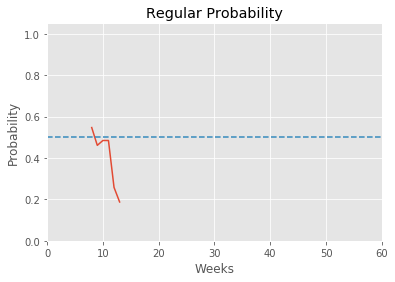

205
108355756
2013-08-14 18:42:29-05:00
2015-06-16 06:33:39-05:00


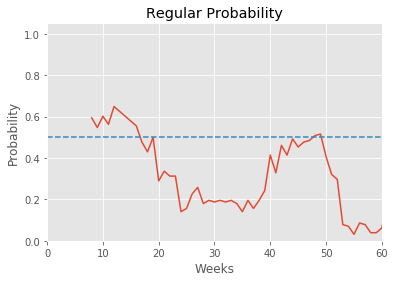

206
849121196
2012-09-27 23:29:18-05:00
2015-05-13 01:15:11-05:00
207
1198837267
2014-11-28 06:11:17-05:00
2015-06-20 09:10:32-05:00


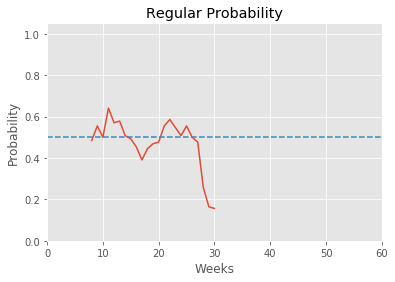

208
620965481
2013-04-08 11:02:48-05:00
2015-06-20 09:20:07-05:00
209
208063717
2011-12-28 17:59:35-05:00
2015-02-18 16:06:13-05:00
210
1265740862
2013-03-15 21:20:14-05:00
2015-06-18 17:36:47-05:00


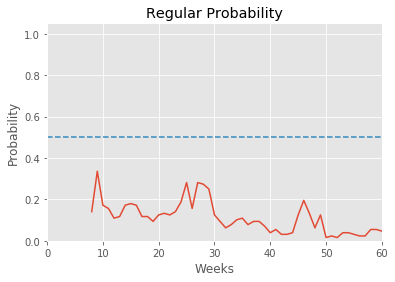

211
1268457804
2014-07-15 00:53:41-05:00
2015-06-20 00:12:38-05:00


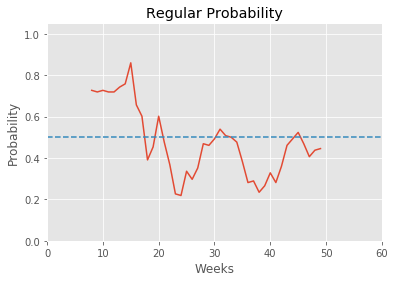

212
448071822
2014-07-06 15:26:39-05:00
2015-06-17 06:56:28-05:00


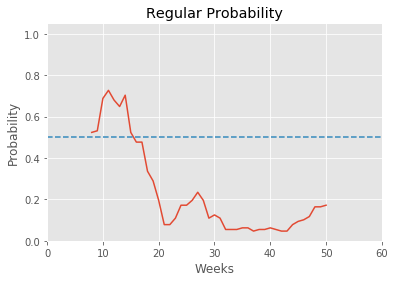

213
54277372
2009-07-06 18:48:14-05:00
2015-06-20 04:11:59-05:00


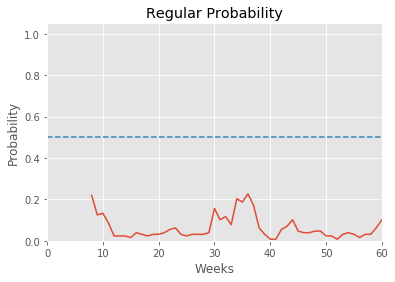

214
3020186592
2015-02-15 02:57:49-05:00
2015-06-20 17:34:29-05:00


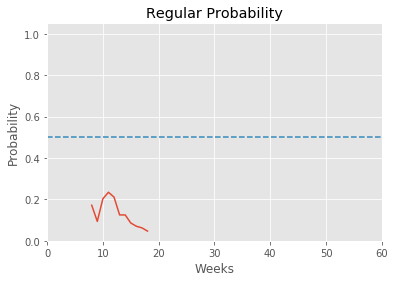

215
20411251
2010-11-22 11:37:54-05:00
2015-06-20 04:14:44-05:00


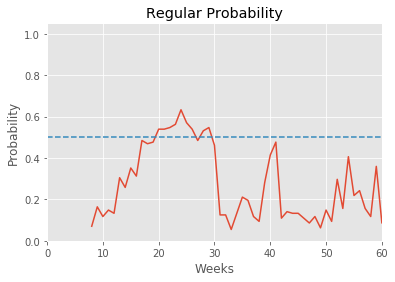

216
27934304
2014-01-24 07:08:13-05:00
2015-06-19 19:10:52-05:00


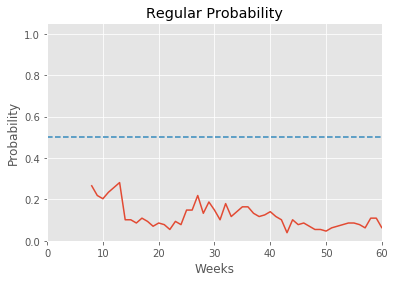

217
36507049
2013-10-15 18:00:39-05:00
2015-06-19 06:00:55-05:00


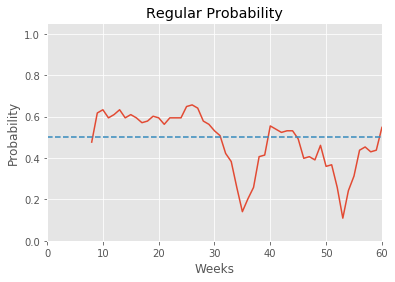

218
19368770
2015-04-17 01:42:18-05:00
2015-06-20 15:57:03-05:00


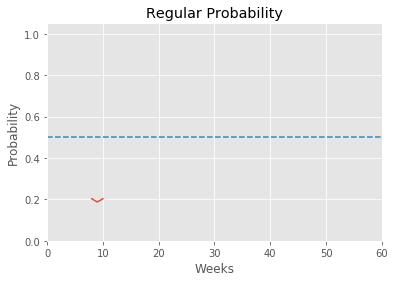

219
564548079
2012-04-27 03:21:13-05:00
2015-06-19 23:53:41-05:00
220
91395174
2012-04-10 04:49:00-05:00
2015-06-12 01:23:47-05:00
221
148143063
2014-08-01 01:16:09-05:00
2015-06-20 01:27:41-05:00


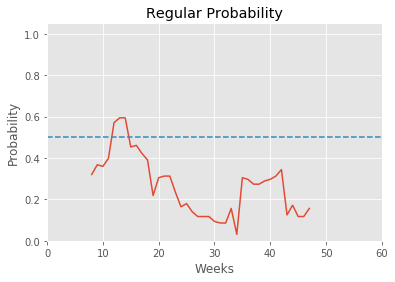

222
540374104
2012-08-07 17:20:06-05:00
2015-06-13 16:47:53-05:00
223
263988001
2012-08-15 18:50:54-05:00
2015-06-15 05:29:05-05:00
224
898821325
2013-03-09 20:18:31-05:00
2015-06-13 03:58:30-05:00


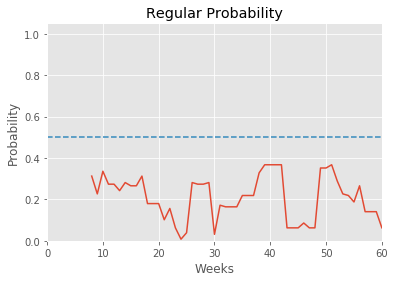

225
933759313
2012-11-26 05:59:42-05:00
2015-06-17 03:13:30-05:00


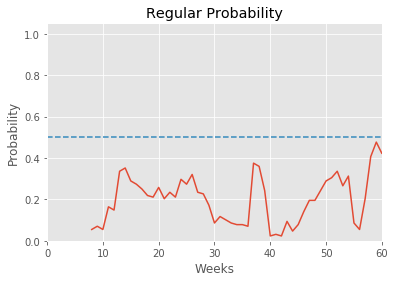

226
383502896
2011-10-02 01:49:11-05:00
2015-06-20 00:02:11-05:00
227
102804402
2012-04-05 19:49:57-05:00
2015-03-02 20:41:35-05:00


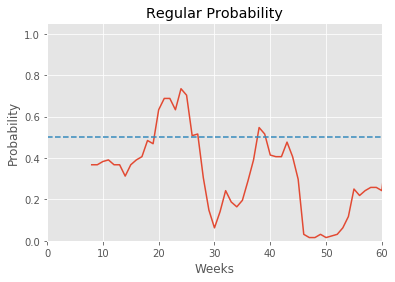

228
271546092
2013-05-25 06:39:28-05:00
2015-06-01 02:43:06-05:00


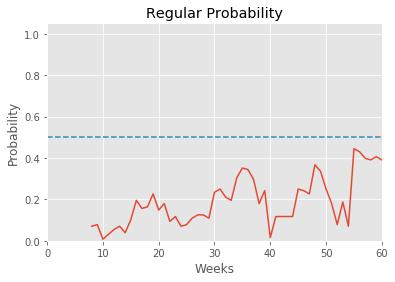

229
207723801
2015-03-24 20:21:29-05:00
2015-06-20 22:16:25-05:00


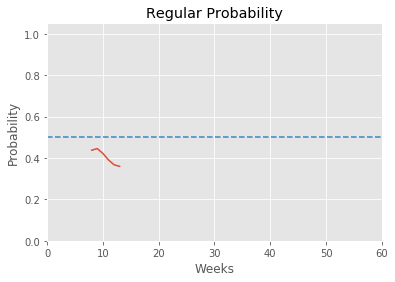

230
154646344
2013-03-08 15:08:55-05:00
2015-06-16 16:14:53-05:00


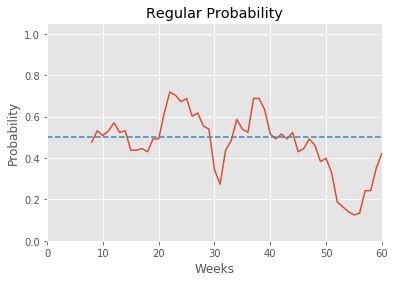

231
2975663354
2015-01-12 11:00:48-05:00
2015-04-07 08:56:07-05:00


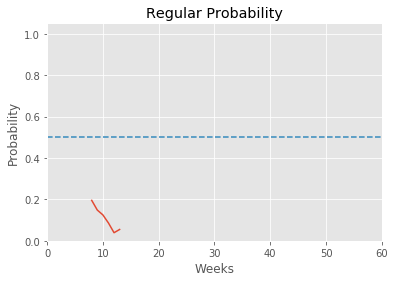

232
228350127
2011-02-01 11:45:01-05:00
2015-06-18 08:20:19-05:00


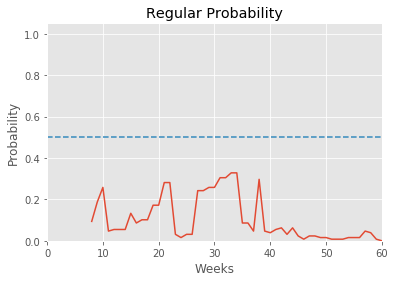

233
54740561
2013-01-14 20:05:44-05:00
2015-06-15 16:47:49-05:00
234
390455921
2012-10-24 01:26:16-05:00
2015-06-18 17:09:48-05:00


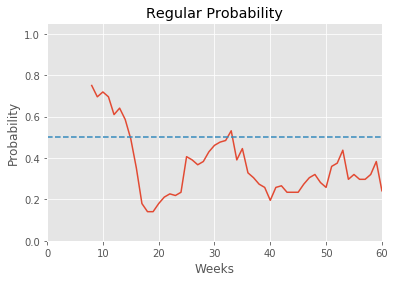

235
263281958
2011-09-09 21:32:28-05:00
2015-06-18 19:14:47-05:00
236
183667282
2013-05-10 20:26:39-05:00
2015-06-18 22:48:57-05:00


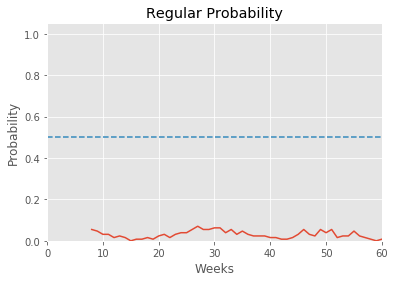

237
368404005
2011-11-09 13:42:38-05:00
2015-06-16 23:30:05-05:00


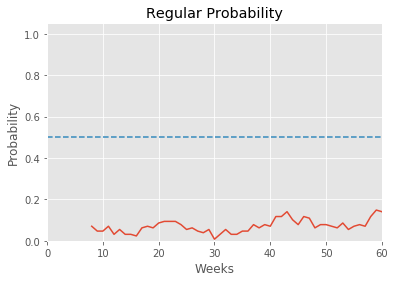

238
95499892
2009-12-08 23:04:38-05:00
2015-06-20 17:33:52-05:00
239
979898035
2013-02-07 23:04:38-05:00
2015-06-04 01:35:04-05:00


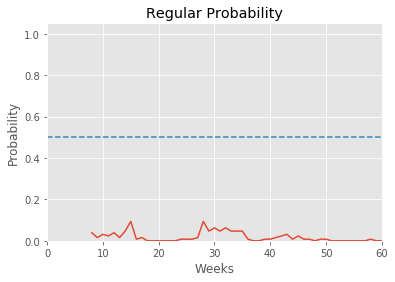

240
96768120
2010-04-04 14:54:08-05:00
2015-02-09 13:19:58-05:00
241
81245318
2009-10-10 00:01:25-05:00
2015-06-20 22:38:27-05:00
242
2994256424
2015-01-26 23:29:36-05:00
2015-06-19 15:36:38-05:00


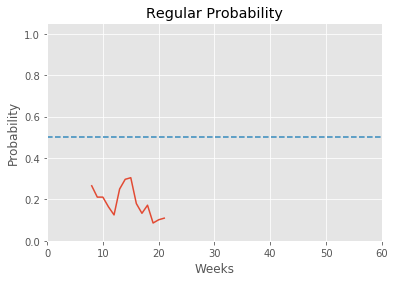

243
35542190
2013-04-23 06:22:59-05:00
2015-06-17 06:44:01-05:00


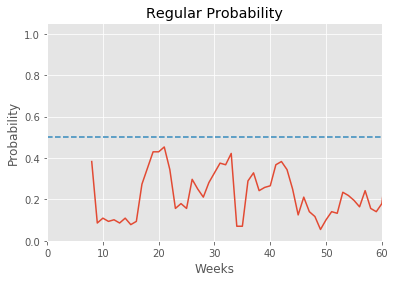

244
103516294
2012-11-27 17:39:57-05:00
2015-06-20 15:55:38-05:00


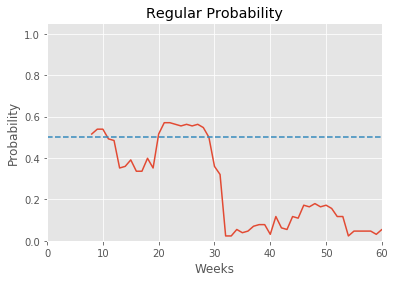

245
14889353
2013-09-13 01:46:47-05:00
2015-06-19 10:59:57-05:00


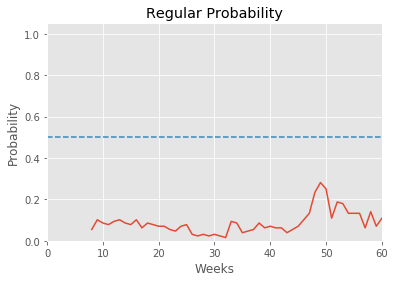

246
36188170
2012-03-23 03:46:49-05:00
2015-06-15 21:38:15-05:00
247
324739210
2011-06-27 04:11:28-05:00
2015-04-30 16:09:06-05:00
248
214962262
2012-11-16 21:46:17-05:00
2015-06-20 18:25:04-05:00


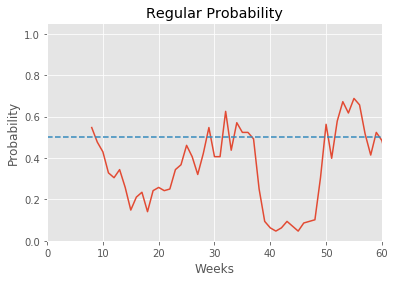

249
17902473
2015-02-04 22:04:02-05:00
2015-06-19 13:23:01-05:00


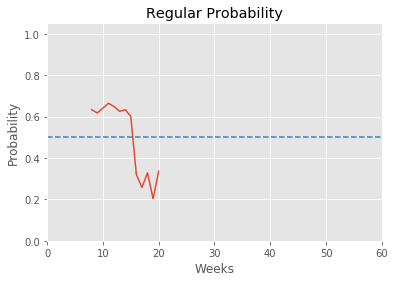

250
9092102
2007-09-25 10:37:17-05:00
2015-06-10 17:33:58-05:00
251
547838301
2012-04-08 06:27:23-05:00
2015-06-01 11:22:38-05:00


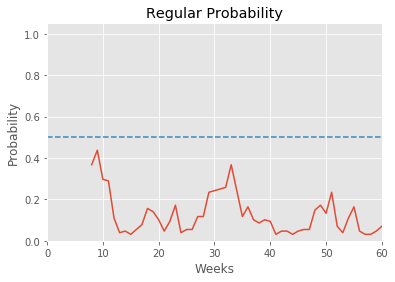

252
29791426
2013-06-12 07:42:08-05:00
2015-06-16 04:48:09-05:00


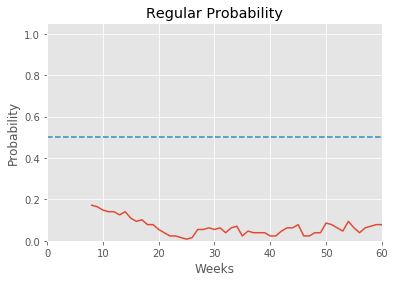

253
54895282
2010-04-27 17:02:07-05:00
2015-06-17 14:24:23-05:00


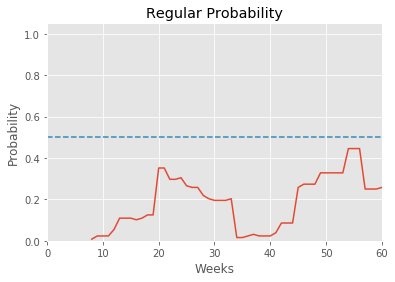

254
1437752046
2013-06-02 06:40:21-05:00
2015-06-19 13:11:05-05:00


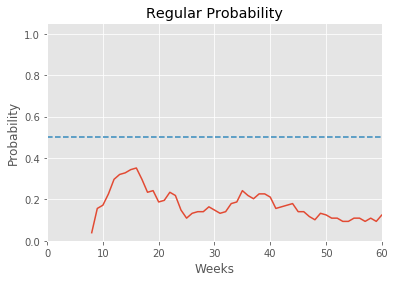

255
343784421
2012-12-12 21:01:17-05:00
2015-06-12 22:18:58-05:00


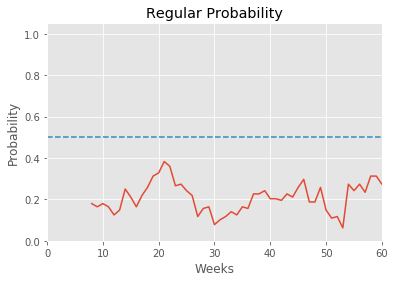

256
1096181412
2014-11-30 10:19:21-05:00
2015-06-20 13:32:28-05:00


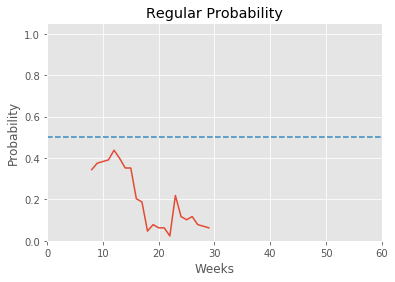

257
580212038
2014-12-04 06:09:56-05:00
2015-06-20 12:11:02-05:00


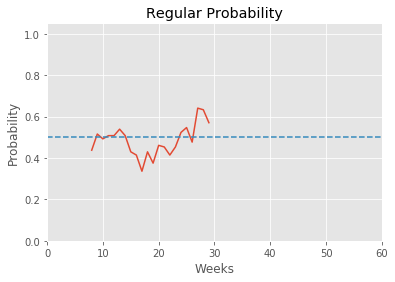

258
321717597
2011-11-29 22:38:09-05:00
2015-06-17 18:23:09-05:00


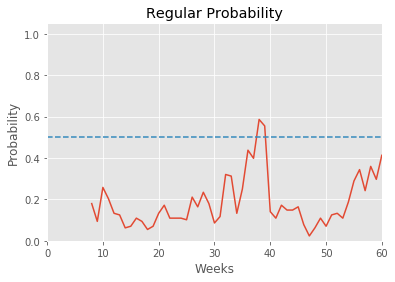

259
258224151
2014-07-05 14:19:51-05:00
2015-06-20 12:36:45-05:00


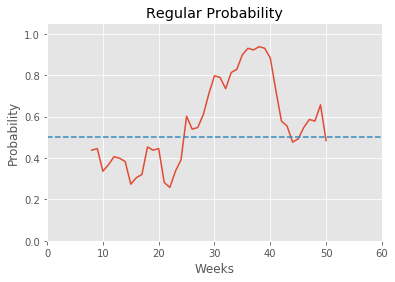

260
591740218
2012-06-28 09:10:53-05:00
2015-06-15 23:13:45-05:00


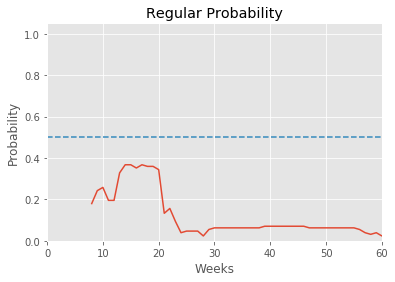

261
2362978945
2014-02-26 20:31:00-05:00
2015-06-19 06:07:24-05:00
262
65720963
2011-11-13 14:36:41-05:00
2015-06-19 10:21:33-05:00


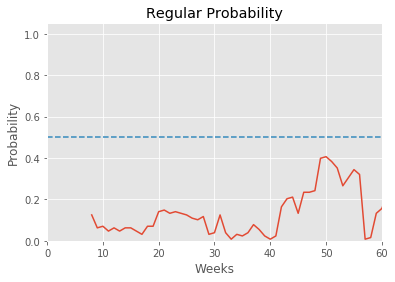

263
27916807
2009-03-31 22:28:15-05:00
2015-03-29 23:05:41-05:00
264
287420512
2012-02-24 08:55:00-05:00
2015-06-18 16:02:52-05:00


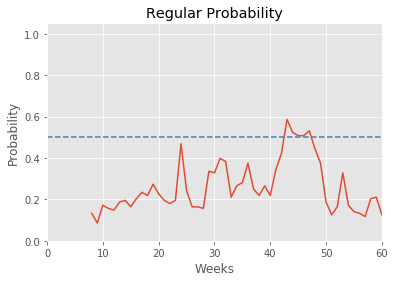

265
44413227
2009-07-16 13:48:57-05:00
2015-06-13 06:22:09-05:00
266
241284836
2011-01-22 01:35:01-05:00
2015-05-20 07:25:00-05:00
267
333688614
2013-10-23 23:08:17-05:00
2015-06-16 12:02:27-05:00


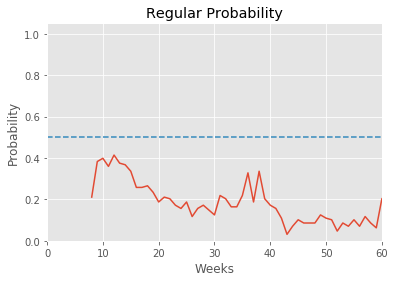

268
46615051
2009-06-11 22:33:09-05:00
2015-06-19 21:38:39-05:00
269
22990024
2013-05-03 11:42:39-05:00
2015-06-18 11:32:12-05:00


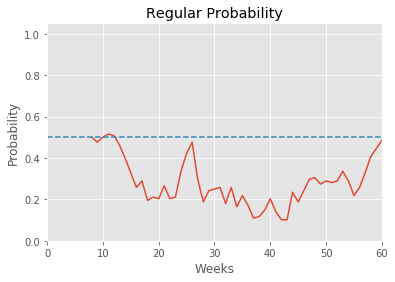

270
29533042
2012-09-12 19:28:52-05:00
2015-06-19 09:00:00-05:00


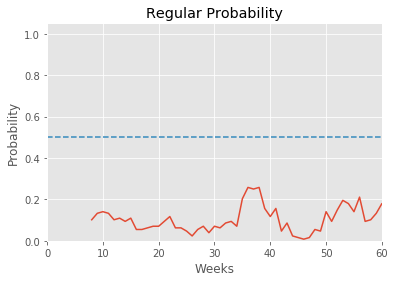

271
1853091864
2014-03-07 21:58:32-05:00
2015-06-16 01:15:24-05:00
272
600497248
2012-06-06 01:06:07-05:00
2015-04-01 03:07:29-05:00
273
185177025
2015-01-06 16:27:27-05:00
2015-06-19 12:02:28-05:00


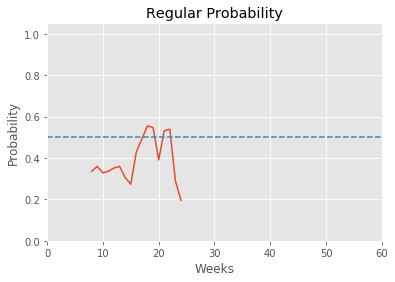

274
493541421
2013-09-10 11:35:10-05:00
2015-06-15 13:24:56-05:00


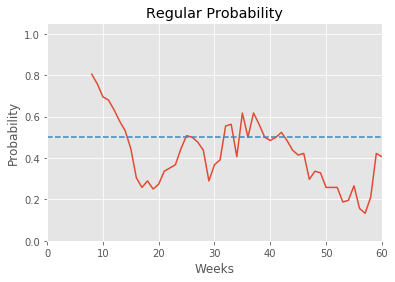

275
236948140
2014-05-20 01:34:50-05:00
2015-06-18 10:54:53-05:00


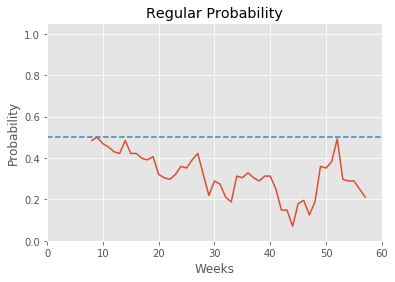

276
1730544535
2013-09-15 07:35:37-05:00
2015-06-16 04:13:12-05:00
277
88069350
2014-01-10 17:29:44-05:00
2015-06-18 23:23:20-05:00


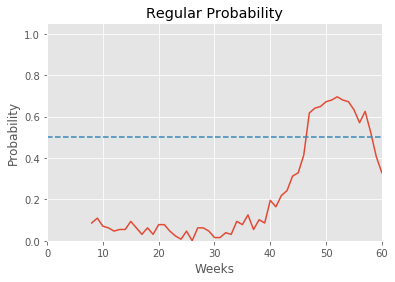

278
57947298
2014-01-11 21:43:39-05:00
2015-06-18 14:30:41-05:00


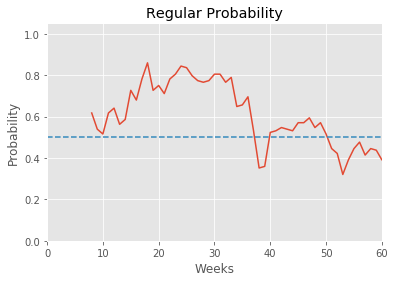

279
227863300
2012-06-19 21:06:23-05:00
2015-06-15 07:05:25-05:00


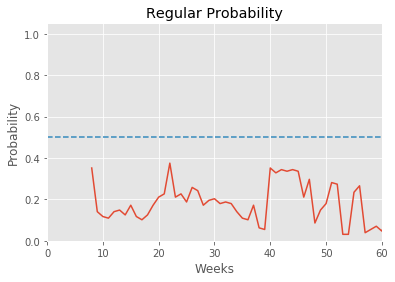

280
15927815
2013-08-11 15:11:46-05:00
2015-06-19 16:42:06-05:00


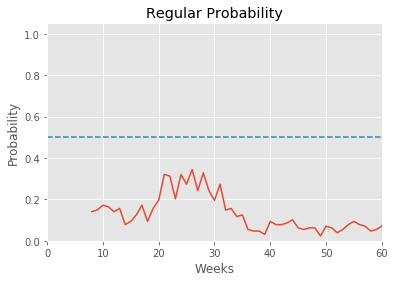

281
630192510
2014-07-07 09:02:34-05:00
2015-06-18 08:14:56-05:00


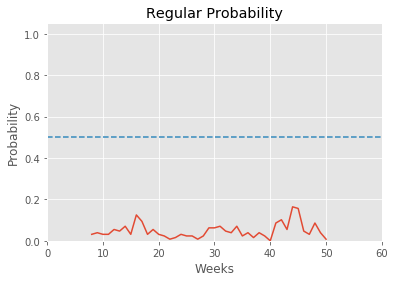

282
718224349
2012-08-27 07:25:15-05:00
2015-06-17 05:57:19-05:00
283
909153198
2013-02-06 17:21:47-05:00
2015-04-29 02:03:02-05:00
284
370934809
2012-08-12 03:59:01-05:00
2015-06-13 08:06:34-05:00
285
38285965
2009-06-19 13:22:16-05:00
2015-06-19 08:35:08-05:00


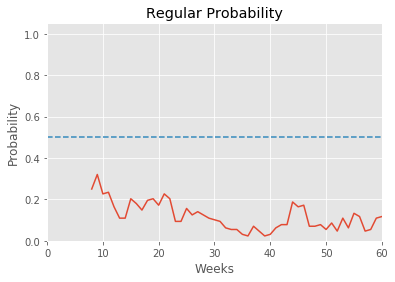

286
2881279632
2014-10-28 07:40:10-05:00
2014-11-27 04:09:26-05:00


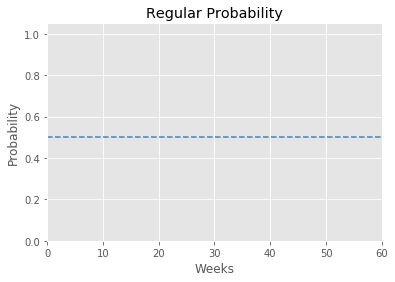

287
48465112
2012-10-04 02:39:41-05:00
2015-06-17 02:59:59-05:00


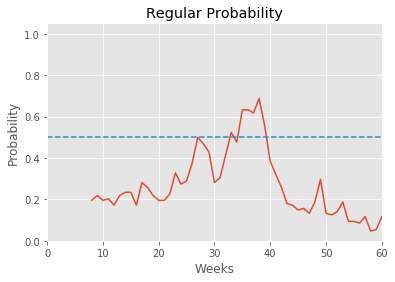

288
637237435
2014-08-23 13:00:07-05:00
2015-06-15 09:32:55-05:00


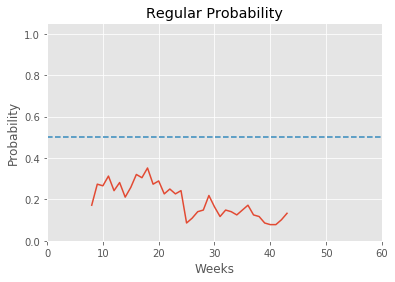

289
1031748547
2013-04-03 07:50:45-05:00
2015-06-20 18:52:05-05:00


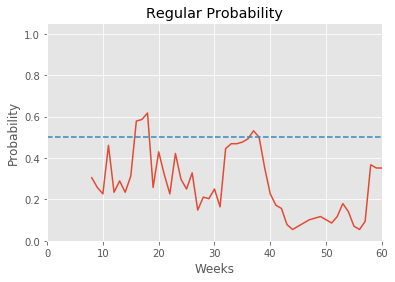

290
2802448264
2014-10-10 00:31:36-05:00
2015-06-17 23:24:15-05:00


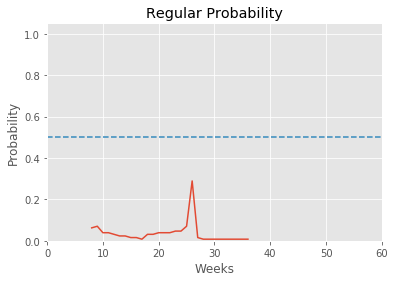

291
760173896
2014-04-26 01:24:24-05:00
2015-06-20 01:29:17-05:00


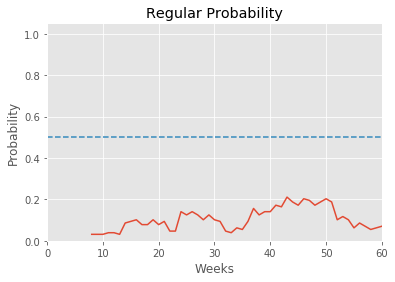

292
15231860
2013-02-20 08:39:08-05:00
2015-06-18 14:42:41-05:00


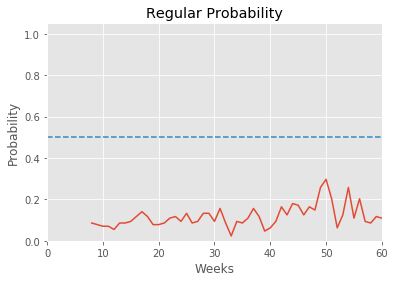

293
42445529
2011-09-25 23:59:00-05:00
2015-06-18 12:18:43-05:00
294
22993556
2009-03-06 02:11:04-05:00
2015-06-20 20:01:59-05:00
295
467277601
2015-04-10 07:25:22-05:00
2015-06-19 09:58:48-05:00


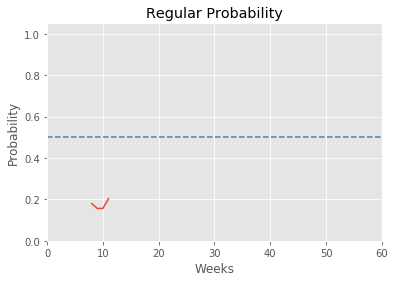

296
1184585454
2014-01-15 21:52:06-05:00
2015-06-21 02:32:26-05:00


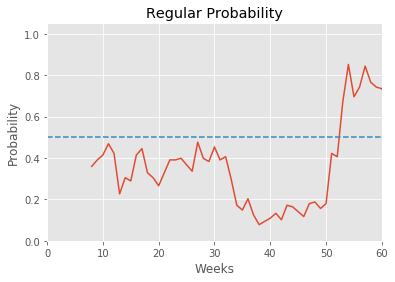

297
1368344516
2013-05-02 22:11:37-05:00
2015-06-19 13:01:50-05:00


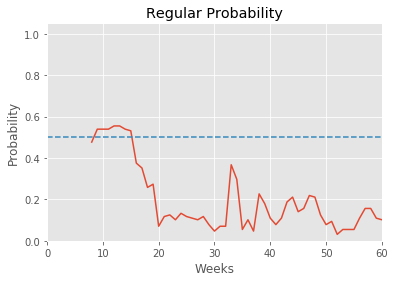

298
39646297
2009-05-13 02:10:31-05:00
2015-05-21 17:32:16-05:00
299
372862942
2012-06-22 02:52:31-05:00
2015-06-16 01:49:09-05:00


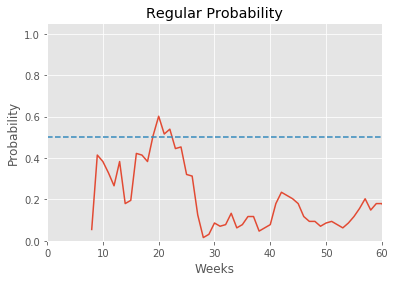

300
118151476
2013-07-02 07:41:12-05:00
2015-06-20 17:55:42-05:00


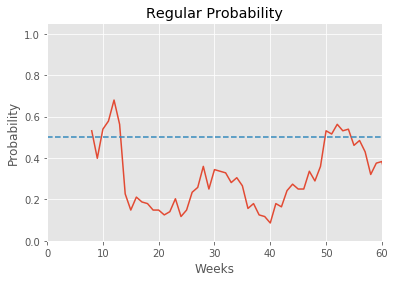

301
21284711
2009-02-19 10:21:03-05:00
2015-06-17 14:23:51-05:00
302
2864099350
2014-11-06 17:59:51-05:00
2015-02-09 06:18:24-05:00


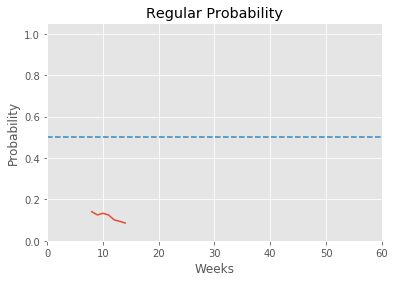

303
820697287
2012-10-30 03:38:54-05:00
2015-06-17 09:19:35-05:00


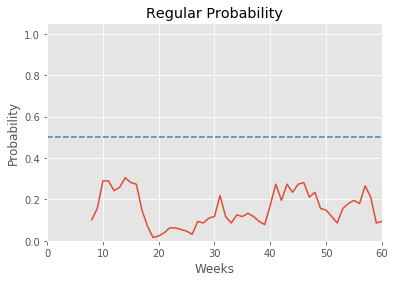

304
29250851
2010-01-19 04:05:13-05:00
2015-06-18 18:41:20-05:00


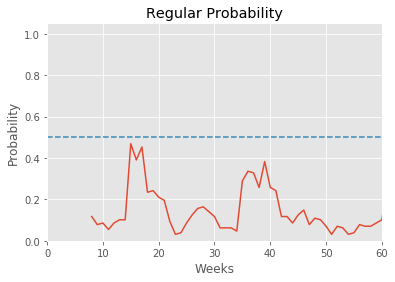

305
47650009
2011-01-13 17:50:16-05:00
2015-06-19 17:47:10-05:00
306
1335215958
2013-04-07 22:34:52-05:00
2015-06-20 00:16:16-05:00
307
238191614
2011-01-14 23:14:31-05:00
2015-06-19 12:43:08-05:00


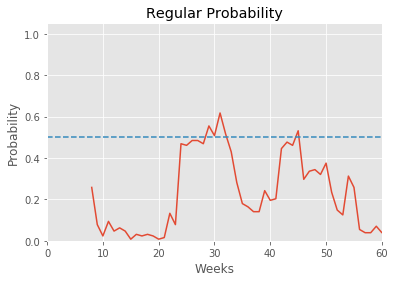

308
287956580
2015-02-09 03:13:53-05:00
2015-06-19 01:02:04-05:00


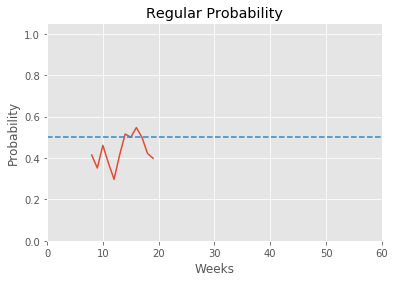

309
49066122
2009-06-20 17:48:35-05:00
2015-06-18 06:04:10-05:00
310
332137659
2011-07-29 12:59:25-05:00
2015-04-27 06:56:03-05:00
311
406335246
2013-03-05 23:50:56-05:00
2015-06-19 19:08:58-05:00


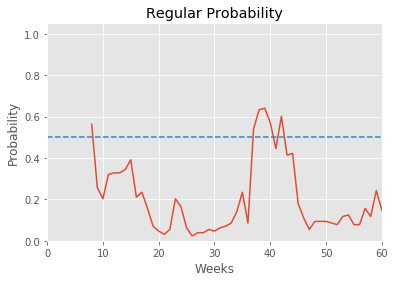

312
170913278
2014-02-10 15:59:29-05:00
2015-06-19 18:26:39-05:00


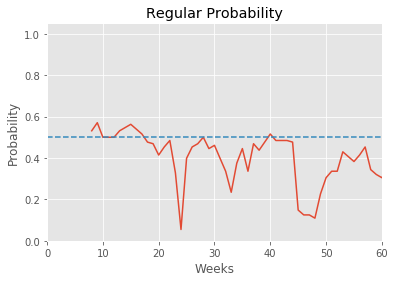

313
181615746
2010-08-22 21:47:51-05:00
2015-06-16 17:37:49-05:00


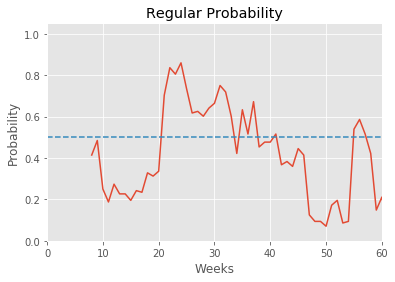

314
2922189332
2014-12-08 07:29:58-05:00
2015-06-20 18:00:00-05:00


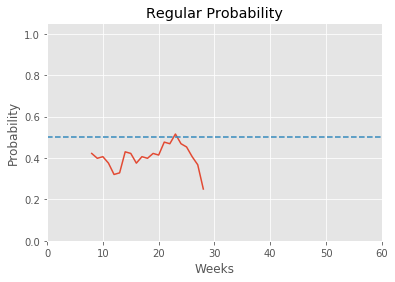

315
228755151
2013-07-02 04:53:35-05:00
2015-06-19 11:40:59-05:00


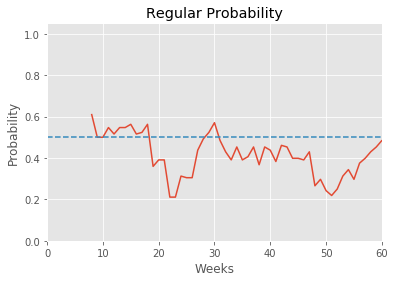

316
66321578
2012-09-09 05:34:44-05:00
2015-05-29 23:48:45-05:00
317
1475367386
2014-05-16 00:45:55-05:00
2015-06-18 19:28:35-05:00


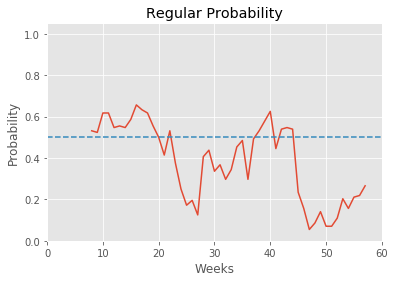

318
352269656
2011-08-10 12:54:39-05:00
2015-06-18 14:02:37-05:00
319
254166965
2011-02-18 20:23:58-05:00
2015-06-15 16:38:11-05:00
320
1648646648
2015-05-07 23:48:18-05:00
2015-06-17 22:18:33-05:00


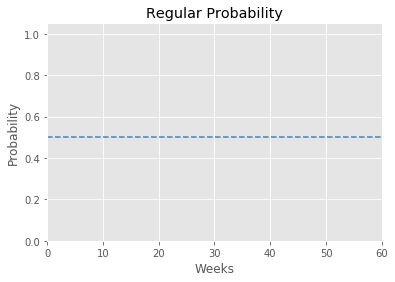

321
1881154128
2014-11-05 08:26:50-05:00
2015-05-08 18:21:17-05:00


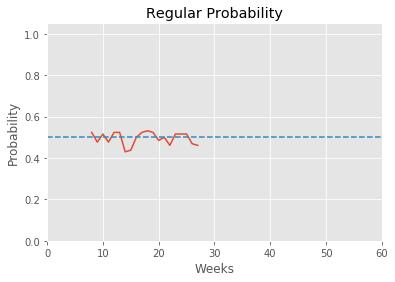

322
515053282
2013-11-24 23:25:55-05:00
2015-06-20 06:09:36-05:00


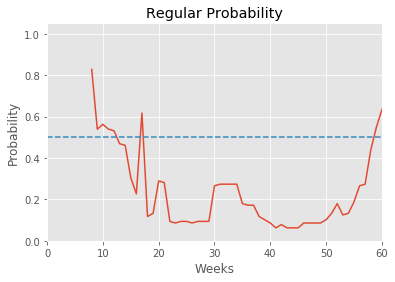

323
40333419
2009-07-10 17:37:25-05:00
2015-06-19 04:01:04-05:00
324
411102658
2012-04-01 07:45:45-05:00
2015-06-17 05:28:34-05:00


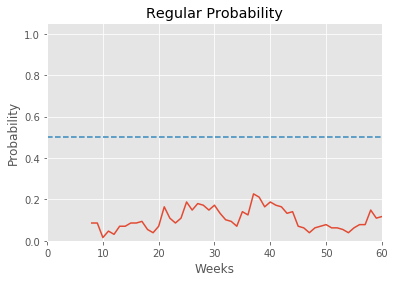

325
451858424
2013-03-11 20:29:46-05:00
2015-06-20 21:16:45-05:00


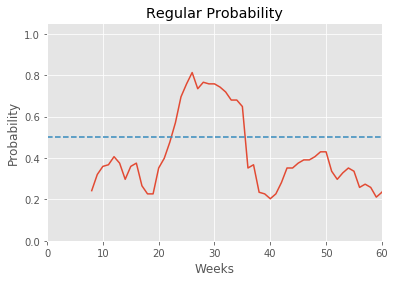

326
2995234655
2015-01-24 08:01:34-05:00
2015-06-20 05:14:12-05:00


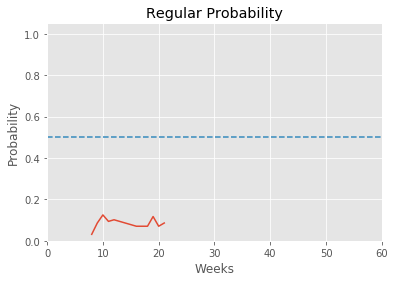

327
99624889
2012-12-06 09:22:25-05:00
2015-06-18 04:27:42-05:00


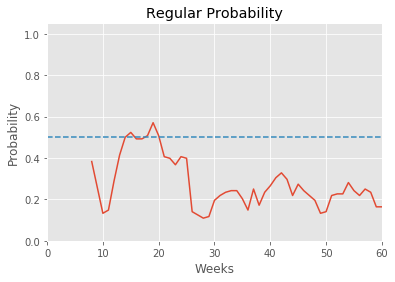

328
2233022917
2013-12-10 23:04:17-05:00
2015-06-19 12:48:28-05:00


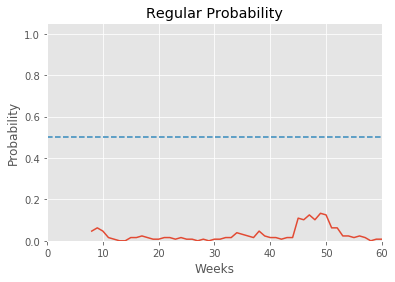

329
24170566
2014-07-15 19:09:54-05:00
2015-06-19 18:00:12-05:00


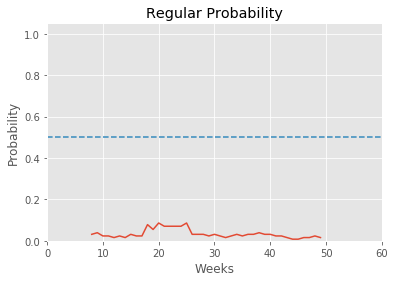

330
55453630
2012-09-27 08:25:58-05:00
2015-06-06 18:20:22-05:00


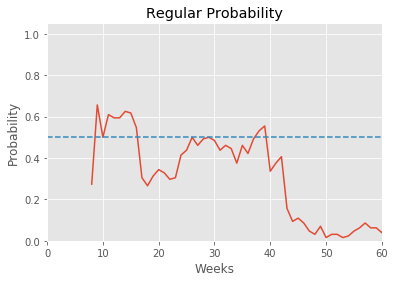

331
1074192828
2013-01-09 17:04:00-05:00
2015-06-16 12:15:57-05:00
332
42910151
2015-04-06 12:05:32-05:00
2015-06-20 09:59:42-05:00


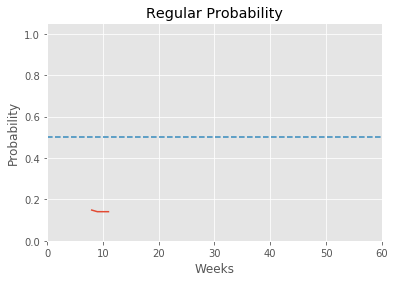

333
241918899
2011-10-13 16:31:49-05:00
2015-06-10 11:04:51-05:00


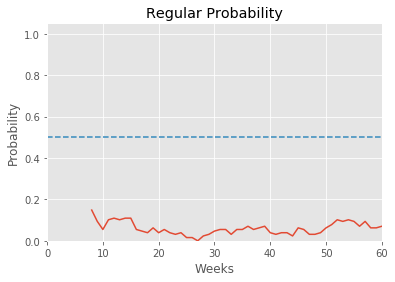

334
284560711
2011-04-19 13:48:52-05:00
2015-06-19 18:01:50-05:00
335
885352405
2013-11-07 04:35:50-05:00
2015-02-24 15:25:15-05:00


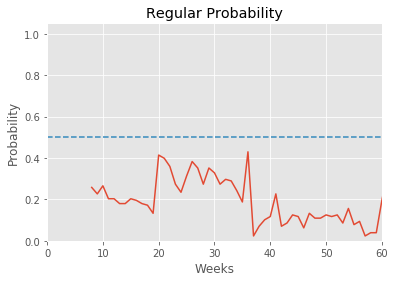

336
20746137
2009-02-13 04:02:44-05:00
2015-06-15 17:27:10-05:00
337
217984703
2013-09-28 00:53:53-05:00
2015-06-16 00:19:35-05:00


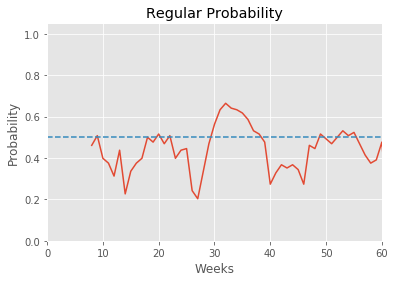

338
219279099
2010-12-11 13:56:34-05:00
2015-06-18 11:07:49-05:00
339
2684330241
2014-07-09 11:46:02-05:00
2014-12-12 04:11:46-05:00


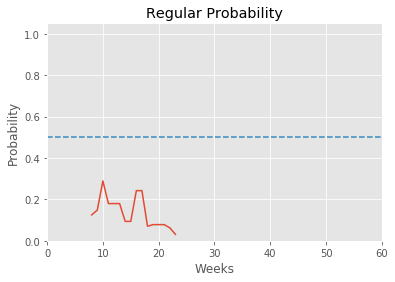

340
1345603926
2013-04-11 19:13:38-05:00
2015-04-29 18:25:35-05:00
341
1265385511
2013-03-13 15:40:29-05:00
2015-06-20 14:19:52-05:00


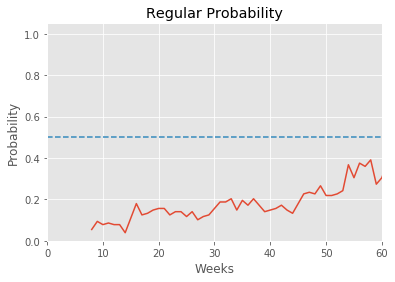

342
63810113
2012-11-17 17:14:51-05:00
2015-06-05 06:25:52-05:00


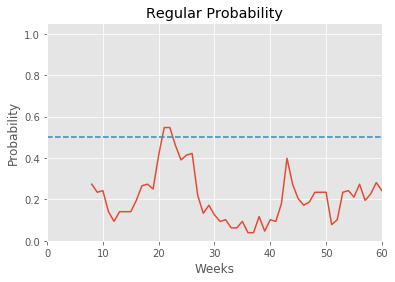

343
489543401
2012-02-11 12:17:06-05:00
2015-06-11 13:52:31-05:00


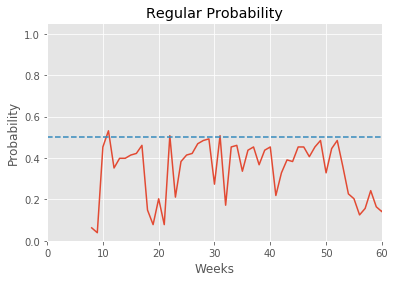

344
300304187
2014-11-28 07:46:33-05:00
2015-06-19 05:34:04-05:00


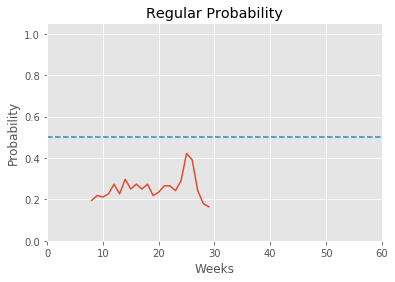

345
30716777
2012-12-04 03:24:57-05:00
2015-06-16 11:45:52-05:00
346
453605061
2014-12-28 04:29:40-05:00
2015-06-18 11:37:44-05:00


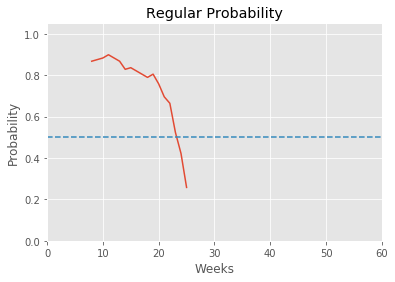

347
415265031
2014-05-23 18:55:33-05:00
2015-06-05 21:53:42-05:00


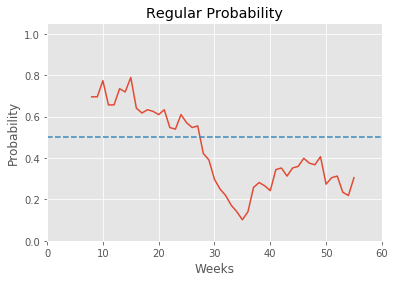

348
41700548
2014-06-06 08:49:01-05:00
2015-06-20 01:19:31-05:00


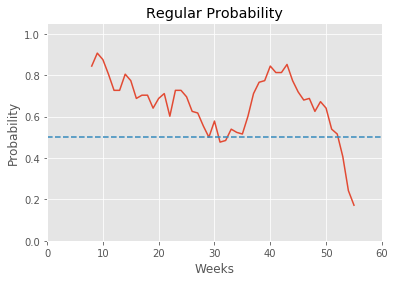

349
219880029
2012-05-08 10:37:29-05:00
2015-06-19 22:45:06-05:00
350
294748047
2012-05-26 08:20:17-05:00
2015-06-18 11:01:23-05:00


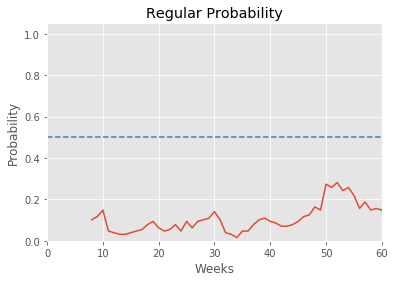

351
2460180258
2014-04-24 20:47:14-05:00
2015-06-18 23:01:01-05:00


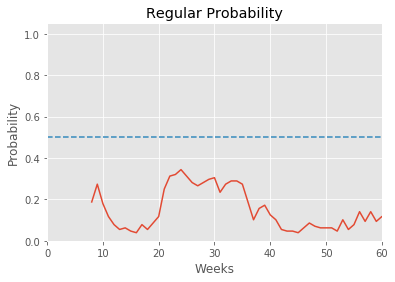

352
234537874
2011-01-05 22:25:22-05:00
2014-12-11 17:35:06-05:00
353
381800638
2013-04-04 05:06:25-05:00
2015-06-12 21:41:25-05:00


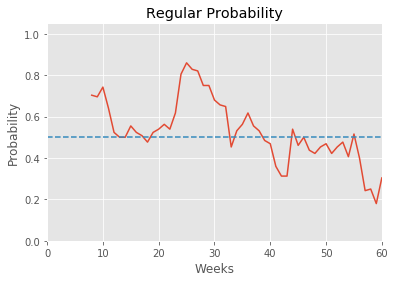

354
823750807
2012-09-14 12:41:54-05:00
2015-04-07 04:05:31-05:00
355
2400896190
2014-03-27 01:16:07-05:00
2015-06-13 08:30:12-05:00
356
529074289
2013-03-10 18:20:51-05:00
2015-06-16 01:59:27-05:00


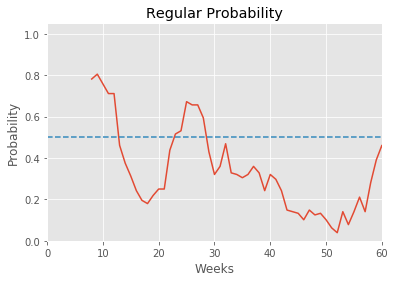

357
49438467
2012-09-26 01:43:24-05:00
2015-06-19 16:53:27-05:00


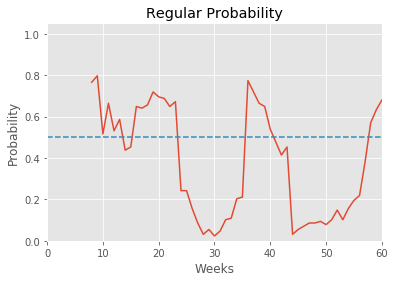

358
2212408807
2013-12-21 00:51:43-05:00
2015-03-22 08:40:01-05:00


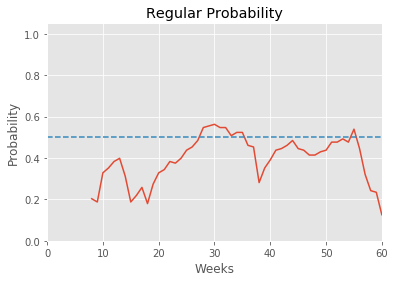

359
599625140
2012-06-04 16:55:43-05:00
2015-06-17 11:20:32-05:00
360
172636826
2013-08-29 00:21:33-05:00
2015-06-19 15:03:20-05:00


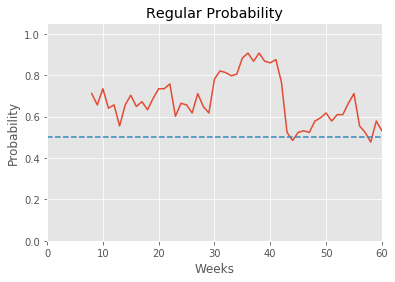

361
28412639
2012-04-06 08:38:16-05:00
2015-06-17 20:22:29-05:00


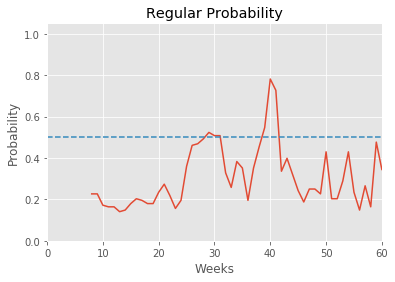

362
2269935746
2013-12-31 21:11:11-05:00
2015-06-18 15:37:01-05:00
363
76868396
2014-03-10 19:05:43-05:00
2015-06-18 12:54:33-05:00


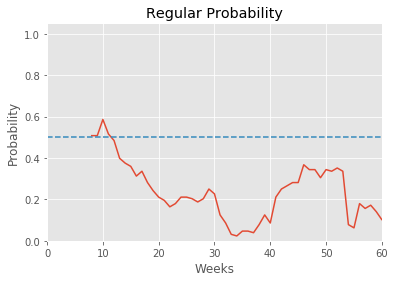

364
362592090
2011-08-28 15:06:15-05:00
2015-06-06 08:17:31-05:00
365
2247049488
2014-03-08 03:50:48-05:00
2015-06-20 10:18:23-05:00


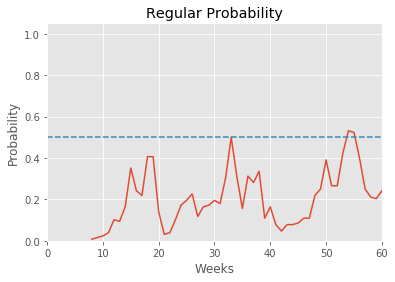

366
15365153
2012-02-23 01:51:33-05:00
2015-06-15 19:28:31-05:00
367
348812787
2013-06-30 22:51:22-05:00
2015-06-19 08:01:18-05:00


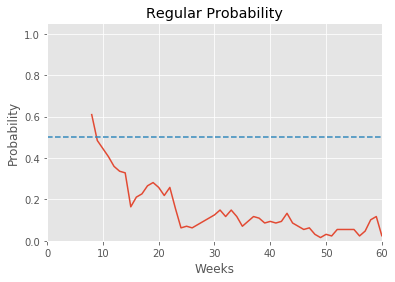

368
405306210
2012-06-09 20:55:24-05:00
2015-06-16 21:49:45-05:00


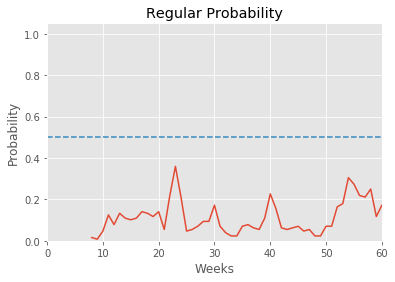

369
224053836
2010-12-08 06:33:08-05:00
2015-06-05 15:48:42-05:00
370
29818878
2009-10-28 14:56:35-05:00
2015-06-19 23:05:39-05:00
371
164771241
2010-12-12 01:31:11-05:00
2015-06-20 02:30:43-05:00
372
244203762
2014-09-12 02:58:50-05:00
2015-06-18 05:12:52-05:00


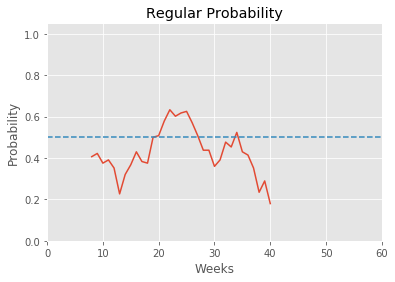

373
286651272
2013-04-26 02:43:21-05:00
2015-06-18 23:35:12-05:00


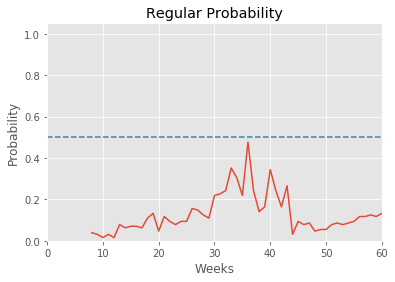

374
295355569
2012-09-04 03:37:32-05:00
2015-03-01 06:19:38-05:00
375
2255958408
2014-01-13 02:16:54-05:00
2015-06-18 04:20:53-05:00
376
2558375166
2014-06-10 01:00:21-05:00
2015-06-16 19:41:05-05:00


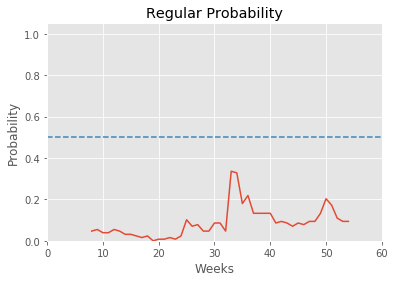

377
258466494
2011-02-27 15:19:50-05:00
2015-06-05 01:51:18-05:00


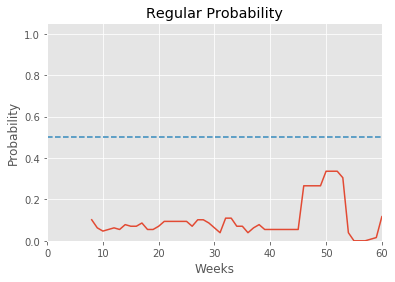

378
2872582948
2014-11-25 00:33:17-05:00
2015-06-19 12:25:33-05:00
379
330599302
2013-03-13 18:14:07-05:00
2015-06-19 15:15:24-05:00


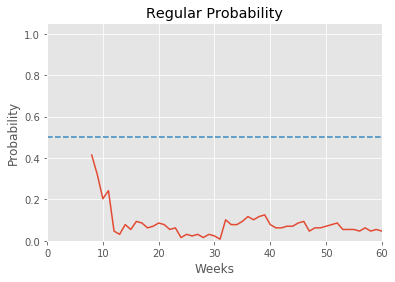

380
633078692
2012-07-11 13:03:35-05:00
2015-06-20 14:26:48-05:00


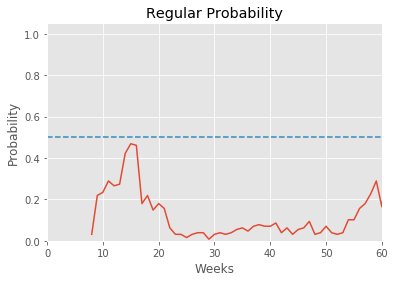

381
456523609
2012-01-06 05:40:14-05:00
2015-06-18 04:47:03-05:00
382
115969905
2010-03-04 18:10:39-05:00
2015-05-06 02:27:18-05:00
383
273509015
2014-02-01 19:32:39-05:00
2015-06-16 03:07:21-05:00
384
1101830304
2013-01-20 17:09:24-05:00
2015-04-11 15:55:49-05:00
385
104572011
2014-08-06 14:45:27-05:00
2015-06-18 13:53:08-05:00


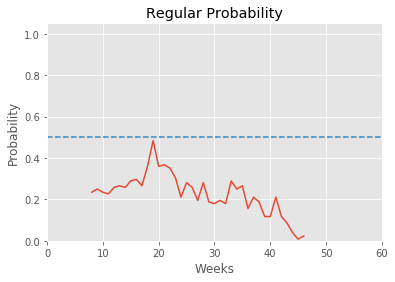

386
411794643
2014-07-21 00:07:48-05:00
2015-06-18 01:59:40-05:00


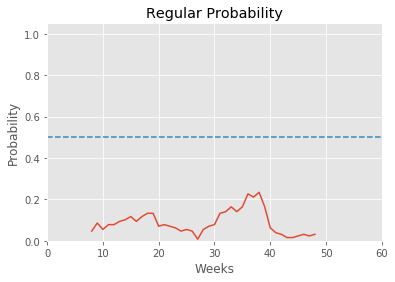

387
159246384
2014-09-24 17:07:19-05:00
2015-06-19 11:12:52-05:00


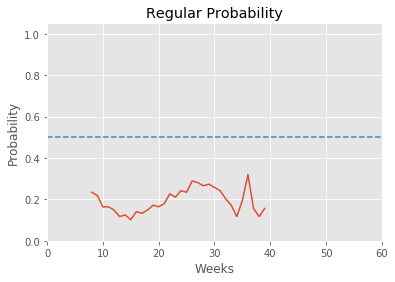

388
31460332
2009-05-01 17:26:40-05:00
2015-06-20 03:57:19-05:00
389
23262294
2009-10-09 13:52:30-05:00
2015-06-15 17:05:11-05:00
390
374148443
2012-03-06 15:18:02-05:00
2015-06-11 15:39:24-05:00
391
860709974
2012-10-04 04:36:09-05:00
2015-06-19 05:22:23-05:00


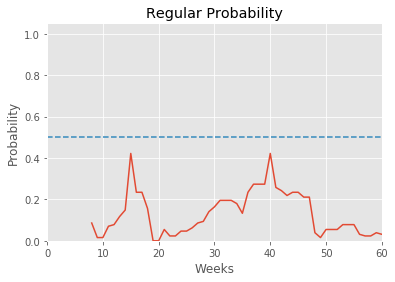

392
2595069624
2014-06-29 23:24:12-05:00
2015-05-26 15:23:43-05:00


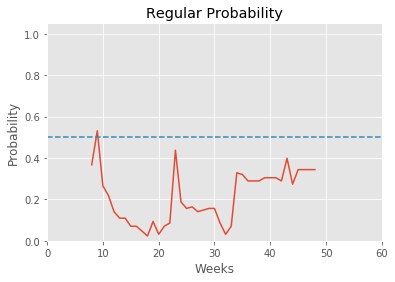

393
83614252
2012-01-20 04:34:23-05:00
2015-06-19 16:05:17-05:00


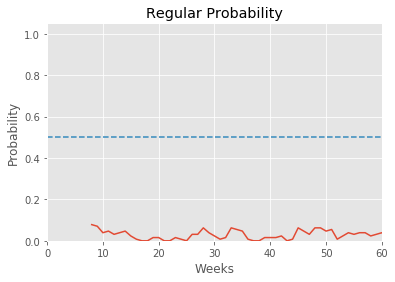

394
256150328
2013-04-15 03:25:21-05:00
2015-06-19 12:16:19-05:00


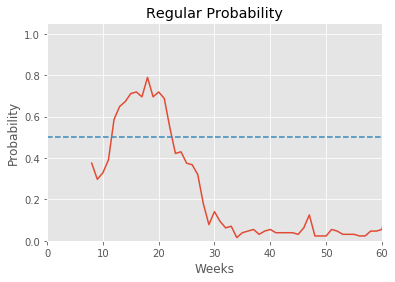

395
286241046
2011-04-29 16:27:48-05:00
2015-05-20 17:33:36-05:00
396
624199231
2014-04-15 22:06:35-05:00
2015-06-19 07:18:41-05:00


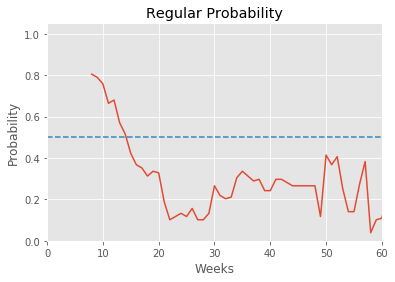

397
244730434
2012-07-15 17:18:33-05:00
2015-01-27 05:25:47-05:00


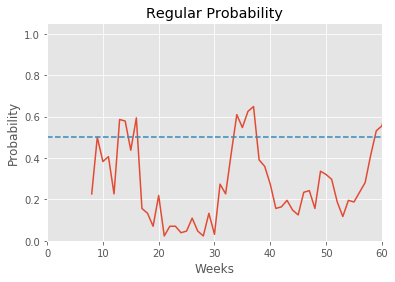

398
48666639
2011-03-16 04:58:16-05:00
2015-06-19 06:44:00-05:00
399
437098863
2011-12-20 06:09:39-05:00
2015-06-16 04:06:18-05:00
400
37581602
2013-04-04 22:04:28-05:00
2015-05-25 06:50:30-05:00


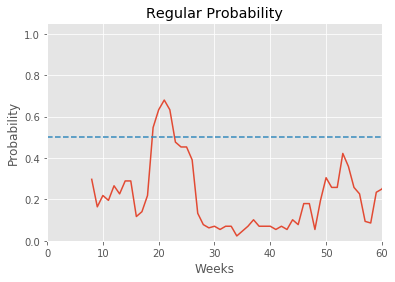

401
83107922
2009-10-17 05:26:51-05:00
2015-05-29 03:03:53-05:00
402
541860364
2014-03-10 05:31:22-05:00
2015-06-02 17:06:33-05:00


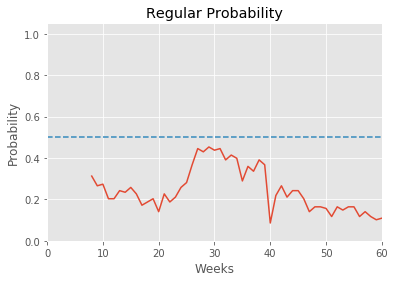

403
26087220
2013-12-13 01:45:23-05:00
2015-06-19 14:43:12-05:00


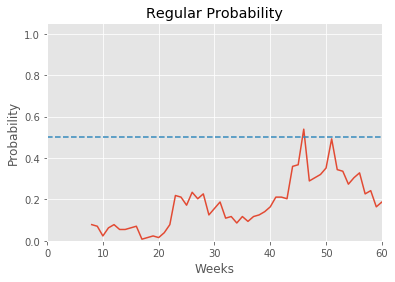

404
136383154
2010-04-25 13:06:02-05:00
2015-06-20 18:33:28-05:00
405
19753332
2009-02-09 05:51:29-05:00
2015-04-25 18:20:22-05:00
406
92696690
2009-11-26 07:12:45-05:00
2015-06-11 20:06:59-05:00


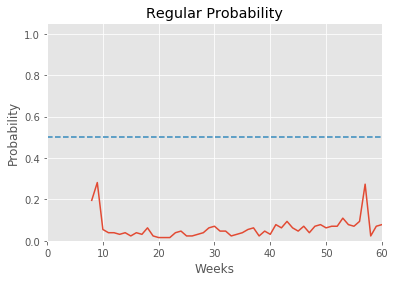

407
979911330
2013-01-02 06:08:12-05:00
2015-06-11 07:47:19-05:00
408
2280006308
2014-01-07 07:27:50-05:00
2015-06-20 23:20:16-05:00


In [29]:
for i, regular_timeline in enumerate(regular_clean):
    print(i)
    print(regular_clean[i]['name'][0])
    print(regular_clean[i].index[0])
    print(regular_clean[i].index[-1])
    try:
        predict_prob_list = pol_report(regular_timeline)
        if len(predict_prob_list) < 1 : 
            print('\t No match time')
            continue
        plt.plot(range(len(predict_prob_list)+8)[8:],[window_info['bipolar_probability'] for window_info in predict_prob_list])
        plt.xlabel('Weeks')
        plt.ylabel('Probability')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 60])
        plt.plot((0, 60), (0.5, 0.5), '--')
        plt.title("Regular Probability")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        plt.close()
    except:
        continue

In [31]:
regular_clean[320]

polarity ambiguous        name  \
2015-05-07 23:48:18-05:00         0     False  1648646648   
2015-05-07 23:57:47-05:00         0     False  1648646648   
2015-05-08 00:00:34-05:00         0     False  1648646648   
2015-05-08 00:02:40-05:00         0     False  1648646648   
2015-05-08 00:11:38-05:00         0     False  1648646648   
2015-05-08 00:12:16-05:00         0     False  1648646648   
2015-05-08 00:22:31-05:00         0     False  1648646648   
2015-05-08 00:24:17-05:00        -1     False  1648646648   
2015-05-08 00:26:10-05:00         0     False  1648646648   
2015-05-08 00:28:32-05:00         0     False  1648646648   
2015-05-08 00:43:26-05:00         0     False  1648646648   
2015-05-08 01:34:09-05:00         0      True  1648646648   
2015-05-08 01:44:52-05:00        -1     False  1648646648   
2015-05-08 02:17:30-05:00         0     False  1648646648   
2015-05-08 04:25:36-05:00         0     False  1648646648   
2015-05-08 04:25:42-05:00         0     False  1648646648   
2015-05-08 04:26:56-05:00         0      True  1648646648   
2015-05-08 04:28:33-05:00         0     False  1648646648   
2015-05-08 04:47:20-05:00         1     False  1648646648   
2015-05-08 05:05:35-05:00        -1     False  1648646648   
2015-05-08 05:15:42-05:00         0      True  1648646648   
2015-05-08 05:15:55-05:00         0     False  1648646648   
2015-05-08 05:17:14-05:00         0     False  1648646648   
2015-05-08 08:27:01-05:00        -1      True  1648646648   
2015-05-08 08:29:20-05:00        -1      True  1648646648   
2015-05-08 08:32:07-05:00        -1     False  1648646648   
2015-05-08 08:34:27-05:00        -1     False  1648646648   
2015-05-08 08:36:01-05:00         0     False  1648646648   
2015-05-08 08:38:29-05:00        -1     False  1648646648   
2015-05-08 08:39:03-05:00         0     False  1648646648   
...                             ...       ...         ...   
2015-06-17 12:03:27-05:00         1      True  1648646648   
2015-06-17 12:08:33-05:00         0     False  1648646648   
2015-06-17 12:10:29-05:00        -1      True  1648646648   
2015-06-17 12:11:18-05:00         0     False  1648646648   
2015-06-17 12:14:01-05:00         0     False  1648646648   
2015-06-17 12:17:28-05:00        -1     False  1648646648   
2015-06-17 12:20:53-05:00        -1      True  1648646648   
2015-06-17 12:21:37-05:00         0      True  1648646648   
2015-06-17 12:22:51-05:00         0      True  1648646648   
2015-06-17 13:05:52-05:00         1      True  1648646648   
2015-06-17 13:07:28-05:00         0     False  1648646648   
2015-06-17 14:10:44-05:00         0     False  1648646648   
2015-06-17 14:12:30-05:00        -1     False  1648646648   
2015-06-17 14:13:01-05:00        -1     False  1648646648   
2015-06-17 14:20:00-05:00         1     False  1648646648   
2015-06-17 14:23:56-05:00         0     False  1648646648   
2015-06-17 14:25:35-05:00         0     False  1648646648   
2015-06-17 14:27:13-05:00         0      True  1648646648   
2015-06-17 14:28:08-05:00         0      True  1648646648   
2015-06-17 14:29:00-05:00         0     False  1648646648   
2015-06-17 14:29:18-05:00        -1     False  1648646648   
2015-06-17 14:37:03-05:00         0     False  1648646648   
2015-06-17 14:45:54-05:00        -1     False  1648646648   
2015-06-17 14:55:54-05:00         0     False  1648646648   
2015-06-17 14:56:16-05:00        -1     False  1648646648   
2015-06-17 14:59:43-05:00         1      True  1648646648   
2015-06-17 15:02:53-05:00         0      True  1648646648   
2015-06-17 15:03:15-05:00         0     False  1648646648   
2015-06-17 22:17:22-05:00         0      True  1648646648   
2015-06-17 22:18:33-05:00        -1     False  1648646648   

                                                                        text  \
2015-05-07 23:48:18-05:00  Sometimes I think Rih spoiled us too much... L...   
2015-05-07 23:57:47-05:00             @badg4lrihanna I'm tempted actually 👀😭   
2015

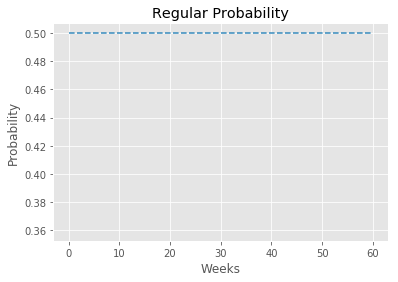

In [32]:
result = pol_report(regular_clean[320])
y = [window_info['bipolar_probability'] for window_info in result]
plt.plot(y)
plt.plot((0, 60), (0.5, 0.5), '--')
plt.xlabel('Weeks')
plt.ylabel('Probability')
plt.title("Regular Probability")

plt.legend(loc="lower right")

plt.show()

In [36]:
features = getPOLFeature(getTimeSeries(regular_clean[320]))

In [39]:

bipolar_model.predict_proba(features[0])[0][0][1]


0.359375

In [ ]:
def pol_report(timeline):
#     A list of 8-weeks-timeSeries timeline
    timeSeries_list = getTimeSeries(timeline)
    features = getPOLFeature(timeSeries_list)
    
    user_timeline_reports = []
    for i, feature in enumerate(features):
        timeSeries = timeSeries_list[i]
#         print(bipolar_model.predict_proba(feature))
        bipolar_proba = bipolar_model.predict_proba(feature)[0][0][1]

        report = {}
        report["tweets_length"] = timeSeries_list[i].shape[0]
        report["tweeting_frequency"] = feature[0]
        report["late_tweeting_frequency"] = feature[1]
        report["mentioning_frequency"] = feature[2]
        report["unique_mentioning"] = feature[3]
        report["frequent_mentioning"] = feature[4]
        report["positive_ratio"] = feature[5]
        report["negative_ratio"] = feature[6]
        report["flips_ratio"] = feature[7]
        report["negative_combos"] = feature[8]
        report["positive_combos"] = feature[9]
        report["age"] = features[0][10]
        report["gender"] = "Male" if features[0][11] < 0 else "Female"
        report["bipolar_probability"] = bipolar_proba
        
        user_timeline_reports.append(report)

    return user_timeline_reports
